In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_CAP_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4014968, 829)
(4014968, 8)
validation
(782336, 829)
(782336, 8)
test
(325224, 829)
(325224, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1539976 (5.87 MB)


Trainable params: 1539976 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/402 [..............................] - ETA: 11:26 - loss: 2.1894 - STD: 0.0634 - MAE: 0.2186

  4/402 [..............................] - ETA: 8s - loss: 2.1029 - STD: 0.0490 - MAE: 0.2169   

  7/402 [..............................] - ETA: 8s - loss: 2.0954 - STD: 0.0482 - MAE: 0.2167

 10/402 [..............................] - ETA: 9s - loss: 2.0834 - STD: 0.0449 - MAE: 0.2166

 13/402 [..............................] - ETA: 8s - loss: 2.0759 - STD: 0.0412 - MAE: 0.2167

 16/402 [>.............................] - ETA: 8s - loss: 2.0709 - STD: 0.0397 - MAE: 0.2166

 19/402 [>.............................] - ETA: 8s - loss: 2.0644 - STD: 0.0390 - MAE: 0.2165

 22/402 [>.............................] - ETA: 8s - loss: 2.0566 - STD: 0.0382 - MAE: 0.2163

 25/402 [>.............................] - ETA: 8s - loss: 2.0471 - STD: 0.0387 - MAE: 0.2159

 28/402 [=>............................] - ETA: 8s - loss: 2.0359 - STD: 0.0404 - MAE: 0.2154

 31/402 [=>............................] - ETA: 8s - loss: 2.0231 - STD: 0.0427 - MAE: 0.2148

 34/402 [=>............................] - ETA: 8s - loss: 2.0103 - STD: 0.0448 - MAE: 0.2142

 37/402 [=>............................] - ETA: 8s - loss: 1.9973 - STD: 0.0471 - MAE: 0.2135

 40/402 [=>............................] - ETA: 8s - loss: 1.9844 - STD: 0.0495 - MAE: 0.2128

 43/402 [==>...........................] - ETA: 8s - loss: 1.9717 - STD: 0.0518 - MAE: 0.2122

 46/402 [==>...........................] - ETA: 8s - loss: 1.9601 - STD: 0.0538 - MAE: 0.2116

 49/402 [==>...........................] - ETA: 8s - loss: 1.9478 - STD: 0.0557 - MAE: 0.2110

 52/402 [==>...........................] - ETA: 8s - loss: 1.9359 - STD: 0.0575 - MAE: 0.2104

 55/402 [===>..........................] - ETA: 13s - loss: 1.9262 - STD: 0.0594 - MAE: 0.2098

 58/402 [===>..........................] - ETA: 13s - loss: 1.9138 - STD: 0.0612 - MAE: 0.2092

 61/402 [===>..........................] - ETA: 12s - loss: 1.9010 - STD: 0.0629 - MAE: 0.2085

 64/402 [===>..........................] - ETA: 12s - loss: 1.8877 - STD: 0.0646 - MAE: 0.2079

 67/402 [====>.........................] - ETA: 12s - loss: 1.8742 - STD: 0.0664 - MAE: 0.2071

 69/402 [====>.........................] - ETA: 12s - loss: 1.8649 - STD: 0.0678 - MAE: 0.2066

 72/402 [====>.........................] - ETA: 11s - loss: 1.8514 - STD: 0.0699 - MAE: 0.2058

 75/402 [====>.........................] - ETA: 11s - loss: 1.8382 - STD: 0.0719 - MAE: 0.2050

 78/402 [====>.........................] - ETA: 11s - loss: 1.8254 - STD: 0.0740 - MAE: 0.2042

 81/402 [=====>........................] - ETA: 10s - loss: 1.8129 - STD: 0.0760 - MAE: 0.2033

 84/402 [=====>........................] - ETA: 10s - loss: 1.8006 - STD: 0.0780 - MAE: 0.2026

 87/402 [=====>........................] - ETA: 10s - loss: 1.7886 - STD: 0.0799 - MAE: 0.2018

 90/402 [=====>........................] - ETA: 10s - loss: 1.7771 - STD: 0.0817 - MAE: 0.2010

 93/402 [=====>........................] - ETA: 10s - loss: 1.7658 - STD: 0.0835 - MAE: 0.2002

 96/402 [======>.......................] - ETA: 9s - loss: 1.7553 - STD: 0.0852 - MAE: 0.1995 

 99/402 [======>.......................] - ETA: 9s - loss: 1.7447 - STD: 0.0869 - MAE: 0.1988

102/402 [======>.......................] - ETA: 9s - loss: 1.7345 - STD: 0.0886 - MAE: 0.1980

105/402 [======>.......................] - ETA: 9s - loss: 1.7244 - STD: 0.0903 - MAE: 0.1973

108/402 [=======>......................] - ETA: 9s - loss: 1.7148 - STD: 0.0919 - MAE: 0.1966

111/402 [=======>......................] - ETA: 9s - loss: 1.7053 - STD: 0.0935 - MAE: 0.1959

114/402 [=======>......................] - ETA: 8s - loss: 1.6959 - STD: 0.0950 - MAE: 0.1952

117/402 [=======>......................] - ETA: 8s - loss: 1.6870 - STD: 0.0966 - MAE: 0.1945

120/402 [=======>......................] - ETA: 8s - loss: 1.6785 - STD: 0.0981 - MAE: 0.1938

123/402 [========>.....................] - ETA: 8s - loss: 1.6701 - STD: 0.0995 - MAE: 0.1932

126/402 [========>.....................] - ETA: 8s - loss: 1.6623 - STD: 0.1009 - MAE: 0.1925

129/402 [========>.....................] - ETA: 8s - loss: 1.6549 - STD: 0.1022 - MAE: 0.1919

132/402 [========>.....................] - ETA: 8s - loss: 1.6479 - STD: 0.1035 - MAE: 0.1914

135/402 [=========>....................] - ETA: 7s - loss: 1.6409 - STD: 0.1048 - MAE: 0.1908

138/402 [=========>....................] - ETA: 7s - loss: 1.6342 - STD: 0.1059 - MAE: 0.1903

141/402 [=========>....................] - ETA: 7s - loss: 1.6276 - STD: 0.1071 - MAE: 0.1897

144/402 [=========>....................] - ETA: 7s - loss: 1.6212 - STD: 0.1082 - MAE: 0.1892

147/402 [=========>....................] - ETA: 7s - loss: 1.6151 - STD: 0.1093 - MAE: 0.1887

150/402 [==========>...................] - ETA: 7s - loss: 1.6089 - STD: 0.1104 - MAE: 0.1882

153/402 [==========>...................] - ETA: 7s - loss: 1.6032 - STD: 0.1114 - MAE: 0.1877

156/402 [==========>...................] - ETA: 7s - loss: 1.5977 - STD: 0.1124 - MAE: 0.1873

159/402 [==========>...................] - ETA: 6s - loss: 1.5923 - STD: 0.1133 - MAE: 0.1868

162/402 [===========>..................] - ETA: 6s - loss: 1.5871 - STD: 0.1143 - MAE: 0.1864

165/402 [===========>..................] - ETA: 6s - loss: 1.5819 - STD: 0.1152 - MAE: 0.1860

168/402 [===========>..................] - ETA: 6s - loss: 1.5771 - STD: 0.1161 - MAE: 0.1856

171/402 [===========>..................] - ETA: 6s - loss: 1.5723 - STD: 0.1169 - MAE: 0.1852

174/402 [===========>..................] - ETA: 6s - loss: 1.5676 - STD: 0.1178 - MAE: 0.1848

177/402 [============>.................] - ETA: 6s - loss: 1.5630 - STD: 0.1186 - MAE: 0.1844

180/402 [============>.................] - ETA: 6s - loss: 1.5585 - STD: 0.1194 - MAE: 0.1840

183/402 [============>.................] - ETA: 6s - loss: 1.5541 - STD: 0.1202 - MAE: 0.1836

186/402 [============>.................] - ETA: 6s - loss: 1.5498 - STD: 0.1209 - MAE: 0.1833

189/402 [=============>................] - ETA: 5s - loss: 1.5456 - STD: 0.1217 - MAE: 0.1829

192/402 [=============>................] - ETA: 5s - loss: 1.5415 - STD: 0.1224 - MAE: 0.1826

195/402 [=============>................] - ETA: 5s - loss: 1.5375 - STD: 0.1231 - MAE: 0.1823

198/402 [=============>................] - ETA: 5s - loss: 1.5335 - STD: 0.1238 - MAE: 0.1819

201/402 [==============>...............] - ETA: 5s - loss: 1.5299 - STD: 0.1244 - MAE: 0.1816

204/402 [==============>...............] - ETA: 5s - loss: 1.5262 - STD: 0.1251 - MAE: 0.1813

207/402 [==============>...............] - ETA: 5s - loss: 1.5224 - STD: 0.1257 - MAE: 0.1810

210/402 [==============>...............] - ETA: 5s - loss: 1.5189 - STD: 0.1264 - MAE: 0.1807

213/402 [==============>...............] - ETA: 5s - loss: 1.5154 - STD: 0.1270 - MAE: 0.1804

216/402 [===============>..............] - ETA: 5s - loss: 1.5120 - STD: 0.1276 - MAE: 0.1801

219/402 [===============>..............] - ETA: 4s - loss: 1.5086 - STD: 0.1282 - MAE: 0.1798

222/402 [===============>..............] - ETA: 4s - loss: 1.5054 - STD: 0.1288 - MAE: 0.1795

225/402 [===============>..............] - ETA: 4s - loss: 1.5022 - STD: 0.1294 - MAE: 0.1792

228/402 [================>.............] - ETA: 4s - loss: 1.4991 - STD: 0.1300 - MAE: 0.1789

231/402 [================>.............] - ETA: 4s - loss: 1.4961 - STD: 0.1305 - MAE: 0.1787

234/402 [================>.............] - ETA: 4s - loss: 1.4932 - STD: 0.1311 - MAE: 0.1784

237/402 [================>.............] - ETA: 4s - loss: 1.4902 - STD: 0.1316 - MAE: 0.1781

240/402 [================>.............] - ETA: 4s - loss: 1.4872 - STD: 0.1321 - MAE: 0.1779

243/402 [=================>............] - ETA: 4s - loss: 1.4843 - STD: 0.1326 - MAE: 0.1776

246/402 [=================>............] - ETA: 4s - loss: 1.4814 - STD: 0.1331 - MAE: 0.1774

249/402 [=================>............] - ETA: 4s - loss: 1.4787 - STD: 0.1336 - MAE: 0.1771

252/402 [=================>............] - ETA: 3s - loss: 1.4760 - STD: 0.1341 - MAE: 0.1769

255/402 [==================>...........] - ETA: 3s - loss: 1.4734 - STD: 0.1345 - MAE: 0.1767

258/402 [==================>...........] - ETA: 3s - loss: 1.4707 - STD: 0.1350 - MAE: 0.1764

261/402 [==================>...........] - ETA: 3s - loss: 1.4679 - STD: 0.1355 - MAE: 0.1762

264/402 [==================>...........] - ETA: 3s - loss: 1.4653 - STD: 0.1359 - MAE: 0.1760

267/402 [==================>...........] - ETA: 3s - loss: 1.4627 - STD: 0.1364 - MAE: 0.1757

270/402 [===================>..........] - ETA: 3s - loss: 1.4602 - STD: 0.1368 - MAE: 0.1755

273/402 [===================>..........] - ETA: 3s - loss: 1.4578 - STD: 0.1373 - MAE: 0.1753

276/402 [===================>..........] - ETA: 3s - loss: 1.4554 - STD: 0.1377 - MAE: 0.1751

279/402 [===================>..........] - ETA: 3s - loss: 1.4530 - STD: 0.1381 - MAE: 0.1749

282/402 [====================>.........] - ETA: 3s - loss: 1.4506 - STD: 0.1385 - MAE: 0.1747

285/402 [====================>.........] - ETA: 3s - loss: 1.4484 - STD: 0.1389 - MAE: 0.1745

288/402 [====================>.........] - ETA: 2s - loss: 1.4463 - STD: 0.1393 - MAE: 0.1743

291/402 [====================>.........] - ETA: 2s - loss: 1.4442 - STD: 0.1397 - MAE: 0.1741

294/402 [====================>.........] - ETA: 2s - loss: 1.4420 - STD: 0.1400 - MAE: 0.1739

297/402 [=====================>........] - ETA: 2s - loss: 1.4399 - STD: 0.1404 - MAE: 0.1737

300/402 [=====================>........] - ETA: 2s - loss: 1.4379 - STD: 0.1408 - MAE: 0.1735

303/402 [=====================>........] - ETA: 2s - loss: 1.4357 - STD: 0.1412 - MAE: 0.1733

306/402 [=====================>........] - ETA: 2s - loss: 1.4335 - STD: 0.1415 - MAE: 0.1731

309/402 [======================>.......] - ETA: 2s - loss: 1.4315 - STD: 0.1419 - MAE: 0.1729

312/402 [======================>.......] - ETA: 2s - loss: 1.4295 - STD: 0.1422 - MAE: 0.1727

315/402 [======================>.......] - ETA: 2s - loss: 1.4274 - STD: 0.1426 - MAE: 0.1726

318/402 [======================>.......] - ETA: 2s - loss: 1.4253 - STD: 0.1429 - MAE: 0.1724

321/402 [======================>.......] - ETA: 2s - loss: 1.4233 - STD: 0.1433 - MAE: 0.1722

324/402 [=======================>......] - ETA: 2s - loss: 1.4213 - STD: 0.1436 - MAE: 0.1720

327/402 [=======================>......] - ETA: 1s - loss: 1.4194 - STD: 0.1439 - MAE: 0.1718

330/402 [=======================>......] - ETA: 1s - loss: 1.4174 - STD: 0.1443 - MAE: 0.1717

333/402 [=======================>......] - ETA: 1s - loss: 1.4155 - STD: 0.1446 - MAE: 0.1715

336/402 [========================>.....] - ETA: 1s - loss: 1.4137 - STD: 0.1449 - MAE: 0.1713

339/402 [========================>.....] - ETA: 1s - loss: 1.4119 - STD: 0.1452 - MAE: 0.1711

342/402 [========================>.....] - ETA: 1s - loss: 1.4102 - STD: 0.1456 - MAE: 0.1710

345/402 [========================>.....] - ETA: 1s - loss: 1.4082 - STD: 0.1459 - MAE: 0.1708

348/402 [========================>.....] - ETA: 1s - loss: 1.4063 - STD: 0.1462 - MAE: 0.1706

351/402 [=========================>....] - ETA: 1s - loss: 1.4045 - STD: 0.1465 - MAE: 0.1705

354/402 [=========================>....] - ETA: 1s - loss: 1.4027 - STD: 0.1468 - MAE: 0.1703

357/402 [=========================>....] - ETA: 1s - loss: 1.4009 - STD: 0.1471 - MAE: 0.1701

360/402 [=========================>....] - ETA: 1s - loss: 1.3992 - STD: 0.1474 - MAE: 0.1700

363/402 [==========================>...] - ETA: 0s - loss: 1.3976 - STD: 0.1476 - MAE: 0.1698

366/402 [==========================>...] - ETA: 0s - loss: 1.3963 - STD: 0.1479 - MAE: 0.1697

369/402 [==========================>...] - ETA: 0s - loss: 1.3948 - STD: 0.1482 - MAE: 0.1696

372/402 [==========================>...] - ETA: 0s - loss: 1.3932 - STD: 0.1485 - MAE: 0.1694

375/402 [==========================>...] - ETA: 0s - loss: 1.3916 - STD: 0.1487 - MAE: 0.1693

378/402 [===========================>..] - ETA: 0s - loss: 1.3900 - STD: 0.1490 - MAE: 0.1691

381/402 [===========================>..] - ETA: 0s - loss: 1.3884 - STD: 0.1493 - MAE: 0.1690

384/402 [===========================>..] - ETA: 0s - loss: 1.3868 - STD: 0.1495 - MAE: 0.1688

387/402 [===========================>..] - ETA: 0s - loss: 1.3853 - STD: 0.1498 - MAE: 0.1687

390/402 [============================>.] - ETA: 0s - loss: 1.3837 - STD: 0.1501 - MAE: 0.1685

393/402 [============================>.] - ETA: 0s - loss: 1.3821 - STD: 0.1503 - MAE: 0.1684

396/402 [============================>.] - ETA: 0s - loss: 1.3806 - STD: 0.1506 - MAE: 0.1683

399/402 [============================>.] - ETA: 0s - loss: 1.3790 - STD: 0.1508 - MAE: 0.1681

402/402 [==============================] - ETA: 0s - loss: 1.3774 - STD: 0.1511 - MAE: 0.1680

402/402 [==============================] - 14s 30ms/step - loss: 1.3774 - STD: 0.1511 - MAE: 0.1680 - val_loss: 1.2506 - val_STD: 0.1786 - val_MAE: 0.1547


Epoch 2/10000


  1/402 [..............................] - ETA: 20s - loss: 1.1787 - STD: 0.1855 - MAE: 0.1493

  4/402 [..............................] - ETA: 9s - loss: 1.1746 - STD: 0.1857 - MAE: 0.1488 

  7/402 [..............................] - ETA: 9s - loss: 1.1700 - STD: 0.1851 - MAE: 0.1488

 10/402 [..............................] - ETA: 9s - loss: 1.1706 - STD: 0.1849 - MAE: 0.1489

 13/402 [..............................] - ETA: 8s - loss: 1.1707 - STD: 0.1850 - MAE: 0.1488

 16/402 [>.............................] - ETA: 8s - loss: 1.1727 - STD: 0.1854 - MAE: 0.1488

 19/402 [>.............................] - ETA: 8s - loss: 1.1717 - STD: 0.1854 - MAE: 0.1487

 22/402 [>.............................] - ETA: 8s - loss: 1.1707 - STD: 0.1854 - MAE: 0.1487

 25/402 [>.............................] - ETA: 8s - loss: 1.1708 - STD: 0.1856 - MAE: 0.1486

 28/402 [=>............................] - ETA: 8s - loss: 1.1713 - STD: 0.1857 - MAE: 0.1486

 31/402 [=>............................] - ETA: 8s - loss: 1.1708 - STD: 0.1858 - MAE: 0.1486

 33/402 [=>............................] - ETA: 8s - loss: 1.1708 - STD: 0.1857 - MAE: 0.1485

 36/402 [=>............................] - ETA: 8s - loss: 1.1703 - STD: 0.1857 - MAE: 0.1485

 39/402 [=>............................] - ETA: 8s - loss: 1.1689 - STD: 0.1858 - MAE: 0.1484

 42/402 [==>...........................] - ETA: 8s - loss: 1.1686 - STD: 0.1859 - MAE: 0.1484

 45/402 [==>...........................] - ETA: 8s - loss: 1.1687 - STD: 0.1859 - MAE: 0.1483

 48/402 [==>...........................] - ETA: 8s - loss: 1.1680 - STD: 0.1860 - MAE: 0.1483

 51/402 [==>...........................] - ETA: 7s - loss: 1.1678 - STD: 0.1861 - MAE: 0.1482

 54/402 [===>..........................] - ETA: 7s - loss: 1.1673 - STD: 0.1862 - MAE: 0.1482

 57/402 [===>..........................] - ETA: 7s - loss: 1.1667 - STD: 0.1863 - MAE: 0.1481

 60/402 [===>..........................] - ETA: 7s - loss: 1.1658 - STD: 0.1864 - MAE: 0.1481

 63/402 [===>..........................] - ETA: 7s - loss: 1.1651 - STD: 0.1864 - MAE: 0.1480

 66/402 [===>..........................] - ETA: 7s - loss: 1.1640 - STD: 0.1865 - MAE: 0.1479

 69/402 [====>.........................] - ETA: 7s - loss: 1.1635 - STD: 0.1866 - MAE: 0.1478

 72/402 [====>.........................] - ETA: 7s - loss: 1.1627 - STD: 0.1866 - MAE: 0.1478

 74/402 [====>.........................] - ETA: 7s - loss: 1.1622 - STD: 0.1867 - MAE: 0.1477

 77/402 [====>.........................] - ETA: 7s - loss: 1.1619 - STD: 0.1868 - MAE: 0.1477

 80/402 [====>.........................] - ETA: 7s - loss: 1.1615 - STD: 0.1869 - MAE: 0.1476

 83/402 [=====>........................] - ETA: 7s - loss: 1.1605 - STD: 0.1869 - MAE: 0.1475

 86/402 [=====>........................] - ETA: 7s - loss: 1.1601 - STD: 0.1871 - MAE: 0.1475

 89/402 [=====>........................] - ETA: 7s - loss: 1.1597 - STD: 0.1872 - MAE: 0.1474

 92/402 [=====>........................] - ETA: 7s - loss: 1.1595 - STD: 0.1873 - MAE: 0.1474

 95/402 [======>.......................] - ETA: 7s - loss: 1.1608 - STD: 0.1874 - MAE: 0.1474

 98/402 [======>.......................] - ETA: 6s - loss: 1.1611 - STD: 0.1875 - MAE: 0.1474

101/402 [======>.......................] - ETA: 6s - loss: 1.1614 - STD: 0.1875 - MAE: 0.1474

104/402 [======>.......................] - ETA: 6s - loss: 1.1614 - STD: 0.1876 - MAE: 0.1473

107/402 [======>.......................] - ETA: 6s - loss: 1.1614 - STD: 0.1876 - MAE: 0.1473

110/402 [=======>......................] - ETA: 6s - loss: 1.1610 - STD: 0.1876 - MAE: 0.1473

113/402 [=======>......................] - ETA: 6s - loss: 1.1607 - STD: 0.1877 - MAE: 0.1473

116/402 [=======>......................] - ETA: 6s - loss: 1.1601 - STD: 0.1877 - MAE: 0.1472

119/402 [=======>......................] - ETA: 6s - loss: 1.1593 - STD: 0.1878 - MAE: 0.1471

122/402 [========>.....................] - ETA: 6s - loss: 1.1587 - STD: 0.1878 - MAE: 0.1471

125/402 [========>.....................] - ETA: 6s - loss: 1.1578 - STD: 0.1879 - MAE: 0.1470

128/402 [========>.....................] - ETA: 6s - loss: 1.1573 - STD: 0.1879 - MAE: 0.1470

131/402 [========>.....................] - ETA: 6s - loss: 1.1567 - STD: 0.1880 - MAE: 0.1469

134/402 [=========>....................] - ETA: 6s - loss: 1.1562 - STD: 0.1880 - MAE: 0.1469

137/402 [=========>....................] - ETA: 6s - loss: 1.1554 - STD: 0.1881 - MAE: 0.1468

140/402 [=========>....................] - ETA: 5s - loss: 1.1549 - STD: 0.1882 - MAE: 0.1468

143/402 [=========>....................] - ETA: 5s - loss: 1.1541 - STD: 0.1882 - MAE: 0.1467

146/402 [=========>....................] - ETA: 5s - loss: 1.1537 - STD: 0.1883 - MAE: 0.1466

149/402 [==========>...................] - ETA: 5s - loss: 1.1532 - STD: 0.1884 - MAE: 0.1466

152/402 [==========>...................] - ETA: 5s - loss: 1.1526 - STD: 0.1885 - MAE: 0.1465

155/402 [==========>...................] - ETA: 5s - loss: 1.1524 - STD: 0.1885 - MAE: 0.1465

158/402 [==========>...................] - ETA: 5s - loss: 1.1522 - STD: 0.1886 - MAE: 0.1464

161/402 [===========>..................] - ETA: 5s - loss: 1.1520 - STD: 0.1887 - MAE: 0.1464

164/402 [===========>..................] - ETA: 5s - loss: 1.1518 - STD: 0.1888 - MAE: 0.1464

167/402 [===========>..................] - ETA: 5s - loss: 1.1518 - STD: 0.1888 - MAE: 0.1463

170/402 [===========>..................] - ETA: 5s - loss: 1.1514 - STD: 0.1889 - MAE: 0.1463

173/402 [===========>..................] - ETA: 5s - loss: 1.1511 - STD: 0.1889 - MAE: 0.1463

176/402 [============>.................] - ETA: 5s - loss: 1.1508 - STD: 0.1890 - MAE: 0.1462

179/402 [============>.................] - ETA: 5s - loss: 1.1504 - STD: 0.1890 - MAE: 0.1462

182/402 [============>.................] - ETA: 5s - loss: 1.1499 - STD: 0.1891 - MAE: 0.1461

185/402 [============>.................] - ETA: 4s - loss: 1.1492 - STD: 0.1891 - MAE: 0.1461

188/402 [=============>................] - ETA: 4s - loss: 1.1487 - STD: 0.1892 - MAE: 0.1460

191/402 [=============>................] - ETA: 4s - loss: 1.1484 - STD: 0.1892 - MAE: 0.1460

194/402 [=============>................] - ETA: 4s - loss: 1.1478 - STD: 0.1893 - MAE: 0.1459

197/402 [=============>................] - ETA: 4s - loss: 1.1473 - STD: 0.1894 - MAE: 0.1459

200/402 [=============>................] - ETA: 4s - loss: 1.1469 - STD: 0.1895 - MAE: 0.1458

203/402 [==============>...............] - ETA: 4s - loss: 1.1465 - STD: 0.1895 - MAE: 0.1458

206/402 [==============>...............] - ETA: 4s - loss: 1.1461 - STD: 0.1896 - MAE: 0.1457

209/402 [==============>...............] - ETA: 4s - loss: 1.1457 - STD: 0.1896 - MAE: 0.1457

212/402 [==============>...............] - ETA: 4s - loss: 1.1455 - STD: 0.1897 - MAE: 0.1457

215/402 [===============>..............] - ETA: 4s - loss: 1.1450 - STD: 0.1897 - MAE: 0.1456

218/402 [===============>..............] - ETA: 4s - loss: 1.1448 - STD: 0.1898 - MAE: 0.1456

221/402 [===============>..............] - ETA: 4s - loss: 1.1445 - STD: 0.1898 - MAE: 0.1455

224/402 [===============>..............] - ETA: 4s - loss: 1.1441 - STD: 0.1899 - MAE: 0.1455

227/402 [===============>..............] - ETA: 3s - loss: 1.1439 - STD: 0.1900 - MAE: 0.1455

230/402 [================>.............] - ETA: 3s - loss: 1.1434 - STD: 0.1900 - MAE: 0.1454

233/402 [================>.............] - ETA: 3s - loss: 1.1429 - STD: 0.1901 - MAE: 0.1454

236/402 [================>.............] - ETA: 3s - loss: 1.1426 - STD: 0.1901 - MAE: 0.1453

239/402 [================>.............] - ETA: 3s - loss: 1.1422 - STD: 0.1902 - MAE: 0.1453

242/402 [=================>............] - ETA: 3s - loss: 1.1418 - STD: 0.1902 - MAE: 0.1452

245/402 [=================>............] - ETA: 3s - loss: 1.1415 - STD: 0.1903 - MAE: 0.1452

248/402 [=================>............] - ETA: 3s - loss: 1.1413 - STD: 0.1903 - MAE: 0.1452

251/402 [=================>............] - ETA: 3s - loss: 1.1409 - STD: 0.1904 - MAE: 0.1451

254/402 [=================>............] - ETA: 3s - loss: 1.1404 - STD: 0.1904 - MAE: 0.1451

257/402 [==================>...........] - ETA: 3s - loss: 1.1400 - STD: 0.1905 - MAE: 0.1450

260/402 [==================>...........] - ETA: 3s - loss: 1.1396 - STD: 0.1906 - MAE: 0.1450

263/402 [==================>...........] - ETA: 3s - loss: 1.1393 - STD: 0.1906 - MAE: 0.1449

266/402 [==================>...........] - ETA: 3s - loss: 1.1389 - STD: 0.1907 - MAE: 0.1449

269/402 [===================>..........] - ETA: 3s - loss: 1.1387 - STD: 0.1907 - MAE: 0.1449

272/402 [===================>..........] - ETA: 2s - loss: 1.1383 - STD: 0.1908 - MAE: 0.1448

275/402 [===================>..........] - ETA: 2s - loss: 1.1380 - STD: 0.1908 - MAE: 0.1448

278/402 [===================>..........] - ETA: 2s - loss: 1.1376 - STD: 0.1909 - MAE: 0.1447

281/402 [===================>..........] - ETA: 2s - loss: 1.1371 - STD: 0.1909 - MAE: 0.1447

284/402 [====================>.........] - ETA: 2s - loss: 1.1368 - STD: 0.1910 - MAE: 0.1447

287/402 [====================>.........] - ETA: 2s - loss: 1.1365 - STD: 0.1911 - MAE: 0.1446

290/402 [====================>.........] - ETA: 2s - loss: 1.1366 - STD: 0.1911 - MAE: 0.1446

293/402 [====================>.........] - ETA: 2s - loss: 1.1364 - STD: 0.1912 - MAE: 0.1446

296/402 [=====================>........] - ETA: 2s - loss: 1.1360 - STD: 0.1912 - MAE: 0.1445

299/402 [=====================>........] - ETA: 2s - loss: 1.1356 - STD: 0.1913 - MAE: 0.1445

302/402 [=====================>........] - ETA: 2s - loss: 1.1351 - STD: 0.1913 - MAE: 0.1445

305/402 [=====================>........] - ETA: 2s - loss: 1.1348 - STD: 0.1913 - MAE: 0.1444

308/402 [=====================>........] - ETA: 2s - loss: 1.1344 - STD: 0.1914 - MAE: 0.1444

311/402 [======================>.......] - ETA: 2s - loss: 1.1342 - STD: 0.1915 - MAE: 0.1443

314/402 [======================>.......] - ETA: 1s - loss: 1.1338 - STD: 0.1915 - MAE: 0.1443

317/402 [======================>.......] - ETA: 1s - loss: 1.1334 - STD: 0.1915 - MAE: 0.1443

320/402 [======================>.......] - ETA: 1s - loss: 1.1329 - STD: 0.1916 - MAE: 0.1442

323/402 [=======================>......] - ETA: 1s - loss: 1.1325 - STD: 0.1916 - MAE: 0.1442

326/402 [=======================>......] - ETA: 1s - loss: 1.1320 - STD: 0.1917 - MAE: 0.1441

329/402 [=======================>......] - ETA: 1s - loss: 1.1317 - STD: 0.1917 - MAE: 0.1441

332/402 [=======================>......] - ETA: 1s - loss: 1.1312 - STD: 0.1918 - MAE: 0.1440

335/402 [========================>.....] - ETA: 1s - loss: 1.1310 - STD: 0.1919 - MAE: 0.1440

338/402 [========================>.....] - ETA: 1s - loss: 1.1307 - STD: 0.1919 - MAE: 0.1440

341/402 [========================>.....] - ETA: 1s - loss: 1.1303 - STD: 0.1920 - MAE: 0.1439

344/402 [========================>.....] - ETA: 1s - loss: 1.1298 - STD: 0.1920 - MAE: 0.1439

347/402 [========================>.....] - ETA: 1s - loss: 1.1293 - STD: 0.1921 - MAE: 0.1438

350/402 [=========================>....] - ETA: 1s - loss: 1.1290 - STD: 0.1921 - MAE: 0.1438

353/402 [=========================>....] - ETA: 1s - loss: 1.1286 - STD: 0.1922 - MAE: 0.1438

356/402 [=========================>....] - ETA: 1s - loss: 1.1284 - STD: 0.1922 - MAE: 0.1437

359/402 [=========================>....] - ETA: 0s - loss: 1.1279 - STD: 0.1923 - MAE: 0.1437

362/402 [==========================>...] - ETA: 0s - loss: 1.1276 - STD: 0.1923 - MAE: 0.1436

365/402 [==========================>...] - ETA: 0s - loss: 1.1273 - STD: 0.1924 - MAE: 0.1436

368/402 [==========================>...] - ETA: 0s - loss: 1.1270 - STD: 0.1924 - MAE: 0.1436

371/402 [==========================>...] - ETA: 0s - loss: 1.1265 - STD: 0.1925 - MAE: 0.1435

374/402 [==========================>...] - ETA: 0s - loss: 1.1262 - STD: 0.1925 - MAE: 0.1435

377/402 [===========================>..] - ETA: 0s - loss: 1.1257 - STD: 0.1926 - MAE: 0.1434

380/402 [===========================>..] - ETA: 0s - loss: 1.1254 - STD: 0.1926 - MAE: 0.1434

383/402 [===========================>..] - ETA: 0s - loss: 1.1252 - STD: 0.1927 - MAE: 0.1434

386/402 [===========================>..] - ETA: 0s - loss: 1.1248 - STD: 0.1927 - MAE: 0.1433

389/402 [============================>.] - ETA: 0s - loss: 1.1245 - STD: 0.1928 - MAE: 0.1433

392/402 [============================>.] - ETA: 0s - loss: 1.1242 - STD: 0.1928 - MAE: 0.1432

395/402 [============================>.] - ETA: 0s - loss: 1.1240 - STD: 0.1929 - MAE: 0.1432

398/402 [============================>.] - ETA: 0s - loss: 1.1237 - STD: 0.1929 - MAE: 0.1432

401/402 [============================>.] - ETA: 0s - loss: 1.1235 - STD: 0.1930 - MAE: 0.1431

402/402 [==============================] - 11s 27ms/step - loss: 1.1234 - STD: 0.1930 - MAE: 0.1431 - val_loss: 1.2151 - val_STD: 0.1929 - val_MAE: 0.1471


Epoch 3/10000


  1/402 [..............................] - ETA: 22s - loss: 1.1023 - STD: 0.1989 - MAE: 0.1399

  4/402 [..............................] - ETA: 9s - loss: 1.0981 - STD: 0.1995 - MAE: 0.1392 

  7/402 [..............................] - ETA: 9s - loss: 1.0979 - STD: 0.1992 - MAE: 0.1392

 10/402 [..............................] - ETA: 8s - loss: 1.0946 - STD: 0.1991 - MAE: 0.1391

 13/402 [..............................] - ETA: 8s - loss: 1.0920 - STD: 0.1990 - MAE: 0.1390

 16/402 [>.............................] - ETA: 8s - loss: 1.0911 - STD: 0.1989 - MAE: 0.1390

 19/402 [>.............................] - ETA: 8s - loss: 1.0897 - STD: 0.1987 - MAE: 0.1390

 22/402 [>.............................] - ETA: 8s - loss: 1.0881 - STD: 0.1987 - MAE: 0.1389

 25/402 [>.............................] - ETA: 8s - loss: 1.0857 - STD: 0.1988 - MAE: 0.1387

 28/402 [=>............................] - ETA: 8s - loss: 1.0844 - STD: 0.1990 - MAE: 0.1386

 31/402 [=>............................] - ETA: 8s - loss: 1.0828 - STD: 0.1990 - MAE: 0.1385

 34/402 [=>............................] - ETA: 8s - loss: 1.0829 - STD: 0.1992 - MAE: 0.1384

 37/402 [=>............................] - ETA: 8s - loss: 1.0821 - STD: 0.1993 - MAE: 0.1384

 40/402 [=>............................] - ETA: 8s - loss: 1.0813 - STD: 0.1993 - MAE: 0.1383

 43/402 [==>...........................] - ETA: 8s - loss: 1.0812 - STD: 0.1995 - MAE: 0.1382

 46/402 [==>...........................] - ETA: 8s - loss: 1.0817 - STD: 0.1994 - MAE: 0.1383

 49/402 [==>...........................] - ETA: 8s - loss: 1.0823 - STD: 0.1995 - MAE: 0.1383

 52/402 [==>...........................] - ETA: 7s - loss: 1.0821 - STD: 0.1996 - MAE: 0.1382

 55/402 [===>..........................] - ETA: 7s - loss: 1.0816 - STD: 0.1996 - MAE: 0.1382

 58/402 [===>..........................] - ETA: 7s - loss: 1.0806 - STD: 0.1996 - MAE: 0.1381

 61/402 [===>..........................] - ETA: 7s - loss: 1.0804 - STD: 0.1996 - MAE: 0.1381

 64/402 [===>..........................] - ETA: 7s - loss: 1.0798 - STD: 0.1997 - MAE: 0.1380

 67/402 [====>.........................] - ETA: 7s - loss: 1.0793 - STD: 0.1998 - MAE: 0.1380

 70/402 [====>.........................] - ETA: 7s - loss: 1.0792 - STD: 0.1998 - MAE: 0.1380

 73/402 [====>.........................] - ETA: 7s - loss: 1.0791 - STD: 0.1998 - MAE: 0.1380

 76/402 [====>.........................] - ETA: 7s - loss: 1.0787 - STD: 0.1998 - MAE: 0.1379

 79/402 [====>.........................] - ETA: 7s - loss: 1.0785 - STD: 0.1999 - MAE: 0.1379

 82/402 [=====>........................] - ETA: 7s - loss: 1.0786 - STD: 0.1999 - MAE: 0.1379

 85/402 [=====>........................] - ETA: 7s - loss: 1.0779 - STD: 0.1999 - MAE: 0.1379

 88/402 [=====>........................] - ETA: 7s - loss: 1.0777 - STD: 0.2000 - MAE: 0.1378

 91/402 [=====>........................] - ETA: 7s - loss: 1.0770 - STD: 0.2000 - MAE: 0.1378

 94/402 [======>.......................] - ETA: 7s - loss: 1.0766 - STD: 0.2000 - MAE: 0.1377

 97/402 [======>.......................] - ETA: 6s - loss: 1.0762 - STD: 0.2000 - MAE: 0.1377

100/402 [======>.......................] - ETA: 6s - loss: 1.0762 - STD: 0.2001 - MAE: 0.1377

103/402 [======>.......................] - ETA: 6s - loss: 1.0758 - STD: 0.2001 - MAE: 0.1377

106/402 [======>.......................] - ETA: 6s - loss: 1.0754 - STD: 0.2002 - MAE: 0.1376

109/402 [=======>......................] - ETA: 6s - loss: 1.0752 - STD: 0.2002 - MAE: 0.1376

112/402 [=======>......................] - ETA: 6s - loss: 1.0744 - STD: 0.2003 - MAE: 0.1375

115/402 [=======>......................] - ETA: 6s - loss: 1.0742 - STD: 0.2003 - MAE: 0.1375

118/402 [=======>......................] - ETA: 6s - loss: 1.0739 - STD: 0.2003 - MAE: 0.1375

121/402 [========>.....................] - ETA: 6s - loss: 1.0738 - STD: 0.2003 - MAE: 0.1375

124/402 [========>.....................] - ETA: 6s - loss: 1.0732 - STD: 0.2004 - MAE: 0.1374

127/402 [========>.....................] - ETA: 6s - loss: 1.0729 - STD: 0.2004 - MAE: 0.1374

130/402 [========>.....................] - ETA: 6s - loss: 1.0728 - STD: 0.2005 - MAE: 0.1373

133/402 [========>.....................] - ETA: 6s - loss: 1.0727 - STD: 0.2005 - MAE: 0.1373

136/402 [=========>....................] - ETA: 6s - loss: 1.0724 - STD: 0.2005 - MAE: 0.1373

139/402 [=========>....................] - ETA: 6s - loss: 1.0722 - STD: 0.2006 - MAE: 0.1373

142/402 [=========>....................] - ETA: 5s - loss: 1.0717 - STD: 0.2006 - MAE: 0.1372

145/402 [=========>....................] - ETA: 5s - loss: 1.0712 - STD: 0.2006 - MAE: 0.1372

148/402 [==========>...................] - ETA: 5s - loss: 1.0709 - STD: 0.2007 - MAE: 0.1372

151/402 [==========>...................] - ETA: 5s - loss: 1.0705 - STD: 0.2007 - MAE: 0.1371

154/402 [==========>...................] - ETA: 5s - loss: 1.0699 - STD: 0.2007 - MAE: 0.1371

157/402 [==========>...................] - ETA: 5s - loss: 1.0696 - STD: 0.2008 - MAE: 0.1370

160/402 [==========>...................] - ETA: 5s - loss: 1.0690 - STD: 0.2008 - MAE: 0.1370

163/402 [===========>..................] - ETA: 5s - loss: 1.0686 - STD: 0.2008 - MAE: 0.1370

166/402 [===========>..................] - ETA: 5s - loss: 1.0683 - STD: 0.2009 - MAE: 0.1369

169/402 [===========>..................] - ETA: 5s - loss: 1.0683 - STD: 0.2009 - MAE: 0.1369

172/402 [===========>..................] - ETA: 5s - loss: 1.0682 - STD: 0.2010 - MAE: 0.1369

175/402 [============>.................] - ETA: 5s - loss: 1.0678 - STD: 0.2010 - MAE: 0.1368

178/402 [============>.................] - ETA: 5s - loss: 1.0677 - STD: 0.2011 - MAE: 0.1368

181/402 [============>.................] - ETA: 5s - loss: 1.0674 - STD: 0.2011 - MAE: 0.1368

184/402 [============>.................] - ETA: 4s - loss: 1.0672 - STD: 0.2011 - MAE: 0.1368

187/402 [============>.................] - ETA: 4s - loss: 1.0670 - STD: 0.2012 - MAE: 0.1367

190/402 [=============>................] - ETA: 4s - loss: 1.0669 - STD: 0.2012 - MAE: 0.1367

193/402 [=============>................] - ETA: 4s - loss: 1.0667 - STD: 0.2013 - MAE: 0.1367

196/402 [=============>................] - ETA: 4s - loss: 1.0663 - STD: 0.2013 - MAE: 0.1366

199/402 [=============>................] - ETA: 4s - loss: 1.0662 - STD: 0.2013 - MAE: 0.1366

202/402 [==============>...............] - ETA: 4s - loss: 1.0658 - STD: 0.2013 - MAE: 0.1366

205/402 [==============>...............] - ETA: 4s - loss: 1.0654 - STD: 0.2014 - MAE: 0.1366

208/402 [==============>...............] - ETA: 4s - loss: 1.0652 - STD: 0.2014 - MAE: 0.1365

211/402 [==============>...............] - ETA: 4s - loss: 1.0650 - STD: 0.2015 - MAE: 0.1365

214/402 [==============>...............] - ETA: 4s - loss: 1.0649 - STD: 0.2015 - MAE: 0.1365

217/402 [===============>..............] - ETA: 4s - loss: 1.0649 - STD: 0.2016 - MAE: 0.1365

220/402 [===============>..............] - ETA: 4s - loss: 1.0648 - STD: 0.2016 - MAE: 0.1365

223/402 [===============>..............] - ETA: 4s - loss: 1.0648 - STD: 0.2016 - MAE: 0.1364

226/402 [===============>..............] - ETA: 4s - loss: 1.0646 - STD: 0.2016 - MAE: 0.1364

229/402 [================>.............] - ETA: 3s - loss: 1.0643 - STD: 0.2017 - MAE: 0.1364

232/402 [================>.............] - ETA: 3s - loss: 1.0642 - STD: 0.2017 - MAE: 0.1364

235/402 [================>.............] - ETA: 3s - loss: 1.0638 - STD: 0.2017 - MAE: 0.1364

238/402 [================>.............] - ETA: 3s - loss: 1.0635 - STD: 0.2017 - MAE: 0.1363

241/402 [================>.............] - ETA: 3s - loss: 1.0631 - STD: 0.2017 - MAE: 0.1363

244/402 [=================>............] - ETA: 3s - loss: 1.0627 - STD: 0.2018 - MAE: 0.1363

247/402 [=================>............] - ETA: 3s - loss: 1.0625 - STD: 0.2018 - MAE: 0.1362

250/402 [=================>............] - ETA: 3s - loss: 1.0623 - STD: 0.2019 - MAE: 0.1362

253/402 [=================>............] - ETA: 3s - loss: 1.0620 - STD: 0.2019 - MAE: 0.1362

256/402 [==================>...........] - ETA: 3s - loss: 1.0618 - STD: 0.2019 - MAE: 0.1361

259/402 [==================>...........] - ETA: 3s - loss: 1.0615 - STD: 0.2020 - MAE: 0.1361

262/402 [==================>...........] - ETA: 3s - loss: 1.0613 - STD: 0.2020 - MAE: 0.1361

265/402 [==================>...........] - ETA: 3s - loss: 1.0611 - STD: 0.2020 - MAE: 0.1361

268/402 [===================>..........] - ETA: 3s - loss: 1.0608 - STD: 0.2021 - MAE: 0.1360

271/402 [===================>..........] - ETA: 2s - loss: 1.0607 - STD: 0.2021 - MAE: 0.1360

274/402 [===================>..........] - ETA: 2s - loss: 1.0604 - STD: 0.2021 - MAE: 0.1360

277/402 [===================>..........] - ETA: 2s - loss: 1.0601 - STD: 0.2021 - MAE: 0.1360

280/402 [===================>..........] - ETA: 2s - loss: 1.0601 - STD: 0.2022 - MAE: 0.1359

283/402 [====================>.........] - ETA: 2s - loss: 1.0599 - STD: 0.2022 - MAE: 0.1359

286/402 [====================>.........] - ETA: 2s - loss: 1.0601 - STD: 0.2022 - MAE: 0.1359

289/402 [====================>.........] - ETA: 2s - loss: 1.0599 - STD: 0.2022 - MAE: 0.1359

292/402 [====================>.........] - ETA: 2s - loss: 1.0596 - STD: 0.2023 - MAE: 0.1359

295/402 [=====================>........] - ETA: 2s - loss: 1.0593 - STD: 0.2023 - MAE: 0.1358

298/402 [=====================>........] - ETA: 2s - loss: 1.0590 - STD: 0.2023 - MAE: 0.1358

300/402 [=====================>........] - ETA: 2s - loss: 1.0588 - STD: 0.2024 - MAE: 0.1358

303/402 [=====================>........] - ETA: 2s - loss: 1.0586 - STD: 0.2024 - MAE: 0.1358

306/402 [=====================>........] - ETA: 2s - loss: 1.0583 - STD: 0.2024 - MAE: 0.1357

309/402 [======================>.......] - ETA: 2s - loss: 1.0581 - STD: 0.2025 - MAE: 0.1357

312/402 [======================>.......] - ETA: 2s - loss: 1.0580 - STD: 0.2025 - MAE: 0.1357

315/402 [======================>.......] - ETA: 1s - loss: 1.0579 - STD: 0.2025 - MAE: 0.1357

318/402 [======================>.......] - ETA: 1s - loss: 1.0578 - STD: 0.2026 - MAE: 0.1357

321/402 [======================>.......] - ETA: 1s - loss: 1.0576 - STD: 0.2026 - MAE: 0.1356

324/402 [=======================>......] - ETA: 1s - loss: 1.0576 - STD: 0.2026 - MAE: 0.1356

327/402 [=======================>......] - ETA: 1s - loss: 1.0577 - STD: 0.2026 - MAE: 0.1356

330/402 [=======================>......] - ETA: 1s - loss: 1.0577 - STD: 0.2027 - MAE: 0.1356

333/402 [=======================>......] - ETA: 1s - loss: 1.0577 - STD: 0.2027 - MAE: 0.1356

336/402 [========================>.....] - ETA: 1s - loss: 1.0577 - STD: 0.2027 - MAE: 0.1356

339/402 [========================>.....] - ETA: 1s - loss: 1.0575 - STD: 0.2027 - MAE: 0.1356

341/402 [========================>.....] - ETA: 1s - loss: 1.0573 - STD: 0.2027 - MAE: 0.1356

344/402 [========================>.....] - ETA: 1s - loss: 1.0570 - STD: 0.2028 - MAE: 0.1355

347/402 [========================>.....] - ETA: 1s - loss: 1.0567 - STD: 0.2028 - MAE: 0.1355

350/402 [=========================>....] - ETA: 1s - loss: 1.0564 - STD: 0.2028 - MAE: 0.1355

353/402 [=========================>....] - ETA: 1s - loss: 1.0560 - STD: 0.2028 - MAE: 0.1355

356/402 [=========================>....] - ETA: 1s - loss: 1.0557 - STD: 0.2028 - MAE: 0.1354

359/402 [=========================>....] - ETA: 0s - loss: 1.0554 - STD: 0.2029 - MAE: 0.1354

362/402 [==========================>...] - ETA: 0s - loss: 1.0551 - STD: 0.2029 - MAE: 0.1354

365/402 [==========================>...] - ETA: 0s - loss: 1.0548 - STD: 0.2029 - MAE: 0.1353

368/402 [==========================>...] - ETA: 0s - loss: 1.0545 - STD: 0.2029 - MAE: 0.1353

371/402 [==========================>...] - ETA: 0s - loss: 1.0542 - STD: 0.2030 - MAE: 0.1353

374/402 [==========================>...] - ETA: 0s - loss: 1.0538 - STD: 0.2030 - MAE: 0.1352

377/402 [===========================>..] - ETA: 0s - loss: 1.0534 - STD: 0.2030 - MAE: 0.1352

380/402 [===========================>..] - ETA: 0s - loss: 1.0531 - STD: 0.2031 - MAE: 0.1352

383/402 [===========================>..] - ETA: 0s - loss: 1.0528 - STD: 0.2031 - MAE: 0.1351

386/402 [===========================>..] - ETA: 0s - loss: 1.0525 - STD: 0.2032 - MAE: 0.1351

389/402 [============================>.] - ETA: 0s - loss: 1.0522 - STD: 0.2032 - MAE: 0.1351

392/402 [============================>.] - ETA: 0s - loss: 1.0519 - STD: 0.2032 - MAE: 0.1350

395/402 [============================>.] - ETA: 0s - loss: 1.0516 - STD: 0.2033 - MAE: 0.1350

398/402 [============================>.] - ETA: 0s - loss: 1.0512 - STD: 0.2033 - MAE: 0.1350

401/402 [============================>.] - ETA: 0s - loss: 1.0509 - STD: 0.2033 - MAE: 0.1349

402/402 [==============================] - 11s 26ms/step - loss: 1.0508 - STD: 0.2033 - MAE: 0.1349 - val_loss: 1.1512 - val_STD: 0.2007 - val_MAE: 0.1405


Epoch 4/10000


  1/402 [..............................] - ETA: 17s - loss: 1.0244 - STD: 0.2080 - MAE: 0.1316

  4/402 [..............................] - ETA: 8s - loss: 1.0103 - STD: 0.2080 - MAE: 0.1306 

  7/402 [..............................] - ETA: 8s - loss: 1.0095 - STD: 0.2077 - MAE: 0.1307

 10/402 [..............................] - ETA: 8s - loss: 1.0073 - STD: 0.2078 - MAE: 0.1306

 13/402 [..............................] - ETA: 8s - loss: 1.0089 - STD: 0.2079 - MAE: 0.1306

 16/402 [>.............................] - ETA: 8s - loss: 1.0087 - STD: 0.2080 - MAE: 0.1306

 19/402 [>.............................] - ETA: 8s - loss: 1.0077 - STD: 0.2082 - MAE: 0.1304

 22/402 [>.............................] - ETA: 8s - loss: 1.0070 - STD: 0.2082 - MAE: 0.1304

 25/402 [>.............................] - ETA: 8s - loss: 1.0068 - STD: 0.2081 - MAE: 0.1304

 28/402 [=>............................] - ETA: 8s - loss: 1.0067 - STD: 0.2082 - MAE: 0.1304

 31/402 [=>............................] - ETA: 8s - loss: 1.0075 - STD: 0.2083 - MAE: 0.1304

 34/402 [=>............................] - ETA: 8s - loss: 1.0075 - STD: 0.2085 - MAE: 0.1304

 37/402 [=>............................] - ETA: 8s - loss: 1.0075 - STD: 0.2085 - MAE: 0.1304

 40/402 [=>............................] - ETA: 8s - loss: 1.0074 - STD: 0.2084 - MAE: 0.1304

 43/402 [==>...........................] - ETA: 8s - loss: 1.0076 - STD: 0.2085 - MAE: 0.1304

 46/402 [==>...........................] - ETA: 8s - loss: 1.0084 - STD: 0.2085 - MAE: 0.1304

 49/402 [==>...........................] - ETA: 8s - loss: 1.0092 - STD: 0.2085 - MAE: 0.1305

 52/402 [==>...........................] - ETA: 7s - loss: 1.0096 - STD: 0.2085 - MAE: 0.1305

 55/402 [===>..........................] - ETA: 7s - loss: 1.0104 - STD: 0.2085 - MAE: 0.1306

 58/402 [===>..........................] - ETA: 7s - loss: 1.0105 - STD: 0.2085 - MAE: 0.1306

 61/402 [===>..........................] - ETA: 7s - loss: 1.0103 - STD: 0.2085 - MAE: 0.1306

 64/402 [===>..........................] - ETA: 7s - loss: 1.0106 - STD: 0.2085 - MAE: 0.1306

 67/402 [====>.........................] - ETA: 7s - loss: 1.0106 - STD: 0.2085 - MAE: 0.1306

 70/402 [====>.........................] - ETA: 7s - loss: 1.0112 - STD: 0.2085 - MAE: 0.1306

 73/402 [====>.........................] - ETA: 7s - loss: 1.0112 - STD: 0.2085 - MAE: 0.1306

 75/402 [====>.........................] - ETA: 7s - loss: 1.0111 - STD: 0.2085 - MAE: 0.1306

 78/402 [====>.........................] - ETA: 7s - loss: 1.0106 - STD: 0.2085 - MAE: 0.1306

 81/402 [=====>........................] - ETA: 7s - loss: 1.0102 - STD: 0.2085 - MAE: 0.1305

 84/402 [=====>........................] - ETA: 7s - loss: 1.0098 - STD: 0.2085 - MAE: 0.1305

 87/402 [=====>........................] - ETA: 7s - loss: 1.0095 - STD: 0.2086 - MAE: 0.1305

 89/402 [=====>........................] - ETA: 7s - loss: 1.0092 - STD: 0.2086 - MAE: 0.1305

 92/402 [=====>........................] - ETA: 7s - loss: 1.0085 - STD: 0.2086 - MAE: 0.1304

 95/402 [======>.......................] - ETA: 7s - loss: 1.0084 - STD: 0.2086 - MAE: 0.1304

 98/402 [======>.......................] - ETA: 6s - loss: 1.0084 - STD: 0.2086 - MAE: 0.1304

101/402 [======>.......................] - ETA: 6s - loss: 1.0081 - STD: 0.2087 - MAE: 0.1304

104/402 [======>.......................] - ETA: 6s - loss: 1.0077 - STD: 0.2087 - MAE: 0.1303

107/402 [======>.......................] - ETA: 6s - loss: 1.0072 - STD: 0.2087 - MAE: 0.1303

110/402 [=======>......................] - ETA: 6s - loss: 1.0068 - STD: 0.2088 - MAE: 0.1302

113/402 [=======>......................] - ETA: 6s - loss: 1.0061 - STD: 0.2088 - MAE: 0.1302

116/402 [=======>......................] - ETA: 6s - loss: 1.0057 - STD: 0.2089 - MAE: 0.1301

119/402 [=======>......................] - ETA: 6s - loss: 1.0055 - STD: 0.2089 - MAE: 0.1301

122/402 [========>.....................] - ETA: 6s - loss: 1.0050 - STD: 0.2089 - MAE: 0.1301

125/402 [========>.....................] - ETA: 6s - loss: 1.0045 - STD: 0.2090 - MAE: 0.1300

128/402 [========>.....................] - ETA: 6s - loss: 1.0047 - STD: 0.2090 - MAE: 0.1300

131/402 [========>.....................] - ETA: 6s - loss: 1.0058 - STD: 0.2091 - MAE: 0.1300

134/402 [=========>....................] - ETA: 6s - loss: 1.0056 - STD: 0.2091 - MAE: 0.1300

137/402 [=========>....................] - ETA: 6s - loss: 1.0056 - STD: 0.2092 - MAE: 0.1300

140/402 [=========>....................] - ETA: 5s - loss: 1.0054 - STD: 0.2092 - MAE: 0.1300

143/402 [=========>....................] - ETA: 5s - loss: 1.0051 - STD: 0.2092 - MAE: 0.1300

146/402 [=========>....................] - ETA: 5s - loss: 1.0046 - STD: 0.2092 - MAE: 0.1299

149/402 [==========>...................] - ETA: 5s - loss: 1.0043 - STD: 0.2093 - MAE: 0.1299

152/402 [==========>...................] - ETA: 5s - loss: 1.0040 - STD: 0.2093 - MAE: 0.1298

155/402 [==========>...................] - ETA: 5s - loss: 1.0040 - STD: 0.2093 - MAE: 0.1298

158/402 [==========>...................] - ETA: 5s - loss: 1.0039 - STD: 0.2093 - MAE: 0.1298

161/402 [===========>..................] - ETA: 5s - loss: 1.0039 - STD: 0.2094 - MAE: 0.1298

164/402 [===========>..................] - ETA: 5s - loss: 1.0038 - STD: 0.2094 - MAE: 0.1298

167/402 [===========>..................] - ETA: 5s - loss: 1.0037 - STD: 0.2094 - MAE: 0.1298

170/402 [===========>..................] - ETA: 5s - loss: 1.0036 - STD: 0.2094 - MAE: 0.1298

173/402 [===========>..................] - ETA: 5s - loss: 1.0040 - STD: 0.2094 - MAE: 0.1298

176/402 [============>.................] - ETA: 5s - loss: 1.0038 - STD: 0.2095 - MAE: 0.1298

179/402 [============>.................] - ETA: 5s - loss: 1.0037 - STD: 0.2095 - MAE: 0.1297

182/402 [============>.................] - ETA: 5s - loss: 1.0037 - STD: 0.2095 - MAE: 0.1297

185/402 [============>.................] - ETA: 4s - loss: 1.0037 - STD: 0.2095 - MAE: 0.1297

188/402 [=============>................] - ETA: 4s - loss: 1.0036 - STD: 0.2096 - MAE: 0.1297

191/402 [=============>................] - ETA: 4s - loss: 1.0037 - STD: 0.2096 - MAE: 0.1297

194/402 [=============>................] - ETA: 4s - loss: 1.0038 - STD: 0.2096 - MAE: 0.1297

197/402 [=============>................] - ETA: 4s - loss: 1.0042 - STD: 0.2096 - MAE: 0.1297

200/402 [=============>................] - ETA: 4s - loss: 1.0043 - STD: 0.2096 - MAE: 0.1297

203/402 [==============>...............] - ETA: 4s - loss: 1.0044 - STD: 0.2096 - MAE: 0.1297

206/402 [==============>...............] - ETA: 4s - loss: 1.0044 - STD: 0.2096 - MAE: 0.1297

209/402 [==============>...............] - ETA: 4s - loss: 1.0041 - STD: 0.2096 - MAE: 0.1297

212/402 [==============>...............] - ETA: 4s - loss: 1.0040 - STD: 0.2096 - MAE: 0.1297

215/402 [===============>..............] - ETA: 4s - loss: 1.0038 - STD: 0.2096 - MAE: 0.1297

218/402 [===============>..............] - ETA: 4s - loss: 1.0035 - STD: 0.2096 - MAE: 0.1297

221/402 [===============>..............] - ETA: 4s - loss: 1.0032 - STD: 0.2096 - MAE: 0.1297

224/402 [===============>..............] - ETA: 4s - loss: 1.0028 - STD: 0.2096 - MAE: 0.1296

227/402 [===============>..............] - ETA: 3s - loss: 1.0024 - STD: 0.2097 - MAE: 0.1296

230/402 [================>.............] - ETA: 3s - loss: 1.0020 - STD: 0.2097 - MAE: 0.1296

233/402 [================>.............] - ETA: 3s - loss: 1.0016 - STD: 0.2097 - MAE: 0.1296

236/402 [================>.............] - ETA: 3s - loss: 1.0014 - STD: 0.2097 - MAE: 0.1295

239/402 [================>.............] - ETA: 3s - loss: 1.0012 - STD: 0.2098 - MAE: 0.1295

242/402 [=================>............] - ETA: 3s - loss: 1.0008 - STD: 0.2098 - MAE: 0.1295

245/402 [=================>............] - ETA: 3s - loss: 1.0006 - STD: 0.2098 - MAE: 0.1294

248/402 [=================>............] - ETA: 3s - loss: 1.0005 - STD: 0.2098 - MAE: 0.1294

251/402 [=================>............] - ETA: 3s - loss: 1.0002 - STD: 0.2099 - MAE: 0.1294

254/402 [=================>............] - ETA: 3s - loss: 1.0000 - STD: 0.2099 - MAE: 0.1294

257/402 [==================>...........] - ETA: 3s - loss: 0.9998 - STD: 0.2099 - MAE: 0.1294

260/402 [==================>...........] - ETA: 3s - loss: 0.9994 - STD: 0.2099 - MAE: 0.1293

263/402 [==================>...........] - ETA: 3s - loss: 0.9992 - STD: 0.2100 - MAE: 0.1293

266/402 [==================>...........] - ETA: 3s - loss: 0.9989 - STD: 0.2100 - MAE: 0.1293

269/402 [===================>..........] - ETA: 3s - loss: 0.9986 - STD: 0.2100 - MAE: 0.1292

272/402 [===================>..........] - ETA: 2s - loss: 0.9984 - STD: 0.2100 - MAE: 0.1292

275/402 [===================>..........] - ETA: 2s - loss: 0.9981 - STD: 0.2101 - MAE: 0.1292

278/402 [===================>..........] - ETA: 2s - loss: 0.9979 - STD: 0.2101 - MAE: 0.1292

281/402 [===================>..........] - ETA: 2s - loss: 0.9977 - STD: 0.2101 - MAE: 0.1291

284/402 [====================>.........] - ETA: 2s - loss: 0.9974 - STD: 0.2101 - MAE: 0.1291

287/402 [====================>.........] - ETA: 2s - loss: 0.9972 - STD: 0.2102 - MAE: 0.1291

290/402 [====================>.........] - ETA: 2s - loss: 0.9970 - STD: 0.2102 - MAE: 0.1291

293/402 [====================>.........] - ETA: 2s - loss: 0.9967 - STD: 0.2102 - MAE: 0.1290

296/402 [=====================>........] - ETA: 2s - loss: 0.9965 - STD: 0.2102 - MAE: 0.1290

299/402 [=====================>........] - ETA: 2s - loss: 0.9962 - STD: 0.2103 - MAE: 0.1290

302/402 [=====================>........] - ETA: 2s - loss: 0.9961 - STD: 0.2103 - MAE: 0.1290

305/402 [=====================>........] - ETA: 2s - loss: 0.9958 - STD: 0.2103 - MAE: 0.1289

308/402 [=====================>........] - ETA: 2s - loss: 0.9955 - STD: 0.2104 - MAE: 0.1289

311/402 [======================>.......] - ETA: 2s - loss: 0.9951 - STD: 0.2104 - MAE: 0.1289

314/402 [======================>.......] - ETA: 2s - loss: 0.9948 - STD: 0.2104 - MAE: 0.1289

317/402 [======================>.......] - ETA: 1s - loss: 0.9946 - STD: 0.2105 - MAE: 0.1288

320/402 [======================>.......] - ETA: 1s - loss: 0.9943 - STD: 0.2105 - MAE: 0.1288

323/402 [=======================>......] - ETA: 1s - loss: 0.9941 - STD: 0.2105 - MAE: 0.1288

326/402 [=======================>......] - ETA: 1s - loss: 0.9939 - STD: 0.2106 - MAE: 0.1287

329/402 [=======================>......] - ETA: 1s - loss: 0.9937 - STD: 0.2106 - MAE: 0.1287

332/402 [=======================>......] - ETA: 1s - loss: 0.9935 - STD: 0.2106 - MAE: 0.1287

335/402 [========================>.....] - ETA: 1s - loss: 0.9934 - STD: 0.2106 - MAE: 0.1287

338/402 [========================>.....] - ETA: 1s - loss: 0.9934 - STD: 0.2107 - MAE: 0.1287

340/402 [========================>.....] - ETA: 1s - loss: 0.9933 - STD: 0.2107 - MAE: 0.1287

343/402 [========================>.....] - ETA: 1s - loss: 0.9931 - STD: 0.2107 - MAE: 0.1286

346/402 [========================>.....] - ETA: 1s - loss: 0.9930 - STD: 0.2108 - MAE: 0.1286

349/402 [=========================>....] - ETA: 1s - loss: 0.9928 - STD: 0.2108 - MAE: 0.1286

352/402 [=========================>....] - ETA: 1s - loss: 0.9927 - STD: 0.2108 - MAE: 0.1286

355/402 [=========================>....] - ETA: 1s - loss: 0.9924 - STD: 0.2108 - MAE: 0.1286

358/402 [=========================>....] - ETA: 1s - loss: 0.9923 - STD: 0.2108 - MAE: 0.1285

361/402 [=========================>....] - ETA: 0s - loss: 0.9922 - STD: 0.2108 - MAE: 0.1285

364/402 [==========================>...] - ETA: 0s - loss: 0.9921 - STD: 0.2108 - MAE: 0.1285

367/402 [==========================>...] - ETA: 0s - loss: 0.9919 - STD: 0.2109 - MAE: 0.1285

370/402 [==========================>...] - ETA: 0s - loss: 0.9917 - STD: 0.2109 - MAE: 0.1285

373/402 [==========================>...] - ETA: 0s - loss: 0.9916 - STD: 0.2109 - MAE: 0.1285

376/402 [===========================>..] - ETA: 0s - loss: 0.9913 - STD: 0.2110 - MAE: 0.1284

379/402 [===========================>..] - ETA: 0s - loss: 0.9912 - STD: 0.2110 - MAE: 0.1284

382/402 [===========================>..] - ETA: 0s - loss: 0.9911 - STD: 0.2110 - MAE: 0.1284

385/402 [===========================>..] - ETA: 0s - loss: 0.9909 - STD: 0.2110 - MAE: 0.1284

388/402 [===========================>..] - ETA: 0s - loss: 0.9908 - STD: 0.2110 - MAE: 0.1284

391/402 [============================>.] - ETA: 0s - loss: 0.9906 - STD: 0.2111 - MAE: 0.1283

394/402 [============================>.] - ETA: 0s - loss: 0.9904 - STD: 0.2111 - MAE: 0.1283

397/402 [============================>.] - ETA: 0s - loss: 0.9902 - STD: 0.2111 - MAE: 0.1283

400/402 [============================>.] - ETA: 0s - loss: 0.9902 - STD: 0.2111 - MAE: 0.1283

402/402 [==============================] - 10s 26ms/step - loss: 0.9900 - STD: 0.2111 - MAE: 0.1283 - val_loss: 1.1187 - val_STD: 0.2067 - val_MAE: 0.1370


Epoch 5/10000


  1/402 [..............................] - ETA: 19s - loss: 0.9653 - STD: 0.2132 - MAE: 0.1262

  4/402 [..............................] - ETA: 8s - loss: 0.9696 - STD: 0.2131 - MAE: 0.1264 

  7/402 [..............................] - ETA: 8s - loss: 0.9735 - STD: 0.2133 - MAE: 0.1264

 10/402 [..............................] - ETA: 8s - loss: 0.9790 - STD: 0.2137 - MAE: 0.1266

 13/402 [..............................] - ETA: 8s - loss: 0.9765 - STD: 0.2137 - MAE: 0.1264

 16/402 [>.............................] - ETA: 8s - loss: 0.9722 - STD: 0.2139 - MAE: 0.1261

 19/402 [>.............................] - ETA: 8s - loss: 0.9696 - STD: 0.2140 - MAE: 0.1259

 22/402 [>.............................] - ETA: 8s - loss: 0.9674 - STD: 0.2141 - MAE: 0.1257

 25/402 [>.............................] - ETA: 8s - loss: 0.9642 - STD: 0.2142 - MAE: 0.1255

 28/402 [=>............................] - ETA: 8s - loss: 0.9639 - STD: 0.2142 - MAE: 0.1254

 31/402 [=>............................] - ETA: 8s - loss: 0.9640 - STD: 0.2142 - MAE: 0.1255

 33/402 [=>............................] - ETA: 8s - loss: 0.9637 - STD: 0.2142 - MAE: 0.1255

 36/402 [=>............................] - ETA: 8s - loss: 0.9630 - STD: 0.2143 - MAE: 0.1254

 39/402 [=>............................] - ETA: 8s - loss: 0.9630 - STD: 0.2144 - MAE: 0.1253

 42/402 [==>...........................] - ETA: 8s - loss: 0.9626 - STD: 0.2144 - MAE: 0.1253

 44/402 [==>...........................] - ETA: 8s - loss: 0.9629 - STD: 0.2144 - MAE: 0.1253

 46/402 [==>...........................] - ETA: 8s - loss: 0.9629 - STD: 0.2144 - MAE: 0.1253

 49/402 [==>...........................] - ETA: 8s - loss: 0.9625 - STD: 0.2144 - MAE: 0.1253

 52/402 [==>...........................] - ETA: 8s - loss: 0.9624 - STD: 0.2144 - MAE: 0.1253

 55/402 [===>..........................] - ETA: 8s - loss: 0.9622 - STD: 0.2145 - MAE: 0.1252

 58/402 [===>..........................] - ETA: 8s - loss: 0.9628 - STD: 0.2145 - MAE: 0.1253

 61/402 [===>..........................] - ETA: 7s - loss: 0.9637 - STD: 0.2145 - MAE: 0.1253

 64/402 [===>..........................] - ETA: 7s - loss: 0.9628 - STD: 0.2146 - MAE: 0.1253

 67/402 [====>.........................] - ETA: 7s - loss: 0.9631 - STD: 0.2147 - MAE: 0.1253

 70/402 [====>.........................] - ETA: 7s - loss: 0.9629 - STD: 0.2147 - MAE: 0.1253

 73/402 [====>.........................] - ETA: 7s - loss: 0.9628 - STD: 0.2147 - MAE: 0.1252

 76/402 [====>.........................] - ETA: 7s - loss: 0.9629 - STD: 0.2147 - MAE: 0.1253

 79/402 [====>.........................] - ETA: 7s - loss: 0.9630 - STD: 0.2147 - MAE: 0.1253

 82/402 [=====>........................] - ETA: 7s - loss: 0.9636 - STD: 0.2147 - MAE: 0.1253

 85/402 [=====>........................] - ETA: 7s - loss: 0.9634 - STD: 0.2148 - MAE: 0.1253

 88/402 [=====>........................] - ETA: 7s - loss: 0.9633 - STD: 0.2148 - MAE: 0.1252

 91/402 [=====>........................] - ETA: 7s - loss: 0.9630 - STD: 0.2149 - MAE: 0.1252

 94/402 [======>.......................] - ETA: 7s - loss: 0.9625 - STD: 0.2149 - MAE: 0.1252

 97/402 [======>.......................] - ETA: 7s - loss: 0.9620 - STD: 0.2149 - MAE: 0.1251

100/402 [======>.......................] - ETA: 7s - loss: 0.9618 - STD: 0.2149 - MAE: 0.1251

102/402 [======>.......................] - ETA: 6s - loss: 0.9614 - STD: 0.2149 - MAE: 0.1251

105/402 [======>.......................] - ETA: 6s - loss: 0.9612 - STD: 0.2150 - MAE: 0.1251

108/402 [=======>......................] - ETA: 6s - loss: 0.9608 - STD: 0.2150 - MAE: 0.1250

111/402 [=======>......................] - ETA: 6s - loss: 0.9603 - STD: 0.2150 - MAE: 0.1250

114/402 [=======>......................] - ETA: 6s - loss: 0.9597 - STD: 0.2151 - MAE: 0.1249

117/402 [=======>......................] - ETA: 6s - loss: 0.9595 - STD: 0.2151 - MAE: 0.1249

120/402 [=======>......................] - ETA: 6s - loss: 0.9594 - STD: 0.2151 - MAE: 0.1249

123/402 [========>.....................] - ETA: 6s - loss: 0.9591 - STD: 0.2151 - MAE: 0.1249

126/402 [========>.....................] - ETA: 6s - loss: 0.9588 - STD: 0.2151 - MAE: 0.1249

129/402 [========>.....................] - ETA: 6s - loss: 0.9587 - STD: 0.2152 - MAE: 0.1248

132/402 [========>.....................] - ETA: 6s - loss: 0.9589 - STD: 0.2152 - MAE: 0.1248

135/402 [=========>....................] - ETA: 6s - loss: 0.9590 - STD: 0.2153 - MAE: 0.1248

137/402 [=========>....................] - ETA: 6s - loss: 0.9589 - STD: 0.2153 - MAE: 0.1248

139/402 [=========>....................] - ETA: 6s - loss: 0.9587 - STD: 0.2153 - MAE: 0.1248

141/402 [=========>....................] - ETA: 6s - loss: 0.9585 - STD: 0.2153 - MAE: 0.1248

144/402 [=========>....................] - ETA: 6s - loss: 0.9581 - STD: 0.2153 - MAE: 0.1248

147/402 [=========>....................] - ETA: 5s - loss: 0.9579 - STD: 0.2153 - MAE: 0.1247

150/402 [==========>...................] - ETA: 5s - loss: 0.9575 - STD: 0.2154 - MAE: 0.1247

153/402 [==========>...................] - ETA: 5s - loss: 0.9573 - STD: 0.2154 - MAE: 0.1247

156/402 [==========>...................] - ETA: 5s - loss: 0.9571 - STD: 0.2154 - MAE: 0.1247

159/402 [==========>...................] - ETA: 5s - loss: 0.9570 - STD: 0.2154 - MAE: 0.1246

162/402 [===========>..................] - ETA: 5s - loss: 0.9567 - STD: 0.2155 - MAE: 0.1246

165/402 [===========>..................] - ETA: 5s - loss: 0.9564 - STD: 0.2155 - MAE: 0.1246

168/402 [===========>..................] - ETA: 5s - loss: 0.9559 - STD: 0.2155 - MAE: 0.1246

171/402 [===========>..................] - ETA: 5s - loss: 0.9556 - STD: 0.2155 - MAE: 0.1245

174/402 [===========>..................] - ETA: 5s - loss: 0.9554 - STD: 0.2155 - MAE: 0.1245

177/402 [============>.................] - ETA: 5s - loss: 0.9551 - STD: 0.2156 - MAE: 0.1245

180/402 [============>.................] - ETA: 5s - loss: 0.9549 - STD: 0.2156 - MAE: 0.1244

183/402 [============>.................] - ETA: 5s - loss: 0.9545 - STD: 0.2156 - MAE: 0.1244

186/402 [============>.................] - ETA: 5s - loss: 0.9543 - STD: 0.2156 - MAE: 0.1244

188/402 [=============>................] - ETA: 4s - loss: 0.9542 - STD: 0.2156 - MAE: 0.1244

191/402 [=============>................] - ETA: 4s - loss: 0.9537 - STD: 0.2157 - MAE: 0.1243

194/402 [=============>................] - ETA: 4s - loss: 0.9537 - STD: 0.2157 - MAE: 0.1243

197/402 [=============>................] - ETA: 4s - loss: 0.9541 - STD: 0.2157 - MAE: 0.1243

200/402 [=============>................] - ETA: 4s - loss: 0.9545 - STD: 0.2158 - MAE: 0.1243

203/402 [==============>...............] - ETA: 4s - loss: 0.9550 - STD: 0.2158 - MAE: 0.1244

206/402 [==============>...............] - ETA: 4s - loss: 0.9552 - STD: 0.2158 - MAE: 0.1244

209/402 [==============>...............] - ETA: 4s - loss: 0.9553 - STD: 0.2158 - MAE: 0.1244

212/402 [==============>...............] - ETA: 4s - loss: 0.9551 - STD: 0.2158 - MAE: 0.1243

215/402 [===============>..............] - ETA: 4s - loss: 0.9550 - STD: 0.2158 - MAE: 0.1243

218/402 [===============>..............] - ETA: 4s - loss: 0.9550 - STD: 0.2158 - MAE: 0.1243

221/402 [===============>..............] - ETA: 4s - loss: 0.9551 - STD: 0.2158 - MAE: 0.1243

223/402 [===============>..............] - ETA: 4s - loss: 0.9551 - STD: 0.2158 - MAE: 0.1243

226/402 [===============>..............] - ETA: 4s - loss: 0.9550 - STD: 0.2158 - MAE: 0.1243

229/402 [================>.............] - ETA: 4s - loss: 0.9549 - STD: 0.2158 - MAE: 0.1243

232/402 [================>.............] - ETA: 3s - loss: 0.9547 - STD: 0.2159 - MAE: 0.1243

234/402 [================>.............] - ETA: 3s - loss: 0.9546 - STD: 0.2159 - MAE: 0.1243

236/402 [================>.............] - ETA: 3s - loss: 0.9545 - STD: 0.2159 - MAE: 0.1243

239/402 [================>.............] - ETA: 3s - loss: 0.9544 - STD: 0.2159 - MAE: 0.1243

242/402 [=================>............] - ETA: 3s - loss: 0.9545 - STD: 0.2159 - MAE: 0.1243

245/402 [=================>............] - ETA: 3s - loss: 0.9543 - STD: 0.2159 - MAE: 0.1242

248/402 [=================>............] - ETA: 3s - loss: 0.9542 - STD: 0.2159 - MAE: 0.1242

251/402 [=================>............] - ETA: 3s - loss: 0.9542 - STD: 0.2160 - MAE: 0.1242

254/402 [=================>............] - ETA: 3s - loss: 0.9540 - STD: 0.2160 - MAE: 0.1242

257/402 [==================>...........] - ETA: 3s - loss: 0.9538 - STD: 0.2160 - MAE: 0.1242

260/402 [==================>...........] - ETA: 3s - loss: 0.9535 - STD: 0.2160 - MAE: 0.1242

263/402 [==================>...........] - ETA: 3s - loss: 0.9532 - STD: 0.2160 - MAE: 0.1242

266/402 [==================>...........] - ETA: 3s - loss: 0.9528 - STD: 0.2160 - MAE: 0.1241

269/402 [===================>..........] - ETA: 3s - loss: 0.9526 - STD: 0.2161 - MAE: 0.1241

272/402 [===================>..........] - ETA: 3s - loss: 0.9523 - STD: 0.2161 - MAE: 0.1241

275/402 [===================>..........] - ETA: 2s - loss: 0.9521 - STD: 0.2161 - MAE: 0.1241

278/402 [===================>..........] - ETA: 2s - loss: 0.9520 - STD: 0.2161 - MAE: 0.1240

281/402 [===================>..........] - ETA: 2s - loss: 0.9517 - STD: 0.2161 - MAE: 0.1240

284/402 [====================>.........] - ETA: 2s - loss: 0.9515 - STD: 0.2161 - MAE: 0.1240

287/402 [====================>.........] - ETA: 2s - loss: 0.9513 - STD: 0.2161 - MAE: 0.1240

289/402 [====================>.........] - ETA: 2s - loss: 0.9512 - STD: 0.2162 - MAE: 0.1240

292/402 [====================>.........] - ETA: 2s - loss: 0.9510 - STD: 0.2162 - MAE: 0.1239

295/402 [=====================>........] - ETA: 2s - loss: 0.9507 - STD: 0.2162 - MAE: 0.1239

298/402 [=====================>........] - ETA: 2s - loss: 0.9504 - STD: 0.2162 - MAE: 0.1239

301/402 [=====================>........] - ETA: 2s - loss: 0.9501 - STD: 0.2163 - MAE: 0.1239

304/402 [=====================>........] - ETA: 2s - loss: 0.9500 - STD: 0.2163 - MAE: 0.1238

307/402 [=====================>........] - ETA: 2s - loss: 0.9497 - STD: 0.2163 - MAE: 0.1238

310/402 [======================>.......] - ETA: 2s - loss: 0.9495 - STD: 0.2163 - MAE: 0.1238

313/402 [======================>.......] - ETA: 2s - loss: 0.9492 - STD: 0.2164 - MAE: 0.1238

316/402 [======================>.......] - ETA: 2s - loss: 0.9489 - STD: 0.2164 - MAE: 0.1237

319/402 [======================>.......] - ETA: 1s - loss: 0.9487 - STD: 0.2164 - MAE: 0.1237

322/402 [=======================>......] - ETA: 1s - loss: 0.9486 - STD: 0.2165 - MAE: 0.1237

325/402 [=======================>......] - ETA: 1s - loss: 0.9484 - STD: 0.2165 - MAE: 0.1237

328/402 [=======================>......] - ETA: 1s - loss: 0.9484 - STD: 0.2165 - MAE: 0.1236

331/402 [=======================>......] - ETA: 1s - loss: 0.9484 - STD: 0.2165 - MAE: 0.1236

334/402 [=======================>......] - ETA: 1s - loss: 0.9483 - STD: 0.2166 - MAE: 0.1236

337/402 [========================>.....] - ETA: 1s - loss: 0.9483 - STD: 0.2166 - MAE: 0.1236

340/402 [========================>.....] - ETA: 1s - loss: 0.9483 - STD: 0.2166 - MAE: 0.1236

343/402 [========================>.....] - ETA: 1s - loss: 0.9482 - STD: 0.2166 - MAE: 0.1236

346/402 [========================>.....] - ETA: 1s - loss: 0.9481 - STD: 0.2166 - MAE: 0.1236

349/402 [=========================>....] - ETA: 1s - loss: 0.9479 - STD: 0.2166 - MAE: 0.1236

352/402 [=========================>....] - ETA: 1s - loss: 0.9478 - STD: 0.2166 - MAE: 0.1236

355/402 [=========================>....] - ETA: 1s - loss: 0.9477 - STD: 0.2167 - MAE: 0.1235

358/402 [=========================>....] - ETA: 1s - loss: 0.9475 - STD: 0.2167 - MAE: 0.1235

361/402 [=========================>....] - ETA: 0s - loss: 0.9472 - STD: 0.2167 - MAE: 0.1235

364/402 [==========================>...] - ETA: 0s - loss: 0.9470 - STD: 0.2167 - MAE: 0.1235

367/402 [==========================>...] - ETA: 0s - loss: 0.9467 - STD: 0.2167 - MAE: 0.1235

370/402 [==========================>...] - ETA: 0s - loss: 0.9464 - STD: 0.2168 - MAE: 0.1234

373/402 [==========================>...] - ETA: 0s - loss: 0.9460 - STD: 0.2168 - MAE: 0.1234

376/402 [===========================>..] - ETA: 0s - loss: 0.9458 - STD: 0.2168 - MAE: 0.1234

379/402 [===========================>..] - ETA: 0s - loss: 0.9457 - STD: 0.2168 - MAE: 0.1234

382/402 [===========================>..] - ETA: 0s - loss: 0.9454 - STD: 0.2169 - MAE: 0.1233

385/402 [===========================>..] - ETA: 0s - loss: 0.9451 - STD: 0.2169 - MAE: 0.1233

388/402 [===========================>..] - ETA: 0s - loss: 0.9449 - STD: 0.2169 - MAE: 0.1233

391/402 [============================>.] - ETA: 0s - loss: 0.9447 - STD: 0.2169 - MAE: 0.1233

394/402 [============================>.] - ETA: 0s - loss: 0.9445 - STD: 0.2170 - MAE: 0.1232

397/402 [============================>.] - ETA: 0s - loss: 0.9444 - STD: 0.2170 - MAE: 0.1232

400/402 [============================>.] - ETA: 0s - loss: 0.9441 - STD: 0.2170 - MAE: 0.1232

402/402 [==============================] - 11s 27ms/step - loss: 0.9440 - STD: 0.2170 - MAE: 0.1232 - val_loss: 1.1594 - val_STD: 0.2116 - val_MAE: 0.1359


Epoch 6/10000


  1/402 [..............................] - ETA: 24s - loss: 0.9108 - STD: 0.2201 - MAE: 0.1197

  4/402 [..............................] - ETA: 9s - loss: 0.9167 - STD: 0.2191 - MAE: 0.1207 

  7/402 [..............................] - ETA: 9s - loss: 0.9161 - STD: 0.2196 - MAE: 0.1204

 10/402 [..............................] - ETA: 9s - loss: 0.9134 - STD: 0.2203 - MAE: 0.1200

 13/402 [..............................] - ETA: 9s - loss: 0.9114 - STD: 0.2202 - MAE: 0.1198

 16/402 [>.............................] - ETA: 9s - loss: 0.9133 - STD: 0.2202 - MAE: 0.1200

 19/402 [>.............................] - ETA: 9s - loss: 0.9141 - STD: 0.2205 - MAE: 0.1199

 22/402 [>.............................] - ETA: 9s - loss: 0.9156 - STD: 0.2205 - MAE: 0.1200

 25/402 [>.............................] - ETA: 9s - loss: 0.9158 - STD: 0.2204 - MAE: 0.1201

 28/402 [=>............................] - ETA: 8s - loss: 0.9156 - STD: 0.2205 - MAE: 0.1200

 31/402 [=>............................] - ETA: 8s - loss: 0.9158 - STD: 0.2205 - MAE: 0.1200

 34/402 [=>............................] - ETA: 8s - loss: 0.9163 - STD: 0.2204 - MAE: 0.1201

 37/402 [=>............................] - ETA: 8s - loss: 0.9160 - STD: 0.2204 - MAE: 0.1201

 40/402 [=>............................] - ETA: 8s - loss: 0.9162 - STD: 0.2203 - MAE: 0.1201

 43/402 [==>...........................] - ETA: 8s - loss: 0.9159 - STD: 0.2203 - MAE: 0.1201

 46/402 [==>...........................] - ETA: 8s - loss: 0.9146 - STD: 0.2203 - MAE: 0.1201

 49/402 [==>...........................] - ETA: 8s - loss: 0.9140 - STD: 0.2203 - MAE: 0.1200

 52/402 [==>...........................] - ETA: 8s - loss: 0.9133 - STD: 0.2204 - MAE: 0.1199

 55/402 [===>..........................] - ETA: 8s - loss: 0.9124 - STD: 0.2205 - MAE: 0.1198

 58/402 [===>..........................] - ETA: 8s - loss: 0.9114 - STD: 0.2205 - MAE: 0.1197

 61/402 [===>..........................] - ETA: 8s - loss: 0.9110 - STD: 0.2206 - MAE: 0.1197

 64/402 [===>..........................] - ETA: 8s - loss: 0.9106 - STD: 0.2205 - MAE: 0.1197

 67/402 [====>.........................] - ETA: 7s - loss: 0.9105 - STD: 0.2205 - MAE: 0.1197

 70/402 [====>.........................] - ETA: 7s - loss: 0.9102 - STD: 0.2206 - MAE: 0.1196

 73/402 [====>.........................] - ETA: 7s - loss: 0.9098 - STD: 0.2206 - MAE: 0.1196

 76/402 [====>.........................] - ETA: 7s - loss: 0.9096 - STD: 0.2207 - MAE: 0.1196

 79/402 [====>.........................] - ETA: 7s - loss: 0.9095 - STD: 0.2207 - MAE: 0.1196

 82/402 [=====>........................] - ETA: 7s - loss: 0.9099 - STD: 0.2207 - MAE: 0.1196

 84/402 [=====>........................] - ETA: 7s - loss: 0.9097 - STD: 0.2207 - MAE: 0.1196

 87/402 [=====>........................] - ETA: 7s - loss: 0.9099 - STD: 0.2207 - MAE: 0.1196

 90/402 [=====>........................] - ETA: 7s - loss: 0.9101 - STD: 0.2207 - MAE: 0.1196

 93/402 [=====>........................] - ETA: 7s - loss: 0.9099 - STD: 0.2208 - MAE: 0.1196

 96/402 [======>.......................] - ETA: 7s - loss: 0.9097 - STD: 0.2208 - MAE: 0.1195

 99/402 [======>.......................] - ETA: 7s - loss: 0.9095 - STD: 0.2208 - MAE: 0.1195

102/402 [======>.......................] - ETA: 7s - loss: 0.9096 - STD: 0.2208 - MAE: 0.1195

105/402 [======>.......................] - ETA: 7s - loss: 0.9090 - STD: 0.2209 - MAE: 0.1195

108/402 [=======>......................] - ETA: 7s - loss: 0.9088 - STD: 0.2209 - MAE: 0.1194

111/402 [=======>......................] - ETA: 6s - loss: 0.9084 - STD: 0.2210 - MAE: 0.1194

114/402 [=======>......................] - ETA: 6s - loss: 0.9086 - STD: 0.2210 - MAE: 0.1194

117/402 [=======>......................] - ETA: 6s - loss: 0.9089 - STD: 0.2211 - MAE: 0.1194

120/402 [=======>......................] - ETA: 6s - loss: 0.9108 - STD: 0.2211 - MAE: 0.1195

123/402 [========>.....................] - ETA: 6s - loss: 0.9120 - STD: 0.2211 - MAE: 0.1195

126/402 [========>.....................] - ETA: 6s - loss: 0.9139 - STD: 0.2212 - MAE: 0.1196

129/402 [========>.....................] - ETA: 6s - loss: 0.9155 - STD: 0.2212 - MAE: 0.1197

132/402 [========>.....................] - ETA: 6s - loss: 0.9175 - STD: 0.2212 - MAE: 0.1198

135/402 [=========>....................] - ETA: 6s - loss: 0.9185 - STD: 0.2212 - MAE: 0.1199

138/402 [=========>....................] - ETA: 6s - loss: 0.9189 - STD: 0.2212 - MAE: 0.1199

141/402 [=========>....................] - ETA: 6s - loss: 0.9193 - STD: 0.2212 - MAE: 0.1200

144/402 [=========>....................] - ETA: 6s - loss: 0.9197 - STD: 0.2211 - MAE: 0.1200

147/402 [=========>....................] - ETA: 6s - loss: 0.9203 - STD: 0.2211 - MAE: 0.1201

150/402 [==========>...................] - ETA: 6s - loss: 0.9202 - STD: 0.2211 - MAE: 0.1201

153/402 [==========>...................] - ETA: 5s - loss: 0.9202 - STD: 0.2210 - MAE: 0.1201

156/402 [==========>...................] - ETA: 5s - loss: 0.9200 - STD: 0.2210 - MAE: 0.1201

159/402 [==========>...................] - ETA: 5s - loss: 0.9198 - STD: 0.2210 - MAE: 0.1201

162/402 [===========>..................] - ETA: 5s - loss: 0.9194 - STD: 0.2209 - MAE: 0.1201

165/402 [===========>..................] - ETA: 5s - loss: 0.9191 - STD: 0.2209 - MAE: 0.1201

168/402 [===========>..................] - ETA: 5s - loss: 0.9188 - STD: 0.2209 - MAE: 0.1201

171/402 [===========>..................] - ETA: 5s - loss: 0.9182 - STD: 0.2209 - MAE: 0.1201

174/402 [===========>..................] - ETA: 5s - loss: 0.9179 - STD: 0.2209 - MAE: 0.1200

177/402 [============>.................] - ETA: 5s - loss: 0.9175 - STD: 0.2208 - MAE: 0.1200

180/402 [============>.................] - ETA: 5s - loss: 0.9172 - STD: 0.2209 - MAE: 0.1200

183/402 [============>.................] - ETA: 5s - loss: 0.9169 - STD: 0.2209 - MAE: 0.1200

186/402 [============>.................] - ETA: 5s - loss: 0.9164 - STD: 0.2209 - MAE: 0.1199

189/402 [=============>................] - ETA: 5s - loss: 0.9161 - STD: 0.2209 - MAE: 0.1199

192/402 [=============>................] - ETA: 4s - loss: 0.9158 - STD: 0.2209 - MAE: 0.1199

195/402 [=============>................] - ETA: 4s - loss: 0.9157 - STD: 0.2209 - MAE: 0.1199

198/402 [=============>................] - ETA: 4s - loss: 0.9154 - STD: 0.2210 - MAE: 0.1198

201/402 [==============>...............] - ETA: 4s - loss: 0.9151 - STD: 0.2210 - MAE: 0.1198

204/402 [==============>...............] - ETA: 4s - loss: 0.9148 - STD: 0.2210 - MAE: 0.1198

207/402 [==============>...............] - ETA: 4s - loss: 0.9146 - STD: 0.2210 - MAE: 0.1198

210/402 [==============>...............] - ETA: 4s - loss: 0.9143 - STD: 0.2210 - MAE: 0.1198

213/402 [==============>...............] - ETA: 4s - loss: 0.9139 - STD: 0.2210 - MAE: 0.1197

216/402 [===============>..............] - ETA: 4s - loss: 0.9135 - STD: 0.2210 - MAE: 0.1197

219/402 [===============>..............] - ETA: 4s - loss: 0.9131 - STD: 0.2211 - MAE: 0.1197

222/402 [===============>..............] - ETA: 4s - loss: 0.9128 - STD: 0.2211 - MAE: 0.1196

225/402 [===============>..............] - ETA: 4s - loss: 0.9126 - STD: 0.2211 - MAE: 0.1196

228/402 [================>.............] - ETA: 4s - loss: 0.9122 - STD: 0.2211 - MAE: 0.1196

231/402 [================>.............] - ETA: 4s - loss: 0.9121 - STD: 0.2211 - MAE: 0.1196

234/402 [================>.............] - ETA: 3s - loss: 0.9120 - STD: 0.2212 - MAE: 0.1196

237/402 [================>.............] - ETA: 3s - loss: 0.9116 - STD: 0.2212 - MAE: 0.1195

240/402 [================>.............] - ETA: 3s - loss: 0.9113 - STD: 0.2212 - MAE: 0.1195

243/402 [=================>............] - ETA: 3s - loss: 0.9110 - STD: 0.2212 - MAE: 0.1195

245/402 [=================>............] - ETA: 3s - loss: 0.9109 - STD: 0.2213 - MAE: 0.1195

248/402 [=================>............] - ETA: 3s - loss: 0.9106 - STD: 0.2213 - MAE: 0.1194

251/402 [=================>............] - ETA: 3s - loss: 0.9103 - STD: 0.2213 - MAE: 0.1194

254/402 [=================>............] - ETA: 3s - loss: 0.9102 - STD: 0.2213 - MAE: 0.1194

256/402 [==================>...........] - ETA: 3s - loss: 0.9099 - STD: 0.2213 - MAE: 0.1194

259/402 [==================>...........] - ETA: 3s - loss: 0.9096 - STD: 0.2214 - MAE: 0.1193

262/402 [==================>...........] - ETA: 3s - loss: 0.9096 - STD: 0.2214 - MAE: 0.1193

265/402 [==================>...........] - ETA: 3s - loss: 0.9094 - STD: 0.2214 - MAE: 0.1193

268/402 [===================>..........] - ETA: 3s - loss: 0.9093 - STD: 0.2214 - MAE: 0.1193

271/402 [===================>..........] - ETA: 3s - loss: 0.9090 - STD: 0.2215 - MAE: 0.1192

274/402 [===================>..........] - ETA: 3s - loss: 0.9089 - STD: 0.2215 - MAE: 0.1192

277/402 [===================>..........] - ETA: 2s - loss: 0.9087 - STD: 0.2215 - MAE: 0.1192

280/402 [===================>..........] - ETA: 2s - loss: 0.9085 - STD: 0.2215 - MAE: 0.1192

283/402 [====================>.........] - ETA: 2s - loss: 0.9082 - STD: 0.2215 - MAE: 0.1192

286/402 [====================>.........] - ETA: 2s - loss: 0.9081 - STD: 0.2215 - MAE: 0.1192

289/402 [====================>.........] - ETA: 2s - loss: 0.9080 - STD: 0.2216 - MAE: 0.1191

292/402 [====================>.........] - ETA: 2s - loss: 0.9081 - STD: 0.2216 - MAE: 0.1191

295/402 [=====================>........] - ETA: 2s - loss: 0.9080 - STD: 0.2216 - MAE: 0.1191

298/402 [=====================>........] - ETA: 2s - loss: 0.9081 - STD: 0.2216 - MAE: 0.1191

301/402 [=====================>........] - ETA: 2s - loss: 0.9081 - STD: 0.2217 - MAE: 0.1191

304/402 [=====================>........] - ETA: 2s - loss: 0.9086 - STD: 0.2217 - MAE: 0.1191

307/402 [=====================>........] - ETA: 2s - loss: 0.9086 - STD: 0.2217 - MAE: 0.1191

310/402 [======================>.......] - ETA: 2s - loss: 0.9086 - STD: 0.2217 - MAE: 0.1191

313/402 [======================>.......] - ETA: 2s - loss: 0.9085 - STD: 0.2217 - MAE: 0.1191

316/402 [======================>.......] - ETA: 2s - loss: 0.9085 - STD: 0.2217 - MAE: 0.1191

319/402 [======================>.......] - ETA: 1s - loss: 0.9083 - STD: 0.2218 - MAE: 0.1191

322/402 [=======================>......] - ETA: 1s - loss: 0.9082 - STD: 0.2218 - MAE: 0.1191

325/402 [=======================>......] - ETA: 1s - loss: 0.9080 - STD: 0.2218 - MAE: 0.1191

328/402 [=======================>......] - ETA: 1s - loss: 0.9079 - STD: 0.2218 - MAE: 0.1190

331/402 [=======================>......] - ETA: 1s - loss: 0.9078 - STD: 0.2218 - MAE: 0.1190

334/402 [=======================>......] - ETA: 1s - loss: 0.9079 - STD: 0.2218 - MAE: 0.1190

337/402 [========================>.....] - ETA: 1s - loss: 0.9077 - STD: 0.2218 - MAE: 0.1190

340/402 [========================>.....] - ETA: 1s - loss: 0.9076 - STD: 0.2218 - MAE: 0.1190

343/402 [========================>.....] - ETA: 1s - loss: 0.9074 - STD: 0.2218 - MAE: 0.1190

346/402 [========================>.....] - ETA: 1s - loss: 0.9072 - STD: 0.2218 - MAE: 0.1190

349/402 [=========================>....] - ETA: 1s - loss: 0.9070 - STD: 0.2218 - MAE: 0.1190

352/402 [=========================>....] - ETA: 1s - loss: 0.9069 - STD: 0.2219 - MAE: 0.1189

355/402 [=========================>....] - ETA: 1s - loss: 0.9067 - STD: 0.2219 - MAE: 0.1189

358/402 [=========================>....] - ETA: 1s - loss: 0.9065 - STD: 0.2219 - MAE: 0.1189

361/402 [=========================>....] - ETA: 0s - loss: 0.9064 - STD: 0.2219 - MAE: 0.1189

364/402 [==========================>...] - ETA: 0s - loss: 0.9063 - STD: 0.2219 - MAE: 0.1189

367/402 [==========================>...] - ETA: 0s - loss: 0.9061 - STD: 0.2219 - MAE: 0.1189

370/402 [==========================>...] - ETA: 0s - loss: 0.9060 - STD: 0.2219 - MAE: 0.1189

373/402 [==========================>...] - ETA: 0s - loss: 0.9057 - STD: 0.2219 - MAE: 0.1189

376/402 [===========================>..] - ETA: 0s - loss: 0.9055 - STD: 0.2219 - MAE: 0.1188

379/402 [===========================>..] - ETA: 0s - loss: 0.9053 - STD: 0.2220 - MAE: 0.1188

382/402 [===========================>..] - ETA: 0s - loss: 0.9051 - STD: 0.2220 - MAE: 0.1188

385/402 [===========================>..] - ETA: 0s - loss: 0.9050 - STD: 0.2220 - MAE: 0.1188

388/402 [===========================>..] - ETA: 0s - loss: 0.9048 - STD: 0.2220 - MAE: 0.1188

391/402 [============================>.] - ETA: 0s - loss: 0.9046 - STD: 0.2220 - MAE: 0.1187

394/402 [============================>.] - ETA: 0s - loss: 0.9047 - STD: 0.2221 - MAE: 0.1187

397/402 [============================>.] - ETA: 0s - loss: 0.9046 - STD: 0.2221 - MAE: 0.1187

400/402 [============================>.] - ETA: 0s - loss: 0.9045 - STD: 0.2221 - MAE: 0.1187

402/402 [==============================] - 11s 28ms/step - loss: 0.9043 - STD: 0.2221 - MAE: 0.1187 - val_loss: 1.1881 - val_STD: 0.2147 - val_MAE: 0.1359


Epoch 7/10000


  1/402 [..............................] - ETA: 21s - loss: 0.8616 - STD: 0.2229 - MAE: 0.1161

  4/402 [..............................] - ETA: 9s - loss: 0.8740 - STD: 0.2238 - MAE: 0.1162 

  7/402 [..............................] - ETA: 9s - loss: 0.8695 - STD: 0.2245 - MAE: 0.1156

 10/402 [..............................] - ETA: 9s - loss: 0.8719 - STD: 0.2243 - MAE: 0.1157

 13/402 [..............................] - ETA: 9s - loss: 0.8707 - STD: 0.2244 - MAE: 0.1157

 16/402 [>.............................] - ETA: 9s - loss: 0.8714 - STD: 0.2244 - MAE: 0.1157

 19/402 [>.............................] - ETA: 9s - loss: 0.8734 - STD: 0.2244 - MAE: 0.1158

 22/402 [>.............................] - ETA: 9s - loss: 0.8723 - STD: 0.2245 - MAE: 0.1157

 25/402 [>.............................] - ETA: 9s - loss: 0.8731 - STD: 0.2246 - MAE: 0.1157

 28/402 [=>............................] - ETA: 8s - loss: 0.8734 - STD: 0.2245 - MAE: 0.1158

 31/402 [=>............................] - ETA: 8s - loss: 0.8752 - STD: 0.2245 - MAE: 0.1159

 34/402 [=>............................] - ETA: 8s - loss: 0.8743 - STD: 0.2246 - MAE: 0.1158

 37/402 [=>............................] - ETA: 8s - loss: 0.8739 - STD: 0.2247 - MAE: 0.1157

 40/402 [=>............................] - ETA: 8s - loss: 0.8741 - STD: 0.2247 - MAE: 0.1157

 43/402 [==>...........................] - ETA: 8s - loss: 0.8741 - STD: 0.2247 - MAE: 0.1157

 46/402 [==>...........................] - ETA: 8s - loss: 0.8743 - STD: 0.2247 - MAE: 0.1157

 49/402 [==>...........................] - ETA: 8s - loss: 0.8741 - STD: 0.2248 - MAE: 0.1157

 52/402 [==>...........................] - ETA: 8s - loss: 0.8744 - STD: 0.2248 - MAE: 0.1157

 55/402 [===>..........................] - ETA: 8s - loss: 0.8743 - STD: 0.2248 - MAE: 0.1157

 58/402 [===>..........................] - ETA: 8s - loss: 0.8742 - STD: 0.2248 - MAE: 0.1157

 61/402 [===>..........................] - ETA: 8s - loss: 0.8744 - STD: 0.2249 - MAE: 0.1157

 64/402 [===>..........................] - ETA: 8s - loss: 0.8745 - STD: 0.2249 - MAE: 0.1157

 67/402 [====>.........................] - ETA: 8s - loss: 0.8742 - STD: 0.2249 - MAE: 0.1156

 70/402 [====>.........................] - ETA: 7s - loss: 0.8741 - STD: 0.2249 - MAE: 0.1156

 73/402 [====>.........................] - ETA: 7s - loss: 0.8746 - STD: 0.2249 - MAE: 0.1156

 76/402 [====>.........................] - ETA: 7s - loss: 0.8740 - STD: 0.2250 - MAE: 0.1156

 79/402 [====>.........................] - ETA: 7s - loss: 0.8736 - STD: 0.2250 - MAE: 0.1155

 82/402 [=====>........................] - ETA: 7s - loss: 0.8736 - STD: 0.2250 - MAE: 0.1155

 85/402 [=====>........................] - ETA: 7s - loss: 0.8736 - STD: 0.2251 - MAE: 0.1155

 88/402 [=====>........................] - ETA: 7s - loss: 0.8740 - STD: 0.2251 - MAE: 0.1155

 91/402 [=====>........................] - ETA: 7s - loss: 0.8739 - STD: 0.2251 - MAE: 0.1155

 94/402 [======>.......................] - ETA: 7s - loss: 0.8736 - STD: 0.2251 - MAE: 0.1155

 97/402 [======>.......................] - ETA: 7s - loss: 0.8734 - STD: 0.2251 - MAE: 0.1155

100/402 [======>.......................] - ETA: 7s - loss: 0.8733 - STD: 0.2252 - MAE: 0.1155

103/402 [======>.......................] - ETA: 7s - loss: 0.8730 - STD: 0.2252 - MAE: 0.1154

106/402 [======>.......................] - ETA: 7s - loss: 0.8729 - STD: 0.2252 - MAE: 0.1154

109/402 [=======>......................] - ETA: 6s - loss: 0.8731 - STD: 0.2253 - MAE: 0.1154

112/402 [=======>......................] - ETA: 6s - loss: 0.8736 - STD: 0.2253 - MAE: 0.1154

115/402 [=======>......................] - ETA: 6s - loss: 0.8739 - STD: 0.2253 - MAE: 0.1154

118/402 [=======>......................] - ETA: 6s - loss: 0.8743 - STD: 0.2254 - MAE: 0.1154

121/402 [========>.....................] - ETA: 6s - loss: 0.8746 - STD: 0.2254 - MAE: 0.1154

124/402 [========>.....................] - ETA: 6s - loss: 0.8750 - STD: 0.2254 - MAE: 0.1155

127/402 [========>.....................] - ETA: 6s - loss: 0.8753 - STD: 0.2254 - MAE: 0.1155

130/402 [========>.....................] - ETA: 6s - loss: 0.8756 - STD: 0.2255 - MAE: 0.1155

133/402 [========>.....................] - ETA: 6s - loss: 0.8763 - STD: 0.2255 - MAE: 0.1155

136/402 [=========>....................] - ETA: 6s - loss: 0.8766 - STD: 0.2255 - MAE: 0.1155

139/402 [=========>....................] - ETA: 6s - loss: 0.8767 - STD: 0.2255 - MAE: 0.1155

142/402 [=========>....................] - ETA: 6s - loss: 0.8769 - STD: 0.2255 - MAE: 0.1155

145/402 [=========>....................] - ETA: 6s - loss: 0.8768 - STD: 0.2255 - MAE: 0.1156

148/402 [==========>...................] - ETA: 5s - loss: 0.8768 - STD: 0.2255 - MAE: 0.1156

151/402 [==========>...................] - ETA: 5s - loss: 0.8767 - STD: 0.2255 - MAE: 0.1155

154/402 [==========>...................] - ETA: 5s - loss: 0.8767 - STD: 0.2255 - MAE: 0.1156

157/402 [==========>...................] - ETA: 5s - loss: 0.8763 - STD: 0.2255 - MAE: 0.1155

160/402 [==========>...................] - ETA: 5s - loss: 0.8761 - STD: 0.2255 - MAE: 0.1155

163/402 [===========>..................] - ETA: 5s - loss: 0.8761 - STD: 0.2255 - MAE: 0.1155

166/402 [===========>..................] - ETA: 5s - loss: 0.8761 - STD: 0.2255 - MAE: 0.1155

169/402 [===========>..................] - ETA: 5s - loss: 0.8760 - STD: 0.2255 - MAE: 0.1155

171/402 [===========>..................] - ETA: 5s - loss: 0.8761 - STD: 0.2255 - MAE: 0.1155

174/402 [===========>..................] - ETA: 5s - loss: 0.8760 - STD: 0.2255 - MAE: 0.1155

177/402 [============>.................] - ETA: 5s - loss: 0.8757 - STD: 0.2255 - MAE: 0.1155

180/402 [============>.................] - ETA: 5s - loss: 0.8757 - STD: 0.2256 - MAE: 0.1155

183/402 [============>.................] - ETA: 5s - loss: 0.8755 - STD: 0.2256 - MAE: 0.1154

186/402 [============>.................] - ETA: 5s - loss: 0.8756 - STD: 0.2256 - MAE: 0.1154

189/402 [=============>................] - ETA: 5s - loss: 0.8756 - STD: 0.2256 - MAE: 0.1154

192/402 [=============>................] - ETA: 4s - loss: 0.8755 - STD: 0.2256 - MAE: 0.1154

195/402 [=============>................] - ETA: 4s - loss: 0.8751 - STD: 0.2256 - MAE: 0.1154

198/402 [=============>................] - ETA: 4s - loss: 0.8748 - STD: 0.2256 - MAE: 0.1154

201/402 [==============>...............] - ETA: 4s - loss: 0.8745 - STD: 0.2257 - MAE: 0.1153

204/402 [==============>...............] - ETA: 4s - loss: 0.8743 - STD: 0.2257 - MAE: 0.1153

207/402 [==============>...............] - ETA: 4s - loss: 0.8741 - STD: 0.2257 - MAE: 0.1153

210/402 [==============>...............] - ETA: 4s - loss: 0.8740 - STD: 0.2257 - MAE: 0.1153

212/402 [==============>...............] - ETA: 4s - loss: 0.8738 - STD: 0.2257 - MAE: 0.1153

214/402 [==============>...............] - ETA: 4s - loss: 0.8737 - STD: 0.2257 - MAE: 0.1153

216/402 [===============>..............] - ETA: 4s - loss: 0.8735 - STD: 0.2257 - MAE: 0.1153

218/402 [===============>..............] - ETA: 4s - loss: 0.8735 - STD: 0.2257 - MAE: 0.1152

220/402 [===============>..............] - ETA: 4s - loss: 0.8734 - STD: 0.2257 - MAE: 0.1152

222/402 [===============>..............] - ETA: 4s - loss: 0.8736 - STD: 0.2257 - MAE: 0.1153

224/402 [===============>..............] - ETA: 4s - loss: 0.8734 - STD: 0.2257 - MAE: 0.1152

226/402 [===============>..............] - ETA: 4s - loss: 0.8735 - STD: 0.2257 - MAE: 0.1152

228/402 [================>.............] - ETA: 4s - loss: 0.8735 - STD: 0.2257 - MAE: 0.1152

230/402 [================>.............] - ETA: 4s - loss: 0.8734 - STD: 0.2258 - MAE: 0.1152

232/402 [================>.............] - ETA: 4s - loss: 0.8733 - STD: 0.2258 - MAE: 0.1152

234/402 [================>.............] - ETA: 4s - loss: 0.8731 - STD: 0.2258 - MAE: 0.1152

236/402 [================>.............] - ETA: 3s - loss: 0.8732 - STD: 0.2258 - MAE: 0.1152

238/402 [================>.............] - ETA: 3s - loss: 0.8731 - STD: 0.2258 - MAE: 0.1152

240/402 [================>.............] - ETA: 3s - loss: 0.8729 - STD: 0.2258 - MAE: 0.1152

242/402 [=================>............] - ETA: 3s - loss: 0.8729 - STD: 0.2258 - MAE: 0.1152

244/402 [=================>............] - ETA: 3s - loss: 0.8728 - STD: 0.2258 - MAE: 0.1152

246/402 [=================>............] - ETA: 3s - loss: 0.8727 - STD: 0.2258 - MAE: 0.1152

248/402 [=================>............] - ETA: 3s - loss: 0.8726 - STD: 0.2258 - MAE: 0.1151

250/402 [=================>............] - ETA: 3s - loss: 0.8724 - STD: 0.2258 - MAE: 0.1151

252/402 [=================>............] - ETA: 3s - loss: 0.8723 - STD: 0.2259 - MAE: 0.1151

254/402 [=================>............] - ETA: 3s - loss: 0.8722 - STD: 0.2259 - MAE: 0.1151

256/402 [==================>...........] - ETA: 3s - loss: 0.8721 - STD: 0.2259 - MAE: 0.1151

258/402 [==================>...........] - ETA: 3s - loss: 0.8721 - STD: 0.2259 - MAE: 0.1151

260/402 [==================>...........] - ETA: 3s - loss: 0.8721 - STD: 0.2259 - MAE: 0.1151

262/402 [==================>...........] - ETA: 3s - loss: 0.8719 - STD: 0.2259 - MAE: 0.1151

264/402 [==================>...........] - ETA: 3s - loss: 0.8719 - STD: 0.2259 - MAE: 0.1151

266/402 [==================>...........] - ETA: 3s - loss: 0.8718 - STD: 0.2259 - MAE: 0.1151

268/402 [===================>..........] - ETA: 3s - loss: 0.8718 - STD: 0.2259 - MAE: 0.1151

270/402 [===================>..........] - ETA: 3s - loss: 0.8717 - STD: 0.2259 - MAE: 0.1151

272/402 [===================>..........] - ETA: 3s - loss: 0.8716 - STD: 0.2259 - MAE: 0.1151

274/402 [===================>..........] - ETA: 3s - loss: 0.8715 - STD: 0.2259 - MAE: 0.1150

276/402 [===================>..........] - ETA: 3s - loss: 0.8714 - STD: 0.2259 - MAE: 0.1150

278/402 [===================>..........] - ETA: 3s - loss: 0.8713 - STD: 0.2260 - MAE: 0.1150

280/402 [===================>..........] - ETA: 2s - loss: 0.8713 - STD: 0.2260 - MAE: 0.1150

282/402 [====================>.........] - ETA: 2s - loss: 0.8712 - STD: 0.2260 - MAE: 0.1150

284/402 [====================>.........] - ETA: 2s - loss: 0.8711 - STD: 0.2260 - MAE: 0.1150

286/402 [====================>.........] - ETA: 2s - loss: 0.8711 - STD: 0.2260 - MAE: 0.1150

288/402 [====================>.........] - ETA: 2s - loss: 0.8711 - STD: 0.2260 - MAE: 0.1150

290/402 [====================>.........] - ETA: 2s - loss: 0.8711 - STD: 0.2260 - MAE: 0.1150

292/402 [====================>.........] - ETA: 2s - loss: 0.8711 - STD: 0.2261 - MAE: 0.1150

294/402 [====================>.........] - ETA: 2s - loss: 0.8712 - STD: 0.2261 - MAE: 0.1150

296/402 [=====================>........] - ETA: 2s - loss: 0.8712 - STD: 0.2261 - MAE: 0.1150

298/402 [=====================>........] - ETA: 2s - loss: 0.8711 - STD: 0.2261 - MAE: 0.1150

300/402 [=====================>........] - ETA: 2s - loss: 0.8711 - STD: 0.2261 - MAE: 0.1149

302/402 [=====================>........] - ETA: 2s - loss: 0.8710 - STD: 0.2261 - MAE: 0.1149

304/402 [=====================>........] - ETA: 2s - loss: 0.8709 - STD: 0.2261 - MAE: 0.1149

306/402 [=====================>........] - ETA: 2s - loss: 0.8708 - STD: 0.2261 - MAE: 0.1149

308/402 [=====================>........] - ETA: 2s - loss: 0.8710 - STD: 0.2261 - MAE: 0.1149

310/402 [======================>.......] - ETA: 2s - loss: 0.8710 - STD: 0.2262 - MAE: 0.1149

312/402 [======================>.......] - ETA: 2s - loss: 0.8709 - STD: 0.2262 - MAE: 0.1149

314/402 [======================>.......] - ETA: 2s - loss: 0.8709 - STD: 0.2262 - MAE: 0.1149

316/402 [======================>.......] - ETA: 2s - loss: 0.8709 - STD: 0.2262 - MAE: 0.1149

318/402 [======================>.......] - ETA: 2s - loss: 0.8709 - STD: 0.2262 - MAE: 0.1149

320/402 [======================>.......] - ETA: 2s - loss: 0.8708 - STD: 0.2262 - MAE: 0.1149

323/402 [=======================>......] - ETA: 1s - loss: 0.8707 - STD: 0.2262 - MAE: 0.1149

326/402 [=======================>......] - ETA: 1s - loss: 0.8704 - STD: 0.2262 - MAE: 0.1149

329/402 [=======================>......] - ETA: 1s - loss: 0.8702 - STD: 0.2262 - MAE: 0.1148

332/402 [=======================>......] - ETA: 1s - loss: 0.8701 - STD: 0.2262 - MAE: 0.1148

335/402 [========================>.....] - ETA: 1s - loss: 0.8701 - STD: 0.2262 - MAE: 0.1148

338/402 [========================>.....] - ETA: 1s - loss: 0.8701 - STD: 0.2263 - MAE: 0.1148

341/402 [========================>.....] - ETA: 1s - loss: 0.8700 - STD: 0.2263 - MAE: 0.1148

344/402 [========================>.....] - ETA: 1s - loss: 0.8700 - STD: 0.2263 - MAE: 0.1148

347/402 [========================>.....] - ETA: 1s - loss: 0.8699 - STD: 0.2263 - MAE: 0.1148

350/402 [=========================>....] - ETA: 1s - loss: 0.8697 - STD: 0.2263 - MAE: 0.1148

353/402 [=========================>....] - ETA: 1s - loss: 0.8695 - STD: 0.2263 - MAE: 0.1148

355/402 [=========================>....] - ETA: 1s - loss: 0.8694 - STD: 0.2263 - MAE: 0.1148

357/402 [=========================>....] - ETA: 1s - loss: 0.8694 - STD: 0.2263 - MAE: 0.1148

360/402 [=========================>....] - ETA: 1s - loss: 0.8692 - STD: 0.2263 - MAE: 0.1147

362/402 [==========================>...] - ETA: 0s - loss: 0.8691 - STD: 0.2263 - MAE: 0.1147

364/402 [==========================>...] - ETA: 0s - loss: 0.8690 - STD: 0.2263 - MAE: 0.1147

367/402 [==========================>...] - ETA: 0s - loss: 0.8689 - STD: 0.2263 - MAE: 0.1147

369/402 [==========================>...] - ETA: 0s - loss: 0.8688 - STD: 0.2264 - MAE: 0.1147

371/402 [==========================>...] - ETA: 0s - loss: 0.8687 - STD: 0.2264 - MAE: 0.1147

373/402 [==========================>...] - ETA: 0s - loss: 0.8687 - STD: 0.2264 - MAE: 0.1147

375/402 [==========================>...] - ETA: 0s - loss: 0.8686 - STD: 0.2264 - MAE: 0.1147

377/402 [===========================>..] - ETA: 0s - loss: 0.8686 - STD: 0.2264 - MAE: 0.1147

379/402 [===========================>..] - ETA: 0s - loss: 0.8685 - STD: 0.2264 - MAE: 0.1147

381/402 [===========================>..] - ETA: 0s - loss: 0.8684 - STD: 0.2264 - MAE: 0.1147

383/402 [===========================>..] - ETA: 0s - loss: 0.8684 - STD: 0.2264 - MAE: 0.1146

385/402 [===========================>..] - ETA: 0s - loss: 0.8683 - STD: 0.2264 - MAE: 0.1146

387/402 [===========================>..] - ETA: 0s - loss: 0.8682 - STD: 0.2264 - MAE: 0.1146

389/402 [============================>.] - ETA: 0s - loss: 0.8682 - STD: 0.2264 - MAE: 0.1146

391/402 [============================>.] - ETA: 0s - loss: 0.8680 - STD: 0.2265 - MAE: 0.1146

393/402 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2265 - MAE: 0.1146

395/402 [============================>.] - ETA: 0s - loss: 0.8678 - STD: 0.2265 - MAE: 0.1146

397/402 [============================>.] - ETA: 0s - loss: 0.8678 - STD: 0.2265 - MAE: 0.1146

399/402 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2265 - MAE: 0.1146

401/402 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2265 - MAE: 0.1146

402/402 [==============================] - 11s 28ms/step - loss: 0.8679 - STD: 0.2265 - MAE: 0.1146 - val_loss: 1.1296 - val_STD: 0.2228 - val_MAE: 0.1306


Epoch 8/10000


  1/402 [..............................] - ETA: 23s - loss: 0.9015 - STD: 0.2310 - MAE: 0.1144

  4/402 [..............................] - ETA: 8s - loss: 0.8806 - STD: 0.2284 - MAE: 0.1142 

  6/402 [..............................] - ETA: 9s - loss: 0.8769 - STD: 0.2283 - MAE: 0.1140

  8/402 [..............................] - ETA: 9s - loss: 0.8747 - STD: 0.2283 - MAE: 0.1139

 10/402 [..............................] - ETA: 9s - loss: 0.8726 - STD: 0.2286 - MAE: 0.1137

 12/402 [..............................] - ETA: 9s - loss: 0.8673 - STD: 0.2286 - MAE: 0.1134

 14/402 [>.............................] - ETA: 9s - loss: 0.8669 - STD: 0.2283 - MAE: 0.1136

 17/402 [>.............................] - ETA: 9s - loss: 0.8662 - STD: 0.2281 - MAE: 0.1136

 20/402 [>.............................] - ETA: 9s - loss: 0.8669 - STD: 0.2279 - MAE: 0.1137

 22/402 [>.............................] - ETA: 9s - loss: 0.8665 - STD: 0.2280 - MAE: 0.1137

 25/402 [>.............................] - ETA: 9s - loss: 0.8635 - STD: 0.2280 - MAE: 0.1135

 28/402 [=>............................] - ETA: 9s - loss: 0.8611 - STD: 0.2280 - MAE: 0.1134

 30/402 [=>............................] - ETA: 8s - loss: 0.8609 - STD: 0.2281 - MAE: 0.1134

 32/402 [=>............................] - ETA: 9s - loss: 0.8601 - STD: 0.2280 - MAE: 0.1133

 34/402 [=>............................] - ETA: 9s - loss: 0.8604 - STD: 0.2281 - MAE: 0.1133

 36/402 [=>............................] - ETA: 9s - loss: 0.8598 - STD: 0.2282 - MAE: 0.1133

 38/402 [=>............................] - ETA: 9s - loss: 0.8587 - STD: 0.2282 - MAE: 0.1132

 40/402 [=>............................] - ETA: 9s - loss: 0.8572 - STD: 0.2283 - MAE: 0.1131

 42/402 [==>...........................] - ETA: 9s - loss: 0.8568 - STD: 0.2282 - MAE: 0.1130

 44/402 [==>...........................] - ETA: 9s - loss: 0.8560 - STD: 0.2282 - MAE: 0.1130

 46/402 [==>...........................] - ETA: 9s - loss: 0.8553 - STD: 0.2282 - MAE: 0.1130

 48/402 [==>...........................] - ETA: 9s - loss: 0.8544 - STD: 0.2283 - MAE: 0.1129

 50/402 [==>...........................] - ETA: 9s - loss: 0.8539 - STD: 0.2282 - MAE: 0.1129

 52/402 [==>...........................] - ETA: 8s - loss: 0.8531 - STD: 0.2283 - MAE: 0.1128

 54/402 [===>..........................] - ETA: 8s - loss: 0.8525 - STD: 0.2283 - MAE: 0.1128

 57/402 [===>..........................] - ETA: 8s - loss: 0.8521 - STD: 0.2284 - MAE: 0.1127

 60/402 [===>..........................] - ETA: 8s - loss: 0.8510 - STD: 0.2284 - MAE: 0.1126

 63/402 [===>..........................] - ETA: 8s - loss: 0.8506 - STD: 0.2284 - MAE: 0.1126

 66/402 [===>..........................] - ETA: 8s - loss: 0.8502 - STD: 0.2285 - MAE: 0.1126

 69/402 [====>.........................] - ETA: 8s - loss: 0.8502 - STD: 0.2285 - MAE: 0.1126

 72/402 [====>.........................] - ETA: 8s - loss: 0.8504 - STD: 0.2286 - MAE: 0.1125

 74/402 [====>.........................] - ETA: 8s - loss: 0.8499 - STD: 0.2286 - MAE: 0.1125

 76/402 [====>.........................] - ETA: 8s - loss: 0.8505 - STD: 0.2286 - MAE: 0.1125

 78/402 [====>.........................] - ETA: 8s - loss: 0.8504 - STD: 0.2287 - MAE: 0.1125

 80/402 [====>.........................] - ETA: 8s - loss: 0.8506 - STD: 0.2287 - MAE: 0.1125

 82/402 [=====>........................] - ETA: 8s - loss: 0.8506 - STD: 0.2286 - MAE: 0.1126

 84/402 [=====>........................] - ETA: 8s - loss: 0.8512 - STD: 0.2286 - MAE: 0.1126

 86/402 [=====>........................] - ETA: 7s - loss: 0.8512 - STD: 0.2287 - MAE: 0.1126

 88/402 [=====>........................] - ETA: 7s - loss: 0.8517 - STD: 0.2287 - MAE: 0.1126

 90/402 [=====>........................] - ETA: 7s - loss: 0.8517 - STD: 0.2286 - MAE: 0.1126

 92/402 [=====>........................] - ETA: 7s - loss: 0.8520 - STD: 0.2286 - MAE: 0.1126

 94/402 [======>.......................] - ETA: 7s - loss: 0.8516 - STD: 0.2287 - MAE: 0.1126

 96/402 [======>.......................] - ETA: 7s - loss: 0.8515 - STD: 0.2287 - MAE: 0.1126

 98/402 [======>.......................] - ETA: 7s - loss: 0.8514 - STD: 0.2287 - MAE: 0.1126

100/402 [======>.......................] - ETA: 7s - loss: 0.8517 - STD: 0.2287 - MAE: 0.1126

102/402 [======>.......................] - ETA: 7s - loss: 0.8521 - STD: 0.2287 - MAE: 0.1126

104/402 [======>.......................] - ETA: 7s - loss: 0.8521 - STD: 0.2287 - MAE: 0.1126

106/402 [======>.......................] - ETA: 7s - loss: 0.8521 - STD: 0.2287 - MAE: 0.1126

108/402 [=======>......................] - ETA: 7s - loss: 0.8523 - STD: 0.2287 - MAE: 0.1126

110/402 [=======>......................] - ETA: 7s - loss: 0.8521 - STD: 0.2287 - MAE: 0.1126

112/402 [=======>......................] - ETA: 7s - loss: 0.8519 - STD: 0.2287 - MAE: 0.1126

114/402 [=======>......................] - ETA: 7s - loss: 0.8518 - STD: 0.2287 - MAE: 0.1126

116/402 [=======>......................] - ETA: 7s - loss: 0.8516 - STD: 0.2287 - MAE: 0.1126

118/402 [=======>......................] - ETA: 7s - loss: 0.8513 - STD: 0.2287 - MAE: 0.1126

120/402 [=======>......................] - ETA: 7s - loss: 0.8509 - STD: 0.2287 - MAE: 0.1125

122/402 [========>.....................] - ETA: 7s - loss: 0.8508 - STD: 0.2287 - MAE: 0.1125

124/402 [========>.....................] - ETA: 7s - loss: 0.8504 - STD: 0.2287 - MAE: 0.1125

126/402 [========>.....................] - ETA: 7s - loss: 0.8503 - STD: 0.2287 - MAE: 0.1125

128/402 [========>.....................] - ETA: 6s - loss: 0.8501 - STD: 0.2287 - MAE: 0.1125

130/402 [========>.....................] - ETA: 6s - loss: 0.8501 - STD: 0.2287 - MAE: 0.1125

132/402 [========>.....................] - ETA: 6s - loss: 0.8498 - STD: 0.2288 - MAE: 0.1125

135/402 [=========>....................] - ETA: 6s - loss: 0.8496 - STD: 0.2288 - MAE: 0.1124

137/402 [=========>....................] - ETA: 6s - loss: 0.8492 - STD: 0.2288 - MAE: 0.1124

139/402 [=========>....................] - ETA: 6s - loss: 0.8492 - STD: 0.2288 - MAE: 0.1124

141/402 [=========>....................] - ETA: 6s - loss: 0.8491 - STD: 0.2288 - MAE: 0.1124

143/402 [=========>....................] - ETA: 6s - loss: 0.8490 - STD: 0.2288 - MAE: 0.1124

145/402 [=========>....................] - ETA: 6s - loss: 0.8487 - STD: 0.2289 - MAE: 0.1123

147/402 [=========>....................] - ETA: 6s - loss: 0.8485 - STD: 0.2289 - MAE: 0.1123

149/402 [==========>...................] - ETA: 6s - loss: 0.8485 - STD: 0.2289 - MAE: 0.1123

151/402 [==========>...................] - ETA: 6s - loss: 0.8483 - STD: 0.2289 - MAE: 0.1123

153/402 [==========>...................] - ETA: 6s - loss: 0.8482 - STD: 0.2289 - MAE: 0.1123

155/402 [==========>...................] - ETA: 6s - loss: 0.8482 - STD: 0.2289 - MAE: 0.1123

157/402 [==========>...................] - ETA: 6s - loss: 0.8482 - STD: 0.2290 - MAE: 0.1123

159/402 [==========>...................] - ETA: 6s - loss: 0.8480 - STD: 0.2290 - MAE: 0.1123

161/402 [===========>..................] - ETA: 6s - loss: 0.8480 - STD: 0.2290 - MAE: 0.1123

163/402 [===========>..................] - ETA: 6s - loss: 0.8480 - STD: 0.2290 - MAE: 0.1122

165/402 [===========>..................] - ETA: 6s - loss: 0.8479 - STD: 0.2290 - MAE: 0.1122

167/402 [===========>..................] - ETA: 6s - loss: 0.8478 - STD: 0.2290 - MAE: 0.1122

170/402 [===========>..................] - ETA: 5s - loss: 0.8479 - STD: 0.2290 - MAE: 0.1122

172/402 [===========>..................] - ETA: 5s - loss: 0.8478 - STD: 0.2290 - MAE: 0.1122

174/402 [===========>..................] - ETA: 5s - loss: 0.8477 - STD: 0.2290 - MAE: 0.1122

176/402 [============>.................] - ETA: 5s - loss: 0.8477 - STD: 0.2291 - MAE: 0.1122

178/402 [============>.................] - ETA: 5s - loss: 0.8474 - STD: 0.2291 - MAE: 0.1122

180/402 [============>.................] - ETA: 5s - loss: 0.8472 - STD: 0.2291 - MAE: 0.1122

182/402 [============>.................] - ETA: 5s - loss: 0.8470 - STD: 0.2291 - MAE: 0.1121

184/402 [============>.................] - ETA: 5s - loss: 0.8468 - STD: 0.2291 - MAE: 0.1121

186/402 [============>.................] - ETA: 5s - loss: 0.8466 - STD: 0.2291 - MAE: 0.1121

188/402 [=============>................] - ETA: 5s - loss: 0.8464 - STD: 0.2291 - MAE: 0.1121

190/402 [=============>................] - ETA: 5s - loss: 0.8463 - STD: 0.2291 - MAE: 0.1121

192/402 [=============>................] - ETA: 5s - loss: 0.8461 - STD: 0.2291 - MAE: 0.1121

194/402 [=============>................] - ETA: 5s - loss: 0.8461 - STD: 0.2291 - MAE: 0.1121

196/402 [=============>................] - ETA: 5s - loss: 0.8462 - STD: 0.2291 - MAE: 0.1121

198/402 [=============>................] - ETA: 5s - loss: 0.8462 - STD: 0.2292 - MAE: 0.1121

200/402 [=============>................] - ETA: 5s - loss: 0.8461 - STD: 0.2292 - MAE: 0.1121

202/402 [==============>...............] - ETA: 5s - loss: 0.8462 - STD: 0.2292 - MAE: 0.1121

205/402 [==============>...............] - ETA: 5s - loss: 0.8462 - STD: 0.2292 - MAE: 0.1121

207/402 [==============>...............] - ETA: 5s - loss: 0.8461 - STD: 0.2292 - MAE: 0.1120

209/402 [==============>...............] - ETA: 4s - loss: 0.8460 - STD: 0.2292 - MAE: 0.1120

212/402 [==============>...............] - ETA: 4s - loss: 0.8459 - STD: 0.2292 - MAE: 0.1120

214/402 [==============>...............] - ETA: 4s - loss: 0.8457 - STD: 0.2292 - MAE: 0.1120

216/402 [===============>..............] - ETA: 4s - loss: 0.8456 - STD: 0.2293 - MAE: 0.1120

218/402 [===============>..............] - ETA: 4s - loss: 0.8454 - STD: 0.2293 - MAE: 0.1120

220/402 [===============>..............] - ETA: 4s - loss: 0.8453 - STD: 0.2293 - MAE: 0.1120

222/402 [===============>..............] - ETA: 4s - loss: 0.8452 - STD: 0.2293 - MAE: 0.1119

224/402 [===============>..............] - ETA: 4s - loss: 0.8450 - STD: 0.2293 - MAE: 0.1119

226/402 [===============>..............] - ETA: 4s - loss: 0.8448 - STD: 0.2293 - MAE: 0.1119

228/402 [================>.............] - ETA: 4s - loss: 0.8447 - STD: 0.2293 - MAE: 0.1119

230/402 [================>.............] - ETA: 4s - loss: 0.8446 - STD: 0.2293 - MAE: 0.1119

232/402 [================>.............] - ETA: 4s - loss: 0.8444 - STD: 0.2293 - MAE: 0.1119

234/402 [================>.............] - ETA: 4s - loss: 0.8443 - STD: 0.2293 - MAE: 0.1119

236/402 [================>.............] - ETA: 4s - loss: 0.8441 - STD: 0.2294 - MAE: 0.1118

238/402 [================>.............] - ETA: 4s - loss: 0.8439 - STD: 0.2294 - MAE: 0.1118

240/402 [================>.............] - ETA: 4s - loss: 0.8438 - STD: 0.2294 - MAE: 0.1118

242/402 [=================>............] - ETA: 4s - loss: 0.8437 - STD: 0.2294 - MAE: 0.1118

244/402 [=================>............] - ETA: 4s - loss: 0.8435 - STD: 0.2294 - MAE: 0.1118

246/402 [=================>............] - ETA: 4s - loss: 0.8435 - STD: 0.2294 - MAE: 0.1118

248/402 [=================>............] - ETA: 3s - loss: 0.8433 - STD: 0.2294 - MAE: 0.1118

250/402 [=================>............] - ETA: 3s - loss: 0.8430 - STD: 0.2294 - MAE: 0.1117

252/402 [=================>............] - ETA: 3s - loss: 0.8431 - STD: 0.2295 - MAE: 0.1117

254/402 [=================>............] - ETA: 3s - loss: 0.8433 - STD: 0.2295 - MAE: 0.1117

256/402 [==================>...........] - ETA: 3s - loss: 0.8434 - STD: 0.2295 - MAE: 0.1117

259/402 [==================>...........] - ETA: 3s - loss: 0.8434 - STD: 0.2295 - MAE: 0.1117

261/402 [==================>...........] - ETA: 3s - loss: 0.8434 - STD: 0.2295 - MAE: 0.1117

263/402 [==================>...........] - ETA: 3s - loss: 0.8434 - STD: 0.2296 - MAE: 0.1117

265/402 [==================>...........] - ETA: 3s - loss: 0.8434 - STD: 0.2296 - MAE: 0.1117

267/402 [==================>...........] - ETA: 3s - loss: 0.8434 - STD: 0.2296 - MAE: 0.1117

269/402 [===================>..........] - ETA: 3s - loss: 0.8434 - STD: 0.2296 - MAE: 0.1117

271/402 [===================>..........] - ETA: 3s - loss: 0.8433 - STD: 0.2296 - MAE: 0.1117

273/402 [===================>..........] - ETA: 3s - loss: 0.8432 - STD: 0.2296 - MAE: 0.1117

275/402 [===================>..........] - ETA: 3s - loss: 0.8431 - STD: 0.2296 - MAE: 0.1117

277/402 [===================>..........] - ETA: 3s - loss: 0.8430 - STD: 0.2296 - MAE: 0.1117

279/402 [===================>..........] - ETA: 3s - loss: 0.8430 - STD: 0.2296 - MAE: 0.1117

281/402 [===================>..........] - ETA: 3s - loss: 0.8429 - STD: 0.2296 - MAE: 0.1117

283/402 [====================>.........] - ETA: 3s - loss: 0.8430 - STD: 0.2297 - MAE: 0.1117

285/402 [====================>.........] - ETA: 3s - loss: 0.8431 - STD: 0.2297 - MAE: 0.1117

287/402 [====================>.........] - ETA: 2s - loss: 0.8430 - STD: 0.2297 - MAE: 0.1116

289/402 [====================>.........] - ETA: 2s - loss: 0.8430 - STD: 0.2297 - MAE: 0.1116

291/402 [====================>.........] - ETA: 2s - loss: 0.8428 - STD: 0.2297 - MAE: 0.1116

293/402 [====================>.........] - ETA: 2s - loss: 0.8428 - STD: 0.2297 - MAE: 0.1116

295/402 [=====================>........] - ETA: 2s - loss: 0.8426 - STD: 0.2297 - MAE: 0.1116

297/402 [=====================>........] - ETA: 2s - loss: 0.8425 - STD: 0.2297 - MAE: 0.1116

299/402 [=====================>........] - ETA: 2s - loss: 0.8424 - STD: 0.2297 - MAE: 0.1116

301/402 [=====================>........] - ETA: 2s - loss: 0.8423 - STD: 0.2297 - MAE: 0.1116

304/402 [=====================>........] - ETA: 2s - loss: 0.8422 - STD: 0.2297 - MAE: 0.1116

306/402 [=====================>........] - ETA: 2s - loss: 0.8420 - STD: 0.2297 - MAE: 0.1116

308/402 [=====================>........] - ETA: 2s - loss: 0.8419 - STD: 0.2297 - MAE: 0.1116

310/402 [======================>.......] - ETA: 2s - loss: 0.8418 - STD: 0.2297 - MAE: 0.1115

313/402 [======================>.......] - ETA: 2s - loss: 0.8416 - STD: 0.2297 - MAE: 0.1115

315/402 [======================>.......] - ETA: 2s - loss: 0.8414 - STD: 0.2298 - MAE: 0.1115

317/402 [======================>.......] - ETA: 2s - loss: 0.8412 - STD: 0.2298 - MAE: 0.1115

319/402 [======================>.......] - ETA: 2s - loss: 0.8411 - STD: 0.2298 - MAE: 0.1115

321/402 [======================>.......] - ETA: 2s - loss: 0.8409 - STD: 0.2298 - MAE: 0.1115

323/402 [=======================>......] - ETA: 2s - loss: 0.8407 - STD: 0.2298 - MAE: 0.1114

325/402 [=======================>......] - ETA: 1s - loss: 0.8407 - STD: 0.2298 - MAE: 0.1114

327/402 [=======================>......] - ETA: 1s - loss: 0.8406 - STD: 0.2298 - MAE: 0.1114

329/402 [=======================>......] - ETA: 1s - loss: 0.8404 - STD: 0.2298 - MAE: 0.1114

331/402 [=======================>......] - ETA: 1s - loss: 0.8403 - STD: 0.2298 - MAE: 0.1114

333/402 [=======================>......] - ETA: 1s - loss: 0.8402 - STD: 0.2299 - MAE: 0.1114

335/402 [========================>.....] - ETA: 1s - loss: 0.8401 - STD: 0.2299 - MAE: 0.1114

337/402 [========================>.....] - ETA: 1s - loss: 0.8399 - STD: 0.2299 - MAE: 0.1114

339/402 [========================>.....] - ETA: 1s - loss: 0.8398 - STD: 0.2299 - MAE: 0.1114

341/402 [========================>.....] - ETA: 1s - loss: 0.8397 - STD: 0.2299 - MAE: 0.1113

344/402 [========================>.....] - ETA: 1s - loss: 0.8396 - STD: 0.2299 - MAE: 0.1113

347/402 [========================>.....] - ETA: 1s - loss: 0.8395 - STD: 0.2299 - MAE: 0.1113

349/402 [=========================>....] - ETA: 1s - loss: 0.8393 - STD: 0.2299 - MAE: 0.1113

351/402 [=========================>....] - ETA: 1s - loss: 0.8393 - STD: 0.2300 - MAE: 0.1113

353/402 [=========================>....] - ETA: 1s - loss: 0.8392 - STD: 0.2300 - MAE: 0.1113

355/402 [=========================>....] - ETA: 1s - loss: 0.8391 - STD: 0.2300 - MAE: 0.1113

357/402 [=========================>....] - ETA: 1s - loss: 0.8389 - STD: 0.2300 - MAE: 0.1113

359/402 [=========================>....] - ETA: 1s - loss: 0.8389 - STD: 0.2300 - MAE: 0.1112

361/402 [=========================>....] - ETA: 1s - loss: 0.8389 - STD: 0.2300 - MAE: 0.1112

363/402 [==========================>...] - ETA: 1s - loss: 0.8388 - STD: 0.2300 - MAE: 0.1112

365/402 [==========================>...] - ETA: 0s - loss: 0.8388 - STD: 0.2300 - MAE: 0.1112

367/402 [==========================>...] - ETA: 0s - loss: 0.8387 - STD: 0.2300 - MAE: 0.1112

369/402 [==========================>...] - ETA: 0s - loss: 0.8385 - STD: 0.2301 - MAE: 0.1112

372/402 [==========================>...] - ETA: 0s - loss: 0.8384 - STD: 0.2301 - MAE: 0.1112

374/402 [==========================>...] - ETA: 0s - loss: 0.8383 - STD: 0.2301 - MAE: 0.1112

376/402 [===========================>..] - ETA: 0s - loss: 0.8382 - STD: 0.2301 - MAE: 0.1112

378/402 [===========================>..] - ETA: 0s - loss: 0.8382 - STD: 0.2301 - MAE: 0.1112

380/402 [===========================>..] - ETA: 0s - loss: 0.8380 - STD: 0.2301 - MAE: 0.1111

382/402 [===========================>..] - ETA: 0s - loss: 0.8379 - STD: 0.2301 - MAE: 0.1111

384/402 [===========================>..] - ETA: 0s - loss: 0.8377 - STD: 0.2301 - MAE: 0.1111

386/402 [===========================>..] - ETA: 0s - loss: 0.8376 - STD: 0.2301 - MAE: 0.1111

388/402 [===========================>..] - ETA: 0s - loss: 0.8375 - STD: 0.2302 - MAE: 0.1111

390/402 [============================>.] - ETA: 0s - loss: 0.8374 - STD: 0.2302 - MAE: 0.1111

392/402 [============================>.] - ETA: 0s - loss: 0.8373 - STD: 0.2302 - MAE: 0.1111

394/402 [============================>.] - ETA: 0s - loss: 0.8372 - STD: 0.2302 - MAE: 0.1111

396/402 [============================>.] - ETA: 0s - loss: 0.8370 - STD: 0.2302 - MAE: 0.1110

398/402 [============================>.] - ETA: 0s - loss: 0.8369 - STD: 0.2302 - MAE: 0.1110

400/402 [============================>.] - ETA: 0s - loss: 0.8368 - STD: 0.2302 - MAE: 0.1110

402/402 [==============================] - 12s 30ms/step - loss: 0.8368 - STD: 0.2302 - MAE: 0.1110 - val_loss: 1.1531 - val_STD: 0.2235 - val_MAE: 0.1311


Epoch 9/10000


  1/402 [..............................] - ETA: 19s - loss: 0.8395 - STD: 0.2318 - MAE: 0.1104

  3/402 [..............................] - ETA: 10s - loss: 0.8278 - STD: 0.2320 - MAE: 0.1095

  5/402 [..............................] - ETA: 10s - loss: 0.8224 - STD: 0.2317 - MAE: 0.1094

  7/402 [..............................] - ETA: 10s - loss: 0.8273 - STD: 0.2318 - MAE: 0.1097

  9/402 [..............................] - ETA: 10s - loss: 0.8356 - STD: 0.2323 - MAE: 0.1100

 11/402 [..............................] - ETA: 10s - loss: 0.8309 - STD: 0.2324 - MAE: 0.1097

 13/402 [..............................] - ETA: 10s - loss: 0.8304 - STD: 0.2324 - MAE: 0.1096

 15/402 [>.............................] - ETA: 10s - loss: 0.8279 - STD: 0.2324 - MAE: 0.1095

 17/402 [>.............................] - ETA: 10s - loss: 0.8263 - STD: 0.2324 - MAE: 0.1094

 19/402 [>.............................] - ETA: 10s - loss: 0.8249 - STD: 0.2325 - MAE: 0.1092

 21/402 [>.............................] - ETA: 10s - loss: 0.8280 - STD: 0.2325 - MAE: 0.1094

 23/402 [>.............................] - ETA: 10s - loss: 0.8270 - STD: 0.2325 - MAE: 0.1093

 26/402 [>.............................] - ETA: 9s - loss: 0.8291 - STD: 0.2324 - MAE: 0.1095 

 29/402 [=>............................] - ETA: 9s - loss: 0.8304 - STD: 0.2325 - MAE: 0.1095

 31/402 [=>............................] - ETA: 9s - loss: 0.8320 - STD: 0.2325 - MAE: 0.1096

 33/402 [=>............................] - ETA: 9s - loss: 0.8318 - STD: 0.2325 - MAE: 0.1096

 35/402 [=>............................] - ETA: 9s - loss: 0.8335 - STD: 0.2325 - MAE: 0.1097

 37/402 [=>............................] - ETA: 9s - loss: 0.8336 - STD: 0.2326 - MAE: 0.1097

 39/402 [=>............................] - ETA: 9s - loss: 0.8338 - STD: 0.2326 - MAE: 0.1098

 41/402 [==>...........................] - ETA: 9s - loss: 0.8331 - STD: 0.2325 - MAE: 0.1097

 43/402 [==>...........................] - ETA: 9s - loss: 0.8321 - STD: 0.2325 - MAE: 0.1097

 45/402 [==>...........................] - ETA: 9s - loss: 0.8315 - STD: 0.2325 - MAE: 0.1097

 47/402 [==>...........................] - ETA: 9s - loss: 0.8305 - STD: 0.2325 - MAE: 0.1096

 49/402 [==>...........................] - ETA: 9s - loss: 0.8297 - STD: 0.2324 - MAE: 0.1096

 51/402 [==>...........................] - ETA: 9s - loss: 0.8285 - STD: 0.2324 - MAE: 0.1095

 53/402 [==>...........................] - ETA: 9s - loss: 0.8276 - STD: 0.2324 - MAE: 0.1095

 55/402 [===>..........................] - ETA: 9s - loss: 0.8271 - STD: 0.2323 - MAE: 0.1095

 57/402 [===>..........................] - ETA: 9s - loss: 0.8267 - STD: 0.2323 - MAE: 0.1094

 59/402 [===>..........................] - ETA: 9s - loss: 0.8260 - STD: 0.2323 - MAE: 0.1094

 61/402 [===>..........................] - ETA: 8s - loss: 0.8251 - STD: 0.2323 - MAE: 0.1093

 63/402 [===>..........................] - ETA: 8s - loss: 0.8247 - STD: 0.2323 - MAE: 0.1093

 65/402 [===>..........................] - ETA: 8s - loss: 0.8245 - STD: 0.2323 - MAE: 0.1093

 67/402 [====>.........................] - ETA: 8s - loss: 0.8241 - STD: 0.2323 - MAE: 0.1093

 69/402 [====>.........................] - ETA: 8s - loss: 0.8240 - STD: 0.2323 - MAE: 0.1093

 71/402 [====>.........................] - ETA: 8s - loss: 0.8237 - STD: 0.2323 - MAE: 0.1093

 73/402 [====>.........................] - ETA: 8s - loss: 0.8232 - STD: 0.2323 - MAE: 0.1092

 75/402 [====>.........................] - ETA: 8s - loss: 0.8228 - STD: 0.2323 - MAE: 0.1092

 77/402 [====>.........................] - ETA: 8s - loss: 0.8222 - STD: 0.2323 - MAE: 0.1092

 79/402 [====>.........................] - ETA: 8s - loss: 0.8217 - STD: 0.2323 - MAE: 0.1091

 81/402 [=====>........................] - ETA: 8s - loss: 0.8212 - STD: 0.2324 - MAE: 0.1091

 83/402 [=====>........................] - ETA: 8s - loss: 0.8209 - STD: 0.2324 - MAE: 0.1090

 85/402 [=====>........................] - ETA: 8s - loss: 0.8206 - STD: 0.2324 - MAE: 0.1090

 87/402 [=====>........................] - ETA: 8s - loss: 0.8207 - STD: 0.2324 - MAE: 0.1090

 90/402 [=====>........................] - ETA: 8s - loss: 0.8205 - STD: 0.2325 - MAE: 0.1090

 93/402 [=====>........................] - ETA: 8s - loss: 0.8202 - STD: 0.2325 - MAE: 0.1090

 95/402 [======>.......................] - ETA: 8s - loss: 0.8203 - STD: 0.2325 - MAE: 0.1090

 97/402 [======>.......................] - ETA: 7s - loss: 0.8201 - STD: 0.2325 - MAE: 0.1089

 99/402 [======>.......................] - ETA: 7s - loss: 0.8201 - STD: 0.2325 - MAE: 0.1089

101/402 [======>.......................] - ETA: 7s - loss: 0.8197 - STD: 0.2325 - MAE: 0.1089

103/402 [======>.......................] - ETA: 7s - loss: 0.8200 - STD: 0.2325 - MAE: 0.1090

105/402 [======>.......................] - ETA: 7s - loss: 0.8197 - STD: 0.2325 - MAE: 0.1089

107/402 [======>.......................] - ETA: 7s - loss: 0.8197 - STD: 0.2325 - MAE: 0.1089

109/402 [=======>......................] - ETA: 7s - loss: 0.8196 - STD: 0.2325 - MAE: 0.1089

111/402 [=======>......................] - ETA: 7s - loss: 0.8194 - STD: 0.2325 - MAE: 0.1089

114/402 [=======>......................] - ETA: 7s - loss: 0.8195 - STD: 0.2326 - MAE: 0.1089

116/402 [=======>......................] - ETA: 7s - loss: 0.8193 - STD: 0.2326 - MAE: 0.1089

119/402 [=======>......................] - ETA: 7s - loss: 0.8195 - STD: 0.2326 - MAE: 0.1089

121/402 [========>.....................] - ETA: 7s - loss: 0.8197 - STD: 0.2326 - MAE: 0.1089

123/402 [========>.....................] - ETA: 7s - loss: 0.8194 - STD: 0.2326 - MAE: 0.1089

125/402 [========>.....................] - ETA: 7s - loss: 0.8192 - STD: 0.2326 - MAE: 0.1089

127/402 [========>.....................] - ETA: 7s - loss: 0.8194 - STD: 0.2326 - MAE: 0.1089

129/402 [========>.....................] - ETA: 7s - loss: 0.8196 - STD: 0.2326 - MAE: 0.1089

131/402 [========>.....................] - ETA: 7s - loss: 0.8195 - STD: 0.2326 - MAE: 0.1089

133/402 [========>.....................] - ETA: 7s - loss: 0.8195 - STD: 0.2327 - MAE: 0.1089

135/402 [=========>....................] - ETA: 6s - loss: 0.8198 - STD: 0.2326 - MAE: 0.1089

137/402 [=========>....................] - ETA: 6s - loss: 0.8195 - STD: 0.2326 - MAE: 0.1089

139/402 [=========>....................] - ETA: 6s - loss: 0.8198 - STD: 0.2326 - MAE: 0.1089

141/402 [=========>....................] - ETA: 6s - loss: 0.8203 - STD: 0.2327 - MAE: 0.1089

143/402 [=========>....................] - ETA: 6s - loss: 0.8203 - STD: 0.2327 - MAE: 0.1089

145/402 [=========>....................] - ETA: 6s - loss: 0.8207 - STD: 0.2327 - MAE: 0.1089

147/402 [=========>....................] - ETA: 6s - loss: 0.8207 - STD: 0.2327 - MAE: 0.1089

149/402 [==========>...................] - ETA: 6s - loss: 0.8208 - STD: 0.2326 - MAE: 0.1089

152/402 [==========>...................] - ETA: 6s - loss: 0.8206 - STD: 0.2327 - MAE: 0.1089

155/402 [==========>...................] - ETA: 6s - loss: 0.8205 - STD: 0.2327 - MAE: 0.1089

157/402 [==========>...................] - ETA: 6s - loss: 0.8205 - STD: 0.2327 - MAE: 0.1089

159/402 [==========>...................] - ETA: 6s - loss: 0.8205 - STD: 0.2327 - MAE: 0.1089

161/402 [===========>..................] - ETA: 6s - loss: 0.8204 - STD: 0.2327 - MAE: 0.1089

163/402 [===========>..................] - ETA: 6s - loss: 0.8204 - STD: 0.2327 - MAE: 0.1089

165/402 [===========>..................] - ETA: 6s - loss: 0.8204 - STD: 0.2327 - MAE: 0.1089

167/402 [===========>..................] - ETA: 6s - loss: 0.8203 - STD: 0.2327 - MAE: 0.1089

169/402 [===========>..................] - ETA: 6s - loss: 0.8201 - STD: 0.2326 - MAE: 0.1089

171/402 [===========>..................] - ETA: 6s - loss: 0.8200 - STD: 0.2327 - MAE: 0.1089

173/402 [===========>..................] - ETA: 5s - loss: 0.8202 - STD: 0.2327 - MAE: 0.1089

175/402 [============>.................] - ETA: 5s - loss: 0.8203 - STD: 0.2327 - MAE: 0.1089

177/402 [============>.................] - ETA: 5s - loss: 0.8204 - STD: 0.2327 - MAE: 0.1089

179/402 [============>.................] - ETA: 5s - loss: 0.8205 - STD: 0.2327 - MAE: 0.1089

181/402 [============>.................] - ETA: 5s - loss: 0.8203 - STD: 0.2327 - MAE: 0.1089

183/402 [============>.................] - ETA: 5s - loss: 0.8202 - STD: 0.2327 - MAE: 0.1089

185/402 [============>.................] - ETA: 5s - loss: 0.8201 - STD: 0.2327 - MAE: 0.1089

187/402 [============>.................] - ETA: 5s - loss: 0.8198 - STD: 0.2327 - MAE: 0.1089

189/402 [=============>................] - ETA: 5s - loss: 0.8197 - STD: 0.2327 - MAE: 0.1089

191/402 [=============>................] - ETA: 5s - loss: 0.8196 - STD: 0.2327 - MAE: 0.1089

193/402 [=============>................] - ETA: 5s - loss: 0.8196 - STD: 0.2327 - MAE: 0.1089

195/402 [=============>................] - ETA: 5s - loss: 0.8196 - STD: 0.2327 - MAE: 0.1088

197/402 [=============>................] - ETA: 5s - loss: 0.8195 - STD: 0.2327 - MAE: 0.1088

199/402 [=============>................] - ETA: 5s - loss: 0.8194 - STD: 0.2327 - MAE: 0.1088

201/402 [==============>...............] - ETA: 5s - loss: 0.8194 - STD: 0.2327 - MAE: 0.1088

203/402 [==============>...............] - ETA: 5s - loss: 0.8192 - STD: 0.2328 - MAE: 0.1088

205/402 [==============>...............] - ETA: 5s - loss: 0.8191 - STD: 0.2328 - MAE: 0.1088

207/402 [==============>...............] - ETA: 5s - loss: 0.8191 - STD: 0.2328 - MAE: 0.1088

209/402 [==============>...............] - ETA: 5s - loss: 0.8191 - STD: 0.2328 - MAE: 0.1088

211/402 [==============>...............] - ETA: 4s - loss: 0.8191 - STD: 0.2328 - MAE: 0.1088

213/402 [==============>...............] - ETA: 4s - loss: 0.8190 - STD: 0.2328 - MAE: 0.1088

215/402 [===============>..............] - ETA: 4s - loss: 0.8188 - STD: 0.2328 - MAE: 0.1088

217/402 [===============>..............] - ETA: 4s - loss: 0.8186 - STD: 0.2328 - MAE: 0.1087

219/402 [===============>..............] - ETA: 4s - loss: 0.8184 - STD: 0.2328 - MAE: 0.1087

221/402 [===============>..............] - ETA: 4s - loss: 0.8181 - STD: 0.2328 - MAE: 0.1087

223/402 [===============>..............] - ETA: 4s - loss: 0.8181 - STD: 0.2329 - MAE: 0.1087

225/402 [===============>..............] - ETA: 4s - loss: 0.8179 - STD: 0.2329 - MAE: 0.1087

227/402 [===============>..............] - ETA: 4s - loss: 0.8177 - STD: 0.2329 - MAE: 0.1087

229/402 [================>.............] - ETA: 4s - loss: 0.8175 - STD: 0.2329 - MAE: 0.1087

231/402 [================>.............] - ETA: 4s - loss: 0.8174 - STD: 0.2329 - MAE: 0.1086

233/402 [================>.............] - ETA: 4s - loss: 0.8172 - STD: 0.2329 - MAE: 0.1086

235/402 [================>.............] - ETA: 4s - loss: 0.8170 - STD: 0.2329 - MAE: 0.1086

237/402 [================>.............] - ETA: 4s - loss: 0.8169 - STD: 0.2329 - MAE: 0.1086

239/402 [================>.............] - ETA: 4s - loss: 0.8167 - STD: 0.2329 - MAE: 0.1086

241/402 [================>.............] - ETA: 4s - loss: 0.8165 - STD: 0.2329 - MAE: 0.1086

243/402 [=================>............] - ETA: 4s - loss: 0.8165 - STD: 0.2329 - MAE: 0.1086

245/402 [=================>............] - ETA: 4s - loss: 0.8163 - STD: 0.2330 - MAE: 0.1085

247/402 [=================>............] - ETA: 4s - loss: 0.8163 - STD: 0.2330 - MAE: 0.1085

249/402 [=================>............] - ETA: 3s - loss: 0.8162 - STD: 0.2330 - MAE: 0.1085

251/402 [=================>............] - ETA: 3s - loss: 0.8163 - STD: 0.2330 - MAE: 0.1085

253/402 [=================>............] - ETA: 3s - loss: 0.8166 - STD: 0.2330 - MAE: 0.1085

255/402 [==================>...........] - ETA: 3s - loss: 0.8165 - STD: 0.2330 - MAE: 0.1085

257/402 [==================>...........] - ETA: 3s - loss: 0.8167 - STD: 0.2330 - MAE: 0.1085

259/402 [==================>...........] - ETA: 3s - loss: 0.8166 - STD: 0.2330 - MAE: 0.1085

262/402 [==================>...........] - ETA: 3s - loss: 0.8165 - STD: 0.2330 - MAE: 0.1085

264/402 [==================>...........] - ETA: 3s - loss: 0.8163 - STD: 0.2331 - MAE: 0.1085

266/402 [==================>...........] - ETA: 3s - loss: 0.8163 - STD: 0.2331 - MAE: 0.1085

268/402 [===================>..........] - ETA: 3s - loss: 0.8161 - STD: 0.2331 - MAE: 0.1085

270/402 [===================>..........] - ETA: 3s - loss: 0.8159 - STD: 0.2331 - MAE: 0.1085

272/402 [===================>..........] - ETA: 3s - loss: 0.8158 - STD: 0.2331 - MAE: 0.1085

274/402 [===================>..........] - ETA: 3s - loss: 0.8157 - STD: 0.2331 - MAE: 0.1084

276/402 [===================>..........] - ETA: 3s - loss: 0.8156 - STD: 0.2331 - MAE: 0.1084

278/402 [===================>..........] - ETA: 3s - loss: 0.8155 - STD: 0.2331 - MAE: 0.1084

280/402 [===================>..........] - ETA: 3s - loss: 0.8154 - STD: 0.2331 - MAE: 0.1084

282/402 [====================>.........] - ETA: 3s - loss: 0.8152 - STD: 0.2331 - MAE: 0.1084

284/402 [====================>.........] - ETA: 3s - loss: 0.8151 - STD: 0.2331 - MAE: 0.1084

286/402 [====================>.........] - ETA: 3s - loss: 0.8150 - STD: 0.2331 - MAE: 0.1084

288/402 [====================>.........] - ETA: 2s - loss: 0.8148 - STD: 0.2331 - MAE: 0.1084

290/402 [====================>.........] - ETA: 2s - loss: 0.8146 - STD: 0.2332 - MAE: 0.1083

292/402 [====================>.........] - ETA: 2s - loss: 0.8144 - STD: 0.2332 - MAE: 0.1083

294/402 [====================>.........] - ETA: 2s - loss: 0.8143 - STD: 0.2332 - MAE: 0.1083

296/402 [=====================>........] - ETA: 2s - loss: 0.8141 - STD: 0.2332 - MAE: 0.1083

298/402 [=====================>........] - ETA: 2s - loss: 0.8140 - STD: 0.2332 - MAE: 0.1083

300/402 [=====================>........] - ETA: 2s - loss: 0.8140 - STD: 0.2332 - MAE: 0.1083

302/402 [=====================>........] - ETA: 2s - loss: 0.8138 - STD: 0.2332 - MAE: 0.1083

304/402 [=====================>........] - ETA: 2s - loss: 0.8137 - STD: 0.2332 - MAE: 0.1083

306/402 [=====================>........] - ETA: 2s - loss: 0.8136 - STD: 0.2332 - MAE: 0.1083

308/402 [=====================>........] - ETA: 2s - loss: 0.8134 - STD: 0.2332 - MAE: 0.1082

310/402 [======================>.......] - ETA: 2s - loss: 0.8133 - STD: 0.2332 - MAE: 0.1082

312/402 [======================>.......] - ETA: 2s - loss: 0.8132 - STD: 0.2332 - MAE: 0.1082

314/402 [======================>.......] - ETA: 2s - loss: 0.8131 - STD: 0.2332 - MAE: 0.1082

316/402 [======================>.......] - ETA: 2s - loss: 0.8130 - STD: 0.2333 - MAE: 0.1082

318/402 [======================>.......] - ETA: 2s - loss: 0.8129 - STD: 0.2333 - MAE: 0.1082

320/402 [======================>.......] - ETA: 2s - loss: 0.8129 - STD: 0.2333 - MAE: 0.1082

322/402 [=======================>......] - ETA: 2s - loss: 0.8128 - STD: 0.2333 - MAE: 0.1082

324/402 [=======================>......] - ETA: 2s - loss: 0.8127 - STD: 0.2333 - MAE: 0.1082

326/402 [=======================>......] - ETA: 1s - loss: 0.8127 - STD: 0.2333 - MAE: 0.1082

328/402 [=======================>......] - ETA: 1s - loss: 0.8126 - STD: 0.2333 - MAE: 0.1081

330/402 [=======================>......] - ETA: 1s - loss: 0.8126 - STD: 0.2333 - MAE: 0.1081

332/402 [=======================>......] - ETA: 1s - loss: 0.8125 - STD: 0.2333 - MAE: 0.1081

334/402 [=======================>......] - ETA: 1s - loss: 0.8126 - STD: 0.2333 - MAE: 0.1081

336/402 [========================>.....] - ETA: 1s - loss: 0.8126 - STD: 0.2334 - MAE: 0.1081

338/402 [========================>.....] - ETA: 1s - loss: 0.8127 - STD: 0.2334 - MAE: 0.1081

340/402 [========================>.....] - ETA: 1s - loss: 0.8128 - STD: 0.2334 - MAE: 0.1081

342/402 [========================>.....] - ETA: 1s - loss: 0.8128 - STD: 0.2334 - MAE: 0.1081

344/402 [========================>.....] - ETA: 1s - loss: 0.8130 - STD: 0.2334 - MAE: 0.1081

346/402 [========================>.....] - ETA: 1s - loss: 0.8134 - STD: 0.2334 - MAE: 0.1082

348/402 [========================>.....] - ETA: 1s - loss: 0.8137 - STD: 0.2335 - MAE: 0.1082

350/402 [=========================>....] - ETA: 1s - loss: 0.8140 - STD: 0.2335 - MAE: 0.1082

352/402 [=========================>....] - ETA: 1s - loss: 0.8143 - STD: 0.2335 - MAE: 0.1082

354/402 [=========================>....] - ETA: 1s - loss: 0.8146 - STD: 0.2335 - MAE: 0.1082

356/402 [=========================>....] - ETA: 1s - loss: 0.8148 - STD: 0.2335 - MAE: 0.1082

358/402 [=========================>....] - ETA: 1s - loss: 0.8149 - STD: 0.2335 - MAE: 0.1082

360/402 [=========================>....] - ETA: 1s - loss: 0.8149 - STD: 0.2335 - MAE: 0.1082

362/402 [==========================>...] - ETA: 1s - loss: 0.8149 - STD: 0.2335 - MAE: 0.1082

364/402 [==========================>...] - ETA: 0s - loss: 0.8149 - STD: 0.2335 - MAE: 0.1082

366/402 [==========================>...] - ETA: 0s - loss: 0.8148 - STD: 0.2335 - MAE: 0.1082

368/402 [==========================>...] - ETA: 0s - loss: 0.8148 - STD: 0.2335 - MAE: 0.1082

370/402 [==========================>...] - ETA: 0s - loss: 0.8147 - STD: 0.2335 - MAE: 0.1082

372/402 [==========================>...] - ETA: 0s - loss: 0.8149 - STD: 0.2335 - MAE: 0.1082

374/402 [==========================>...] - ETA: 0s - loss: 0.8148 - STD: 0.2335 - MAE: 0.1082

376/402 [===========================>..] - ETA: 0s - loss: 0.8150 - STD: 0.2335 - MAE: 0.1082

378/402 [===========================>..] - ETA: 0s - loss: 0.8152 - STD: 0.2335 - MAE: 0.1082

380/402 [===========================>..] - ETA: 0s - loss: 0.8152 - STD: 0.2335 - MAE: 0.1082

382/402 [===========================>..] - ETA: 0s - loss: 0.8153 - STD: 0.2335 - MAE: 0.1082

384/402 [===========================>..] - ETA: 0s - loss: 0.8154 - STD: 0.2335 - MAE: 0.1082

386/402 [===========================>..] - ETA: 0s - loss: 0.8153 - STD: 0.2335 - MAE: 0.1082

388/402 [===========================>..] - ETA: 0s - loss: 0.8154 - STD: 0.2335 - MAE: 0.1082

390/402 [============================>.] - ETA: 0s - loss: 0.8154 - STD: 0.2335 - MAE: 0.1082

393/402 [============================>.] - ETA: 0s - loss: 0.8154 - STD: 0.2335 - MAE: 0.1082

395/402 [============================>.] - ETA: 0s - loss: 0.8154 - STD: 0.2335 - MAE: 0.1082

397/402 [============================>.] - ETA: 0s - loss: 0.8153 - STD: 0.2335 - MAE: 0.1082

399/402 [============================>.] - ETA: 0s - loss: 0.8152 - STD: 0.2335 - MAE: 0.1082

401/402 [============================>.] - ETA: 0s - loss: 0.8152 - STD: 0.2335 - MAE: 0.1082

402/402 [==============================] - 12s 30ms/step - loss: 0.8152 - STD: 0.2335 - MAE: 0.1082 - val_loss: 1.2081 - val_STD: 0.2249 - val_MAE: 0.1333


Epoch 10/10000


  1/402 [..............................] - ETA: 21s - loss: 0.7953 - STD: 0.2346 - MAE: 0.1065

  3/402 [..............................] - ETA: 11s - loss: 0.8064 - STD: 0.2342 - MAE: 0.1074

  5/402 [..............................] - ETA: 10s - loss: 0.8021 - STD: 0.2343 - MAE: 0.1070

  7/402 [..............................] - ETA: 10s - loss: 0.8008 - STD: 0.2340 - MAE: 0.1071

  9/402 [..............................] - ETA: 10s - loss: 0.8013 - STD: 0.2337 - MAE: 0.1072

 11/402 [..............................] - ETA: 10s - loss: 0.8013 - STD: 0.2335 - MAE: 0.1074

 13/402 [..............................] - ETA: 10s - loss: 0.8001 - STD: 0.2337 - MAE: 0.1072

 15/402 [>.............................] - ETA: 10s - loss: 0.7988 - STD: 0.2336 - MAE: 0.1071

 17/402 [>.............................] - ETA: 10s - loss: 0.7973 - STD: 0.2337 - MAE: 0.1070

 19/402 [>.............................] - ETA: 10s - loss: 0.7955 - STD: 0.2338 - MAE: 0.1069

 21/402 [>.............................] - ETA: 10s - loss: 0.7955 - STD: 0.2338 - MAE: 0.1068

 23/402 [>.............................] - ETA: 10s - loss: 0.7949 - STD: 0.2338 - MAE: 0.1068

 25/402 [>.............................] - ETA: 10s - loss: 0.7941 - STD: 0.2340 - MAE: 0.1067

 27/402 [=>............................] - ETA: 9s - loss: 0.7950 - STD: 0.2340 - MAE: 0.1067 

 29/402 [=>............................] - ETA: 9s - loss: 0.7945 - STD: 0.2341 - MAE: 0.1066

 31/402 [=>............................] - ETA: 9s - loss: 0.7942 - STD: 0.2342 - MAE: 0.1066

 34/402 [=>............................] - ETA: 9s - loss: 0.7942 - STD: 0.2342 - MAE: 0.1066

 36/402 [=>............................] - ETA: 9s - loss: 0.7945 - STD: 0.2343 - MAE: 0.1066

 38/402 [=>............................] - ETA: 9s - loss: 0.7953 - STD: 0.2343 - MAE: 0.1066

 40/402 [=>............................] - ETA: 9s - loss: 0.7958 - STD: 0.2344 - MAE: 0.1066

 42/402 [==>...........................] - ETA: 9s - loss: 0.7949 - STD: 0.2344 - MAE: 0.1065

 44/402 [==>...........................] - ETA: 9s - loss: 0.7946 - STD: 0.2345 - MAE: 0.1065

 46/402 [==>...........................] - ETA: 9s - loss: 0.7945 - STD: 0.2345 - MAE: 0.1065

 48/402 [==>...........................] - ETA: 9s - loss: 0.7943 - STD: 0.2345 - MAE: 0.1065

 50/402 [==>...........................] - ETA: 9s - loss: 0.7939 - STD: 0.2345 - MAE: 0.1064

 52/402 [==>...........................] - ETA: 9s - loss: 0.7938 - STD: 0.2346 - MAE: 0.1064

 54/402 [===>..........................] - ETA: 9s - loss: 0.7935 - STD: 0.2346 - MAE: 0.1064

 56/402 [===>..........................] - ETA: 9s - loss: 0.7933 - STD: 0.2346 - MAE: 0.1064

 58/402 [===>..........................] - ETA: 9s - loss: 0.7930 - STD: 0.2346 - MAE: 0.1063

 60/402 [===>..........................] - ETA: 8s - loss: 0.7926 - STD: 0.2346 - MAE: 0.1063

 62/402 [===>..........................] - ETA: 8s - loss: 0.7926 - STD: 0.2346 - MAE: 0.1063

 64/402 [===>..........................] - ETA: 8s - loss: 0.7922 - STD: 0.2346 - MAE: 0.1063

 67/402 [====>.........................] - ETA: 8s - loss: 0.7925 - STD: 0.2346 - MAE: 0.1063

 69/402 [====>.........................] - ETA: 8s - loss: 0.7929 - STD: 0.2347 - MAE: 0.1063

 72/402 [====>.........................] - ETA: 8s - loss: 0.7933 - STD: 0.2347 - MAE: 0.1064

 74/402 [====>.........................] - ETA: 8s - loss: 0.7932 - STD: 0.2347 - MAE: 0.1063

 76/402 [====>.........................] - ETA: 8s - loss: 0.7936 - STD: 0.2347 - MAE: 0.1063

 78/402 [====>.........................] - ETA: 8s - loss: 0.7938 - STD: 0.2347 - MAE: 0.1064

 80/402 [====>.........................] - ETA: 8s - loss: 0.7938 - STD: 0.2348 - MAE: 0.1063

 82/402 [=====>........................] - ETA: 8s - loss: 0.7939 - STD: 0.2348 - MAE: 0.1063

 84/402 [=====>........................] - ETA: 8s - loss: 0.7940 - STD: 0.2348 - MAE: 0.1063

 86/402 [=====>........................] - ETA: 8s - loss: 0.7941 - STD: 0.2348 - MAE: 0.1063

 88/402 [=====>........................] - ETA: 8s - loss: 0.7939 - STD: 0.2348 - MAE: 0.1063

 90/402 [=====>........................] - ETA: 8s - loss: 0.7939 - STD: 0.2348 - MAE: 0.1063

 92/402 [=====>........................] - ETA: 8s - loss: 0.7936 - STD: 0.2349 - MAE: 0.1063

 94/402 [======>.......................] - ETA: 8s - loss: 0.7932 - STD: 0.2349 - MAE: 0.1062

 96/402 [======>.......................] - ETA: 8s - loss: 0.7928 - STD: 0.2349 - MAE: 0.1062

 98/402 [======>.......................] - ETA: 7s - loss: 0.7926 - STD: 0.2349 - MAE: 0.1062

100/402 [======>.......................] - ETA: 7s - loss: 0.7924 - STD: 0.2349 - MAE: 0.1062

102/402 [======>.......................] - ETA: 7s - loss: 0.7922 - STD: 0.2349 - MAE: 0.1062

104/402 [======>.......................] - ETA: 7s - loss: 0.7921 - STD: 0.2349 - MAE: 0.1061

106/402 [======>.......................] - ETA: 7s - loss: 0.7921 - STD: 0.2349 - MAE: 0.1061

108/402 [=======>......................] - ETA: 7s - loss: 0.7918 - STD: 0.2350 - MAE: 0.1061

110/402 [=======>......................] - ETA: 7s - loss: 0.7917 - STD: 0.2350 - MAE: 0.1061

113/402 [=======>......................] - ETA: 7s - loss: 0.7912 - STD: 0.2350 - MAE: 0.1061

115/402 [=======>......................] - ETA: 7s - loss: 0.7908 - STD: 0.2350 - MAE: 0.1060

117/402 [=======>......................] - ETA: 7s - loss: 0.7908 - STD: 0.2350 - MAE: 0.1060

119/402 [=======>......................] - ETA: 7s - loss: 0.7909 - STD: 0.2350 - MAE: 0.1060

121/402 [========>.....................] - ETA: 7s - loss: 0.7911 - STD: 0.2350 - MAE: 0.1060

123/402 [========>.....................] - ETA: 7s - loss: 0.7911 - STD: 0.2350 - MAE: 0.1060

125/402 [========>.....................] - ETA: 7s - loss: 0.7911 - STD: 0.2351 - MAE: 0.1060

127/402 [========>.....................] - ETA: 7s - loss: 0.7914 - STD: 0.2351 - MAE: 0.1060

129/402 [========>.....................] - ETA: 7s - loss: 0.7913 - STD: 0.2351 - MAE: 0.1060

131/402 [========>.....................] - ETA: 7s - loss: 0.7914 - STD: 0.2351 - MAE: 0.1060

133/402 [========>.....................] - ETA: 7s - loss: 0.7914 - STD: 0.2351 - MAE: 0.1060

135/402 [=========>....................] - ETA: 6s - loss: 0.7913 - STD: 0.2352 - MAE: 0.1060

137/402 [=========>....................] - ETA: 6s - loss: 0.7915 - STD: 0.2352 - MAE: 0.1060

139/402 [=========>....................] - ETA: 6s - loss: 0.7915 - STD: 0.2352 - MAE: 0.1060

141/402 [=========>....................] - ETA: 6s - loss: 0.7915 - STD: 0.2352 - MAE: 0.1060

143/402 [=========>....................] - ETA: 6s - loss: 0.7915 - STD: 0.2353 - MAE: 0.1060

145/402 [=========>....................] - ETA: 6s - loss: 0.7913 - STD: 0.2353 - MAE: 0.1059

147/402 [=========>....................] - ETA: 6s - loss: 0.7912 - STD: 0.2353 - MAE: 0.1059

149/402 [==========>...................] - ETA: 6s - loss: 0.7912 - STD: 0.2353 - MAE: 0.1059

151/402 [==========>...................] - ETA: 6s - loss: 0.7911 - STD: 0.2353 - MAE: 0.1059

153/402 [==========>...................] - ETA: 6s - loss: 0.7909 - STD: 0.2353 - MAE: 0.1059

155/402 [==========>...................] - ETA: 6s - loss: 0.7908 - STD: 0.2353 - MAE: 0.1059

157/402 [==========>...................] - ETA: 6s - loss: 0.7910 - STD: 0.2353 - MAE: 0.1059

159/402 [==========>...................] - ETA: 6s - loss: 0.7910 - STD: 0.2353 - MAE: 0.1059

161/402 [===========>..................] - ETA: 6s - loss: 0.7911 - STD: 0.2353 - MAE: 0.1059

163/402 [===========>..................] - ETA: 6s - loss: 0.7911 - STD: 0.2353 - MAE: 0.1059

165/402 [===========>..................] - ETA: 6s - loss: 0.7910 - STD: 0.2353 - MAE: 0.1059

167/402 [===========>..................] - ETA: 6s - loss: 0.7912 - STD: 0.2353 - MAE: 0.1059

169/402 [===========>..................] - ETA: 6s - loss: 0.7912 - STD: 0.2354 - MAE: 0.1059

171/402 [===========>..................] - ETA: 6s - loss: 0.7912 - STD: 0.2354 - MAE: 0.1059

173/402 [===========>..................] - ETA: 5s - loss: 0.7912 - STD: 0.2354 - MAE: 0.1059

175/402 [============>.................] - ETA: 5s - loss: 0.7914 - STD: 0.2354 - MAE: 0.1059

177/402 [============>.................] - ETA: 5s - loss: 0.7914 - STD: 0.2354 - MAE: 0.1059

179/402 [============>.................] - ETA: 5s - loss: 0.7912 - STD: 0.2354 - MAE: 0.1059

181/402 [============>.................] - ETA: 5s - loss: 0.7912 - STD: 0.2354 - MAE: 0.1059

183/402 [============>.................] - ETA: 5s - loss: 0.7909 - STD: 0.2354 - MAE: 0.1059

185/402 [============>.................] - ETA: 5s - loss: 0.7908 - STD: 0.2354 - MAE: 0.1059

187/402 [============>.................] - ETA: 5s - loss: 0.7906 - STD: 0.2354 - MAE: 0.1058

189/402 [=============>................] - ETA: 5s - loss: 0.7907 - STD: 0.2354 - MAE: 0.1058

191/402 [=============>................] - ETA: 5s - loss: 0.7905 - STD: 0.2354 - MAE: 0.1058

193/402 [=============>................] - ETA: 5s - loss: 0.7904 - STD: 0.2354 - MAE: 0.1058

195/402 [=============>................] - ETA: 5s - loss: 0.7903 - STD: 0.2354 - MAE: 0.1058

197/402 [=============>................] - ETA: 5s - loss: 0.7900 - STD: 0.2355 - MAE: 0.1058

200/402 [=============>................] - ETA: 5s - loss: 0.7898 - STD: 0.2355 - MAE: 0.1058

202/402 [==============>...............] - ETA: 5s - loss: 0.7895 - STD: 0.2355 - MAE: 0.1057

204/402 [==============>...............] - ETA: 5s - loss: 0.7894 - STD: 0.2355 - MAE: 0.1057

206/402 [==============>...............] - ETA: 5s - loss: 0.7892 - STD: 0.2355 - MAE: 0.1057

208/402 [==============>...............] - ETA: 5s - loss: 0.7893 - STD: 0.2355 - MAE: 0.1057

210/402 [==============>...............] - ETA: 5s - loss: 0.7895 - STD: 0.2355 - MAE: 0.1057

212/402 [==============>...............] - ETA: 4s - loss: 0.7894 - STD: 0.2355 - MAE: 0.1057

214/402 [==============>...............] - ETA: 4s - loss: 0.7892 - STD: 0.2355 - MAE: 0.1057

216/402 [===============>..............] - ETA: 4s - loss: 0.7892 - STD: 0.2356 - MAE: 0.1057

218/402 [===============>..............] - ETA: 4s - loss: 0.7891 - STD: 0.2356 - MAE: 0.1057

220/402 [===============>..............] - ETA: 4s - loss: 0.7892 - STD: 0.2356 - MAE: 0.1056

222/402 [===============>..............] - ETA: 4s - loss: 0.7891 - STD: 0.2356 - MAE: 0.1056

224/402 [===============>..............] - ETA: 4s - loss: 0.7890 - STD: 0.2356 - MAE: 0.1056

226/402 [===============>..............] - ETA: 4s - loss: 0.7889 - STD: 0.2356 - MAE: 0.1056

228/402 [================>.............] - ETA: 4s - loss: 0.7888 - STD: 0.2356 - MAE: 0.1056

231/402 [================>.............] - ETA: 4s - loss: 0.7885 - STD: 0.2357 - MAE: 0.1056

234/402 [================>.............] - ETA: 4s - loss: 0.7883 - STD: 0.2357 - MAE: 0.1056

236/402 [================>.............] - ETA: 4s - loss: 0.7881 - STD: 0.2357 - MAE: 0.1056

238/402 [================>.............] - ETA: 4s - loss: 0.7879 - STD: 0.2357 - MAE: 0.1055

240/402 [================>.............] - ETA: 4s - loss: 0.7879 - STD: 0.2357 - MAE: 0.1055

242/402 [=================>............] - ETA: 4s - loss: 0.7877 - STD: 0.2357 - MAE: 0.1055

244/402 [=================>............] - ETA: 4s - loss: 0.7876 - STD: 0.2357 - MAE: 0.1055

246/402 [=================>............] - ETA: 4s - loss: 0.7875 - STD: 0.2357 - MAE: 0.1055

249/402 [=================>............] - ETA: 4s - loss: 0.7874 - STD: 0.2358 - MAE: 0.1055

251/402 [=================>............] - ETA: 3s - loss: 0.7873 - STD: 0.2358 - MAE: 0.1055

253/402 [=================>............] - ETA: 3s - loss: 0.7873 - STD: 0.2358 - MAE: 0.1055

255/402 [==================>...........] - ETA: 3s - loss: 0.7873 - STD: 0.2358 - MAE: 0.1055

257/402 [==================>...........] - ETA: 3s - loss: 0.7873 - STD: 0.2358 - MAE: 0.1055

259/402 [==================>...........] - ETA: 3s - loss: 0.7875 - STD: 0.2358 - MAE: 0.1055

261/402 [==================>...........] - ETA: 3s - loss: 0.7876 - STD: 0.2358 - MAE: 0.1055

263/402 [==================>...........] - ETA: 3s - loss: 0.7877 - STD: 0.2358 - MAE: 0.1055

265/402 [==================>...........] - ETA: 3s - loss: 0.7876 - STD: 0.2358 - MAE: 0.1055

267/402 [==================>...........] - ETA: 3s - loss: 0.7876 - STD: 0.2359 - MAE: 0.1054

269/402 [===================>..........] - ETA: 3s - loss: 0.7876 - STD: 0.2359 - MAE: 0.1054

271/402 [===================>..........] - ETA: 3s - loss: 0.7876 - STD: 0.2359 - MAE: 0.1054

273/402 [===================>..........] - ETA: 3s - loss: 0.7874 - STD: 0.2359 - MAE: 0.1054

275/402 [===================>..........] - ETA: 3s - loss: 0.7874 - STD: 0.2359 - MAE: 0.1054

277/402 [===================>..........] - ETA: 3s - loss: 0.7875 - STD: 0.2359 - MAE: 0.1054

279/402 [===================>..........] - ETA: 3s - loss: 0.7875 - STD: 0.2359 - MAE: 0.1054

281/402 [===================>..........] - ETA: 3s - loss: 0.7876 - STD: 0.2359 - MAE: 0.1054

283/402 [====================>.........] - ETA: 3s - loss: 0.7874 - STD: 0.2359 - MAE: 0.1054

285/402 [====================>.........] - ETA: 3s - loss: 0.7874 - STD: 0.2359 - MAE: 0.1054

287/402 [====================>.........] - ETA: 3s - loss: 0.7874 - STD: 0.2360 - MAE: 0.1054

289/402 [====================>.........] - ETA: 2s - loss: 0.7873 - STD: 0.2360 - MAE: 0.1054

291/402 [====================>.........] - ETA: 2s - loss: 0.7874 - STD: 0.2360 - MAE: 0.1054

293/402 [====================>.........] - ETA: 2s - loss: 0.7873 - STD: 0.2360 - MAE: 0.1054

295/402 [=====================>........] - ETA: 2s - loss: 0.7873 - STD: 0.2360 - MAE: 0.1054

297/402 [=====================>........] - ETA: 2s - loss: 0.7872 - STD: 0.2360 - MAE: 0.1054

299/402 [=====================>........] - ETA: 2s - loss: 0.7871 - STD: 0.2360 - MAE: 0.1053

301/402 [=====================>........] - ETA: 2s - loss: 0.7869 - STD: 0.2360 - MAE: 0.1053

303/402 [=====================>........] - ETA: 2s - loss: 0.7868 - STD: 0.2360 - MAE: 0.1053

305/402 [=====================>........] - ETA: 2s - loss: 0.7868 - STD: 0.2360 - MAE: 0.1053

307/402 [=====================>........] - ETA: 2s - loss: 0.7867 - STD: 0.2360 - MAE: 0.1053

309/402 [======================>.......] - ETA: 2s - loss: 0.7866 - STD: 0.2360 - MAE: 0.1053

311/402 [======================>.......] - ETA: 2s - loss: 0.7865 - STD: 0.2361 - MAE: 0.1053

313/402 [======================>.......] - ETA: 2s - loss: 0.7864 - STD: 0.2361 - MAE: 0.1053

315/402 [======================>.......] - ETA: 2s - loss: 0.7864 - STD: 0.2361 - MAE: 0.1053

317/402 [======================>.......] - ETA: 2s - loss: 0.7864 - STD: 0.2361 - MAE: 0.1053

319/402 [======================>.......] - ETA: 2s - loss: 0.7863 - STD: 0.2361 - MAE: 0.1052

321/402 [======================>.......] - ETA: 2s - loss: 0.7864 - STD: 0.2361 - MAE: 0.1052

323/402 [=======================>......] - ETA: 2s - loss: 0.7863 - STD: 0.2361 - MAE: 0.1052

325/402 [=======================>......] - ETA: 2s - loss: 0.7865 - STD: 0.2361 - MAE: 0.1052

327/402 [=======================>......] - ETA: 1s - loss: 0.7869 - STD: 0.2361 - MAE: 0.1053

329/402 [=======================>......] - ETA: 1s - loss: 0.7869 - STD: 0.2362 - MAE: 0.1053

331/402 [=======================>......] - ETA: 1s - loss: 0.7870 - STD: 0.2362 - MAE: 0.1053

333/402 [=======================>......] - ETA: 1s - loss: 0.7872 - STD: 0.2362 - MAE: 0.1053

335/402 [========================>.....] - ETA: 1s - loss: 0.7871 - STD: 0.2362 - MAE: 0.1053

337/402 [========================>.....] - ETA: 1s - loss: 0.7872 - STD: 0.2362 - MAE: 0.1053

339/402 [========================>.....] - ETA: 1s - loss: 0.7871 - STD: 0.2362 - MAE: 0.1053

341/402 [========================>.....] - ETA: 1s - loss: 0.7872 - STD: 0.2362 - MAE: 0.1053

343/402 [========================>.....] - ETA: 1s - loss: 0.7870 - STD: 0.2362 - MAE: 0.1053

345/402 [========================>.....] - ETA: 1s - loss: 0.7871 - STD: 0.2362 - MAE: 0.1053

348/402 [========================>.....] - ETA: 1s - loss: 0.7870 - STD: 0.2362 - MAE: 0.1053

350/402 [=========================>....] - ETA: 1s - loss: 0.7869 - STD: 0.2362 - MAE: 0.1052

352/402 [=========================>....] - ETA: 1s - loss: 0.7868 - STD: 0.2362 - MAE: 0.1052

354/402 [=========================>....] - ETA: 1s - loss: 0.7867 - STD: 0.2362 - MAE: 0.1052

356/402 [=========================>....] - ETA: 1s - loss: 0.7866 - STD: 0.2362 - MAE: 0.1052

358/402 [=========================>....] - ETA: 1s - loss: 0.7865 - STD: 0.2362 - MAE: 0.1052

360/402 [=========================>....] - ETA: 1s - loss: 0.7864 - STD: 0.2362 - MAE: 0.1052

362/402 [==========================>...] - ETA: 1s - loss: 0.7863 - STD: 0.2362 - MAE: 0.1052

364/402 [==========================>...] - ETA: 1s - loss: 0.7863 - STD: 0.2362 - MAE: 0.1052

366/402 [==========================>...] - ETA: 0s - loss: 0.7861 - STD: 0.2362 - MAE: 0.1052

368/402 [==========================>...] - ETA: 0s - loss: 0.7860 - STD: 0.2362 - MAE: 0.1052

370/402 [==========================>...] - ETA: 0s - loss: 0.7859 - STD: 0.2363 - MAE: 0.1052

372/402 [==========================>...] - ETA: 0s - loss: 0.7858 - STD: 0.2363 - MAE: 0.1051

374/402 [==========================>...] - ETA: 0s - loss: 0.7858 - STD: 0.2363 - MAE: 0.1051

376/402 [===========================>..] - ETA: 0s - loss: 0.7859 - STD: 0.2363 - MAE: 0.1051

378/402 [===========================>..] - ETA: 0s - loss: 0.7858 - STD: 0.2363 - MAE: 0.1051

380/402 [===========================>..] - ETA: 0s - loss: 0.7858 - STD: 0.2363 - MAE: 0.1051

382/402 [===========================>..] - ETA: 0s - loss: 0.7857 - STD: 0.2363 - MAE: 0.1051

384/402 [===========================>..] - ETA: 0s - loss: 0.7856 - STD: 0.2363 - MAE: 0.1051

386/402 [===========================>..] - ETA: 0s - loss: 0.7856 - STD: 0.2363 - MAE: 0.1051

388/402 [===========================>..] - ETA: 0s - loss: 0.7856 - STD: 0.2363 - MAE: 0.1051

390/402 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2363 - MAE: 0.1051

392/402 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2363 - MAE: 0.1051

394/402 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2363 - MAE: 0.1051

396/402 [============================>.] - ETA: 0s - loss: 0.7856 - STD: 0.2363 - MAE: 0.1051

398/402 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2364 - MAE: 0.1051

400/402 [============================>.] - ETA: 0s - loss: 0.7854 - STD: 0.2364 - MAE: 0.1051

402/402 [==============================] - 12s 31ms/step - loss: 0.7852 - STD: 0.2364 - MAE: 0.1051 - val_loss: 1.2435 - val_STD: 0.2283 - val_MAE: 0.1336


Epoch 11/10000


  1/402 [..............................] - ETA: 17s - loss: 0.7920 - STD: 0.2384 - MAE: 0.1043

  3/402 [..............................] - ETA: 10s - loss: 0.7799 - STD: 0.2374 - MAE: 0.1042

  5/402 [..............................] - ETA: 10s - loss: 0.7813 - STD: 0.2382 - MAE: 0.1040

  7/402 [..............................] - ETA: 10s - loss: 0.7770 - STD: 0.2378 - MAE: 0.1040

  9/402 [..............................] - ETA: 10s - loss: 0.7760 - STD: 0.2380 - MAE: 0.1038

 11/402 [..............................] - ETA: 10s - loss: 0.7752 - STD: 0.2378 - MAE: 0.1038

 13/402 [..............................] - ETA: 10s - loss: 0.7742 - STD: 0.2379 - MAE: 0.1036

 15/402 [>.............................] - ETA: 10s - loss: 0.7716 - STD: 0.2377 - MAE: 0.1036

 17/402 [>.............................] - ETA: 10s - loss: 0.7712 - STD: 0.2378 - MAE: 0.1035

 19/402 [>.............................] - ETA: 10s - loss: 0.7707 - STD: 0.2378 - MAE: 0.1035

 21/402 [>.............................] - ETA: 10s - loss: 0.7697 - STD: 0.2380 - MAE: 0.1033

 23/402 [>.............................] - ETA: 10s - loss: 0.7695 - STD: 0.2380 - MAE: 0.1033

 25/402 [>.............................] - ETA: 10s - loss: 0.7693 - STD: 0.2380 - MAE: 0.1033

 27/402 [=>............................] - ETA: 10s - loss: 0.7681 - STD: 0.2381 - MAE: 0.1032

 29/402 [=>............................] - ETA: 10s - loss: 0.7684 - STD: 0.2381 - MAE: 0.1032

 32/402 [=>............................] - ETA: 9s - loss: 0.7678 - STD: 0.2381 - MAE: 0.1032 

 35/402 [=>............................] - ETA: 9s - loss: 0.7677 - STD: 0.2380 - MAE: 0.1032

 37/402 [=>............................] - ETA: 9s - loss: 0.7688 - STD: 0.2380 - MAE: 0.1032

 39/402 [=>............................] - ETA: 9s - loss: 0.7690 - STD: 0.2380 - MAE: 0.1033

 41/402 [==>...........................] - ETA: 9s - loss: 0.7686 - STD: 0.2380 - MAE: 0.1032

 43/402 [==>...........................] - ETA: 9s - loss: 0.7691 - STD: 0.2380 - MAE: 0.1033

 45/402 [==>...........................] - ETA: 9s - loss: 0.7717 - STD: 0.2380 - MAE: 0.1034

 47/402 [==>...........................] - ETA: 9s - loss: 0.7720 - STD: 0.2381 - MAE: 0.1034

 49/402 [==>...........................] - ETA: 9s - loss: 0.7734 - STD: 0.2381 - MAE: 0.1035

 51/402 [==>...........................] - ETA: 9s - loss: 0.7738 - STD: 0.2381 - MAE: 0.1035

 53/402 [==>...........................] - ETA: 9s - loss: 0.7741 - STD: 0.2382 - MAE: 0.1035

 56/402 [===>..........................] - ETA: 9s - loss: 0.7741 - STD: 0.2382 - MAE: 0.1035

 59/402 [===>..........................] - ETA: 9s - loss: 0.7738 - STD: 0.2382 - MAE: 0.1035

 61/402 [===>..........................] - ETA: 8s - loss: 0.7735 - STD: 0.2382 - MAE: 0.1035

 63/402 [===>..........................] - ETA: 8s - loss: 0.7733 - STD: 0.2382 - MAE: 0.1035

 65/402 [===>..........................] - ETA: 8s - loss: 0.7731 - STD: 0.2382 - MAE: 0.1035

 67/402 [====>.........................] - ETA: 8s - loss: 0.7731 - STD: 0.2383 - MAE: 0.1034

 69/402 [====>.........................] - ETA: 8s - loss: 0.7735 - STD: 0.2383 - MAE: 0.1035

 71/402 [====>.........................] - ETA: 8s - loss: 0.7736 - STD: 0.2383 - MAE: 0.1035

 73/402 [====>.........................] - ETA: 8s - loss: 0.7734 - STD: 0.2382 - MAE: 0.1035

 75/402 [====>.........................] - ETA: 8s - loss: 0.7737 - STD: 0.2382 - MAE: 0.1035

 77/402 [====>.........................] - ETA: 8s - loss: 0.7735 - STD: 0.2382 - MAE: 0.1035

 80/402 [====>.........................] - ETA: 8s - loss: 0.7734 - STD: 0.2382 - MAE: 0.1035

 82/402 [=====>........................] - ETA: 8s - loss: 0.7734 - STD: 0.2382 - MAE: 0.1035

 84/402 [=====>........................] - ETA: 8s - loss: 0.7733 - STD: 0.2382 - MAE: 0.1035

 86/402 [=====>........................] - ETA: 8s - loss: 0.7732 - STD: 0.2382 - MAE: 0.1035

 88/402 [=====>........................] - ETA: 8s - loss: 0.7737 - STD: 0.2382 - MAE: 0.1035

 90/402 [=====>........................] - ETA: 8s - loss: 0.7735 - STD: 0.2382 - MAE: 0.1035

 93/402 [=====>........................] - ETA: 8s - loss: 0.7738 - STD: 0.2382 - MAE: 0.1035

 95/402 [======>.......................] - ETA: 8s - loss: 0.7738 - STD: 0.2383 - MAE: 0.1035

 97/402 [======>.......................] - ETA: 7s - loss: 0.7738 - STD: 0.2382 - MAE: 0.1035

 99/402 [======>.......................] - ETA: 7s - loss: 0.7737 - STD: 0.2383 - MAE: 0.1035

101/402 [======>.......................] - ETA: 7s - loss: 0.7737 - STD: 0.2383 - MAE: 0.1035

103/402 [======>.......................] - ETA: 7s - loss: 0.7737 - STD: 0.2383 - MAE: 0.1035

105/402 [======>.......................] - ETA: 7s - loss: 0.7739 - STD: 0.2383 - MAE: 0.1035

107/402 [======>.......................] - ETA: 7s - loss: 0.7738 - STD: 0.2383 - MAE: 0.1035

109/402 [=======>......................] - ETA: 7s - loss: 0.7740 - STD: 0.2383 - MAE: 0.1035

111/402 [=======>......................] - ETA: 7s - loss: 0.7741 - STD: 0.2383 - MAE: 0.1035

114/402 [=======>......................] - ETA: 7s - loss: 0.7740 - STD: 0.2383 - MAE: 0.1035

116/402 [=======>......................] - ETA: 7s - loss: 0.7739 - STD: 0.2383 - MAE: 0.1035

118/402 [=======>......................] - ETA: 7s - loss: 0.7737 - STD: 0.2383 - MAE: 0.1035

120/402 [=======>......................] - ETA: 7s - loss: 0.7739 - STD: 0.2383 - MAE: 0.1035

123/402 [========>.....................] - ETA: 7s - loss: 0.7736 - STD: 0.2383 - MAE: 0.1035

126/402 [========>.....................] - ETA: 7s - loss: 0.7735 - STD: 0.2383 - MAE: 0.1035

128/402 [========>.....................] - ETA: 7s - loss: 0.7733 - STD: 0.2383 - MAE: 0.1034

130/402 [========>.....................] - ETA: 7s - loss: 0.7732 - STD: 0.2383 - MAE: 0.1034

132/402 [========>.....................] - ETA: 7s - loss: 0.7730 - STD: 0.2383 - MAE: 0.1034

134/402 [=========>....................] - ETA: 7s - loss: 0.7726 - STD: 0.2383 - MAE: 0.1034

136/402 [=========>....................] - ETA: 6s - loss: 0.7723 - STD: 0.2383 - MAE: 0.1034

138/402 [=========>....................] - ETA: 6s - loss: 0.7723 - STD: 0.2383 - MAE: 0.1034

140/402 [=========>....................] - ETA: 6s - loss: 0.7721 - STD: 0.2383 - MAE: 0.1034

142/402 [=========>....................] - ETA: 6s - loss: 0.7720 - STD: 0.2383 - MAE: 0.1033

144/402 [=========>....................] - ETA: 6s - loss: 0.7719 - STD: 0.2384 - MAE: 0.1033

146/402 [=========>....................] - ETA: 6s - loss: 0.7719 - STD: 0.2383 - MAE: 0.1033

148/402 [==========>...................] - ETA: 6s - loss: 0.7718 - STD: 0.2383 - MAE: 0.1033

150/402 [==========>...................] - ETA: 6s - loss: 0.7717 - STD: 0.2383 - MAE: 0.1033

152/402 [==========>...................] - ETA: 6s - loss: 0.7716 - STD: 0.2383 - MAE: 0.1033

154/402 [==========>...................] - ETA: 6s - loss: 0.7714 - STD: 0.2384 - MAE: 0.1033

156/402 [==========>...................] - ETA: 6s - loss: 0.7713 - STD: 0.2383 - MAE: 0.1033

158/402 [==========>...................] - ETA: 6s - loss: 0.7710 - STD: 0.2383 - MAE: 0.1033

160/402 [==========>...................] - ETA: 6s - loss: 0.7709 - STD: 0.2383 - MAE: 0.1033

162/402 [===========>..................] - ETA: 6s - loss: 0.7706 - STD: 0.2383 - MAE: 0.1033

164/402 [===========>..................] - ETA: 6s - loss: 0.7707 - STD: 0.2384 - MAE: 0.1033

166/402 [===========>..................] - ETA: 6s - loss: 0.7705 - STD: 0.2383 - MAE: 0.1033

168/402 [===========>..................] - ETA: 6s - loss: 0.7704 - STD: 0.2383 - MAE: 0.1032

170/402 [===========>..................] - ETA: 6s - loss: 0.7704 - STD: 0.2384 - MAE: 0.1032

172/402 [===========>..................] - ETA: 6s - loss: 0.7702 - STD: 0.2384 - MAE: 0.1032

174/402 [===========>..................] - ETA: 5s - loss: 0.7699 - STD: 0.2384 - MAE: 0.1032

176/402 [============>.................] - ETA: 5s - loss: 0.7699 - STD: 0.2384 - MAE: 0.1032

178/402 [============>.................] - ETA: 5s - loss: 0.7699 - STD: 0.2384 - MAE: 0.1032

180/402 [============>.................] - ETA: 5s - loss: 0.7698 - STD: 0.2384 - MAE: 0.1032

182/402 [============>.................] - ETA: 5s - loss: 0.7698 - STD: 0.2384 - MAE: 0.1032

184/402 [============>.................] - ETA: 5s - loss: 0.7698 - STD: 0.2384 - MAE: 0.1032

186/402 [============>.................] - ETA: 5s - loss: 0.7696 - STD: 0.2384 - MAE: 0.1032

189/402 [=============>................] - ETA: 5s - loss: 0.7701 - STD: 0.2385 - MAE: 0.1032

191/402 [=============>................] - ETA: 5s - loss: 0.7700 - STD: 0.2385 - MAE: 0.1032

193/402 [=============>................] - ETA: 5s - loss: 0.7704 - STD: 0.2385 - MAE: 0.1032

195/402 [=============>................] - ETA: 5s - loss: 0.7706 - STD: 0.2385 - MAE: 0.1032

197/402 [=============>................] - ETA: 5s - loss: 0.7710 - STD: 0.2385 - MAE: 0.1032

200/402 [=============>................] - ETA: 5s - loss: 0.7711 - STD: 0.2385 - MAE: 0.1032

202/402 [==============>...............] - ETA: 5s - loss: 0.7711 - STD: 0.2386 - MAE: 0.1032

204/402 [==============>...............] - ETA: 5s - loss: 0.7710 - STD: 0.2386 - MAE: 0.1032

206/402 [==============>...............] - ETA: 5s - loss: 0.7711 - STD: 0.2386 - MAE: 0.1032

208/402 [==============>...............] - ETA: 5s - loss: 0.7709 - STD: 0.2385 - MAE: 0.1032

210/402 [==============>...............] - ETA: 5s - loss: 0.7708 - STD: 0.2386 - MAE: 0.1032

212/402 [==============>...............] - ETA: 4s - loss: 0.7707 - STD: 0.2386 - MAE: 0.1032

214/402 [==============>...............] - ETA: 4s - loss: 0.7706 - STD: 0.2386 - MAE: 0.1032

216/402 [===============>..............] - ETA: 4s - loss: 0.7705 - STD: 0.2386 - MAE: 0.1032

218/402 [===============>..............] - ETA: 4s - loss: 0.7704 - STD: 0.2386 - MAE: 0.1032

220/402 [===============>..............] - ETA: 4s - loss: 0.7702 - STD: 0.2386 - MAE: 0.1031

222/402 [===============>..............] - ETA: 4s - loss: 0.7701 - STD: 0.2386 - MAE: 0.1031

224/402 [===============>..............] - ETA: 4s - loss: 0.7700 - STD: 0.2386 - MAE: 0.1031

226/402 [===============>..............] - ETA: 4s - loss: 0.7700 - STD: 0.2386 - MAE: 0.1031

228/402 [================>.............] - ETA: 4s - loss: 0.7699 - STD: 0.2386 - MAE: 0.1031

230/402 [================>.............] - ETA: 4s - loss: 0.7699 - STD: 0.2386 - MAE: 0.1031

232/402 [================>.............] - ETA: 4s - loss: 0.7701 - STD: 0.2386 - MAE: 0.1031

234/402 [================>.............] - ETA: 4s - loss: 0.7701 - STD: 0.2386 - MAE: 0.1031

236/402 [================>.............] - ETA: 4s - loss: 0.7701 - STD: 0.2386 - MAE: 0.1031

238/402 [================>.............] - ETA: 4s - loss: 0.7701 - STD: 0.2386 - MAE: 0.1031

240/402 [================>.............] - ETA: 4s - loss: 0.7699 - STD: 0.2386 - MAE: 0.1031

242/402 [=================>............] - ETA: 4s - loss: 0.7699 - STD: 0.2386 - MAE: 0.1031

244/402 [=================>............] - ETA: 4s - loss: 0.7699 - STD: 0.2386 - MAE: 0.1031

246/402 [=================>............] - ETA: 4s - loss: 0.7699 - STD: 0.2386 - MAE: 0.1031

248/402 [=================>............] - ETA: 4s - loss: 0.7700 - STD: 0.2386 - MAE: 0.1031

250/402 [=================>............] - ETA: 3s - loss: 0.7699 - STD: 0.2386 - MAE: 0.1031

252/402 [=================>............] - ETA: 3s - loss: 0.7700 - STD: 0.2386 - MAE: 0.1031

254/402 [=================>............] - ETA: 3s - loss: 0.7700 - STD: 0.2387 - MAE: 0.1031

256/402 [==================>...........] - ETA: 3s - loss: 0.7698 - STD: 0.2386 - MAE: 0.1031

258/402 [==================>...........] - ETA: 3s - loss: 0.7698 - STD: 0.2386 - MAE: 0.1031

260/402 [==================>...........] - ETA: 3s - loss: 0.7699 - STD: 0.2387 - MAE: 0.1031

262/402 [==================>...........] - ETA: 3s - loss: 0.7698 - STD: 0.2386 - MAE: 0.1031

264/402 [==================>...........] - ETA: 3s - loss: 0.7697 - STD: 0.2387 - MAE: 0.1031

266/402 [==================>...........] - ETA: 3s - loss: 0.7697 - STD: 0.2387 - MAE: 0.1031

268/402 [===================>..........] - ETA: 3s - loss: 0.7696 - STD: 0.2387 - MAE: 0.1031

270/402 [===================>..........] - ETA: 3s - loss: 0.7695 - STD: 0.2387 - MAE: 0.1031

272/402 [===================>..........] - ETA: 3s - loss: 0.7694 - STD: 0.2387 - MAE: 0.1030

275/402 [===================>..........] - ETA: 3s - loss: 0.7692 - STD: 0.2387 - MAE: 0.1030

277/402 [===================>..........] - ETA: 3s - loss: 0.7692 - STD: 0.2387 - MAE: 0.1030

279/402 [===================>..........] - ETA: 3s - loss: 0.7691 - STD: 0.2387 - MAE: 0.1030

281/402 [===================>..........] - ETA: 3s - loss: 0.7691 - STD: 0.2387 - MAE: 0.1030

283/402 [====================>.........] - ETA: 3s - loss: 0.7690 - STD: 0.2387 - MAE: 0.1030

285/402 [====================>.........] - ETA: 3s - loss: 0.7689 - STD: 0.2387 - MAE: 0.1030

287/402 [====================>.........] - ETA: 3s - loss: 0.7688 - STD: 0.2387 - MAE: 0.1030

289/402 [====================>.........] - ETA: 2s - loss: 0.7688 - STD: 0.2388 - MAE: 0.1030

291/402 [====================>.........] - ETA: 2s - loss: 0.7687 - STD: 0.2388 - MAE: 0.1030

293/402 [====================>.........] - ETA: 2s - loss: 0.7685 - STD: 0.2388 - MAE: 0.1029

295/402 [=====================>........] - ETA: 2s - loss: 0.7685 - STD: 0.2388 - MAE: 0.1029

297/402 [=====================>........] - ETA: 2s - loss: 0.7684 - STD: 0.2388 - MAE: 0.1029

299/402 [=====================>........] - ETA: 2s - loss: 0.7683 - STD: 0.2388 - MAE: 0.1029

301/402 [=====================>........] - ETA: 2s - loss: 0.7682 - STD: 0.2388 - MAE: 0.1029

304/402 [=====================>........] - ETA: 2s - loss: 0.7680 - STD: 0.2388 - MAE: 0.1029

307/402 [=====================>........] - ETA: 2s - loss: 0.7679 - STD: 0.2388 - MAE: 0.1029

309/402 [======================>.......] - ETA: 2s - loss: 0.7677 - STD: 0.2388 - MAE: 0.1029

311/402 [======================>.......] - ETA: 2s - loss: 0.7677 - STD: 0.2388 - MAE: 0.1029

313/402 [======================>.......] - ETA: 2s - loss: 0.7675 - STD: 0.2388 - MAE: 0.1029

315/402 [======================>.......] - ETA: 2s - loss: 0.7673 - STD: 0.2388 - MAE: 0.1028

317/402 [======================>.......] - ETA: 2s - loss: 0.7672 - STD: 0.2388 - MAE: 0.1028

319/402 [======================>.......] - ETA: 2s - loss: 0.7671 - STD: 0.2388 - MAE: 0.1028

321/402 [======================>.......] - ETA: 2s - loss: 0.7669 - STD: 0.2388 - MAE: 0.1028

323/402 [=======================>......] - ETA: 2s - loss: 0.7668 - STD: 0.2388 - MAE: 0.1028

325/402 [=======================>......] - ETA: 2s - loss: 0.7667 - STD: 0.2388 - MAE: 0.1028

327/402 [=======================>......] - ETA: 1s - loss: 0.7665 - STD: 0.2388 - MAE: 0.1028

329/402 [=======================>......] - ETA: 1s - loss: 0.7664 - STD: 0.2388 - MAE: 0.1028

331/402 [=======================>......] - ETA: 1s - loss: 0.7663 - STD: 0.2389 - MAE: 0.1027

333/402 [=======================>......] - ETA: 1s - loss: 0.7662 - STD: 0.2389 - MAE: 0.1027

335/402 [========================>.....] - ETA: 1s - loss: 0.7661 - STD: 0.2389 - MAE: 0.1027

337/402 [========================>.....] - ETA: 1s - loss: 0.7661 - STD: 0.2389 - MAE: 0.1027

339/402 [========================>.....] - ETA: 1s - loss: 0.7660 - STD: 0.2389 - MAE: 0.1027

341/402 [========================>.....] - ETA: 1s - loss: 0.7659 - STD: 0.2389 - MAE: 0.1027

343/402 [========================>.....] - ETA: 1s - loss: 0.7658 - STD: 0.2389 - MAE: 0.1027

345/402 [========================>.....] - ETA: 1s - loss: 0.7657 - STD: 0.2389 - MAE: 0.1027

347/402 [========================>.....] - ETA: 1s - loss: 0.7656 - STD: 0.2389 - MAE: 0.1027

350/402 [=========================>....] - ETA: 1s - loss: 0.7654 - STD: 0.2389 - MAE: 0.1027

352/402 [=========================>....] - ETA: 1s - loss: 0.7653 - STD: 0.2389 - MAE: 0.1027

354/402 [=========================>....] - ETA: 1s - loss: 0.7653 - STD: 0.2389 - MAE: 0.1027

356/402 [=========================>....] - ETA: 1s - loss: 0.7652 - STD: 0.2389 - MAE: 0.1026

358/402 [=========================>....] - ETA: 1s - loss: 0.7652 - STD: 0.2389 - MAE: 0.1026

360/402 [=========================>....] - ETA: 1s - loss: 0.7651 - STD: 0.2390 - MAE: 0.1026

362/402 [==========================>...] - ETA: 1s - loss: 0.7649 - STD: 0.2390 - MAE: 0.1026

364/402 [==========================>...] - ETA: 0s - loss: 0.7650 - STD: 0.2390 - MAE: 0.1026

366/402 [==========================>...] - ETA: 0s - loss: 0.7649 - STD: 0.2390 - MAE: 0.1026

368/402 [==========================>...] - ETA: 0s - loss: 0.7650 - STD: 0.2390 - MAE: 0.1026

370/402 [==========================>...] - ETA: 0s - loss: 0.7650 - STD: 0.2390 - MAE: 0.1026

372/402 [==========================>...] - ETA: 0s - loss: 0.7650 - STD: 0.2390 - MAE: 0.1026

374/402 [==========================>...] - ETA: 0s - loss: 0.7653 - STD: 0.2390 - MAE: 0.1026

376/402 [===========================>..] - ETA: 0s - loss: 0.7655 - STD: 0.2390 - MAE: 0.1026

379/402 [===========================>..] - ETA: 0s - loss: 0.7658 - STD: 0.2390 - MAE: 0.1026

381/402 [===========================>..] - ETA: 0s - loss: 0.7659 - STD: 0.2391 - MAE: 0.1026

384/402 [===========================>..] - ETA: 0s - loss: 0.7663 - STD: 0.2391 - MAE: 0.1026

386/402 [===========================>..] - ETA: 0s - loss: 0.7665 - STD: 0.2391 - MAE: 0.1026

388/402 [===========================>..] - ETA: 0s - loss: 0.7666 - STD: 0.2391 - MAE: 0.1027

391/402 [============================>.] - ETA: 0s - loss: 0.7666 - STD: 0.2391 - MAE: 0.1027

393/402 [============================>.] - ETA: 0s - loss: 0.7667 - STD: 0.2391 - MAE: 0.1027

395/402 [============================>.] - ETA: 0s - loss: 0.7667 - STD: 0.2391 - MAE: 0.1027

398/402 [============================>.] - ETA: 0s - loss: 0.7667 - STD: 0.2391 - MAE: 0.1027

400/402 [============================>.] - ETA: 0s - loss: 0.7666 - STD: 0.2391 - MAE: 0.1027

402/402 [==============================] - 12s 30ms/step - loss: 0.7665 - STD: 0.2391 - MAE: 0.1027 - val_loss: 1.2607 - val_STD: 0.2297 - val_MAE: 0.1324


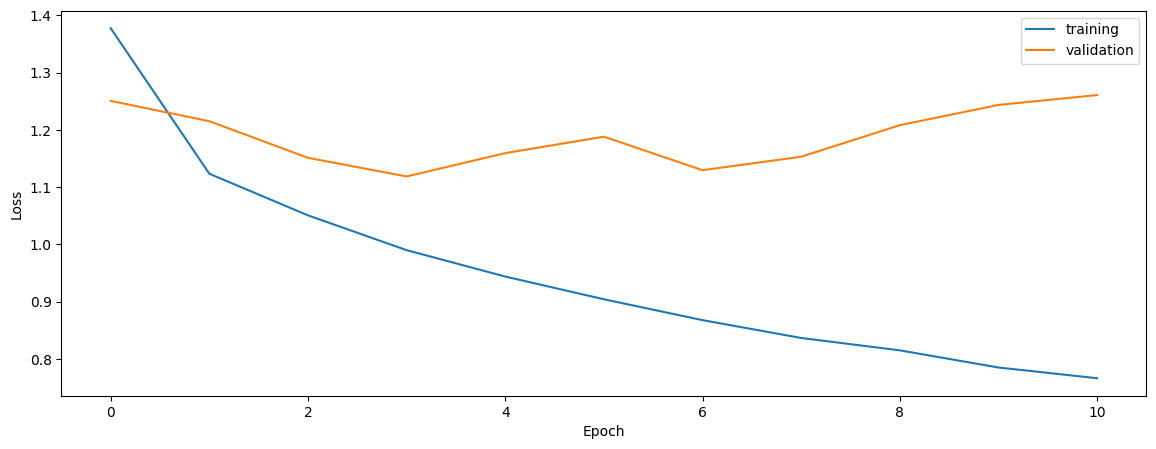

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.635739562556912
0.5728804503435864
0.5206350084864586


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5753910569939916
0.5551534006899951
0.5231738785232235


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5884520153688672
0.5698777723246629
0.5379174085908724


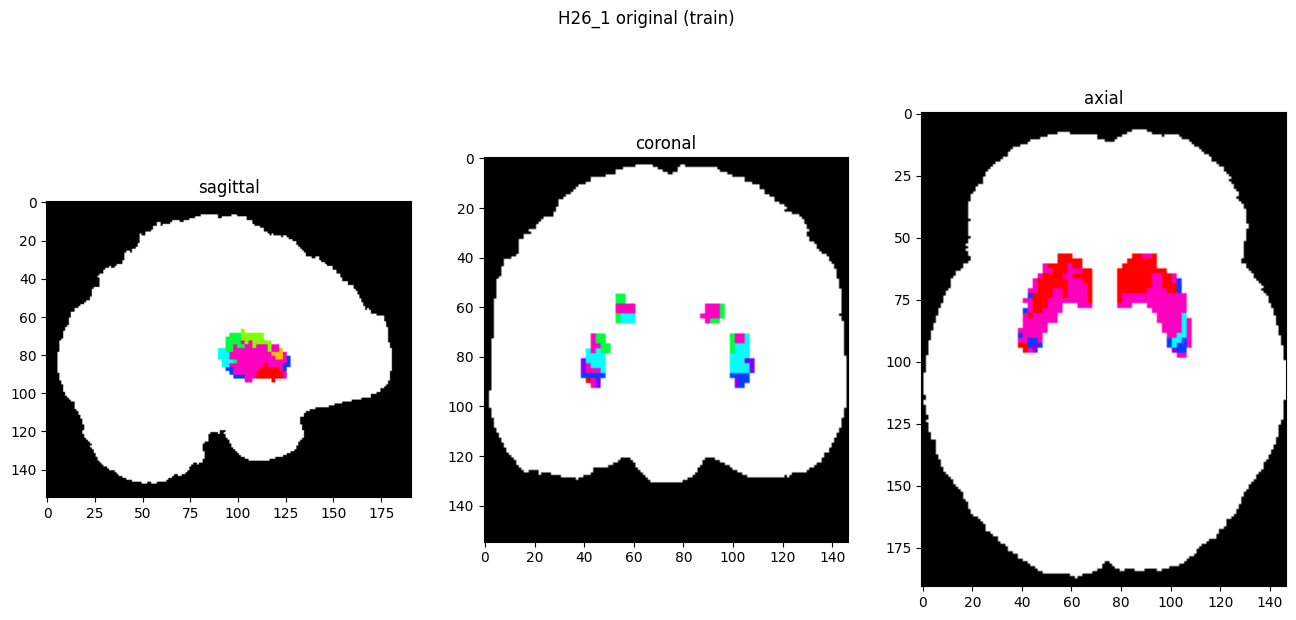

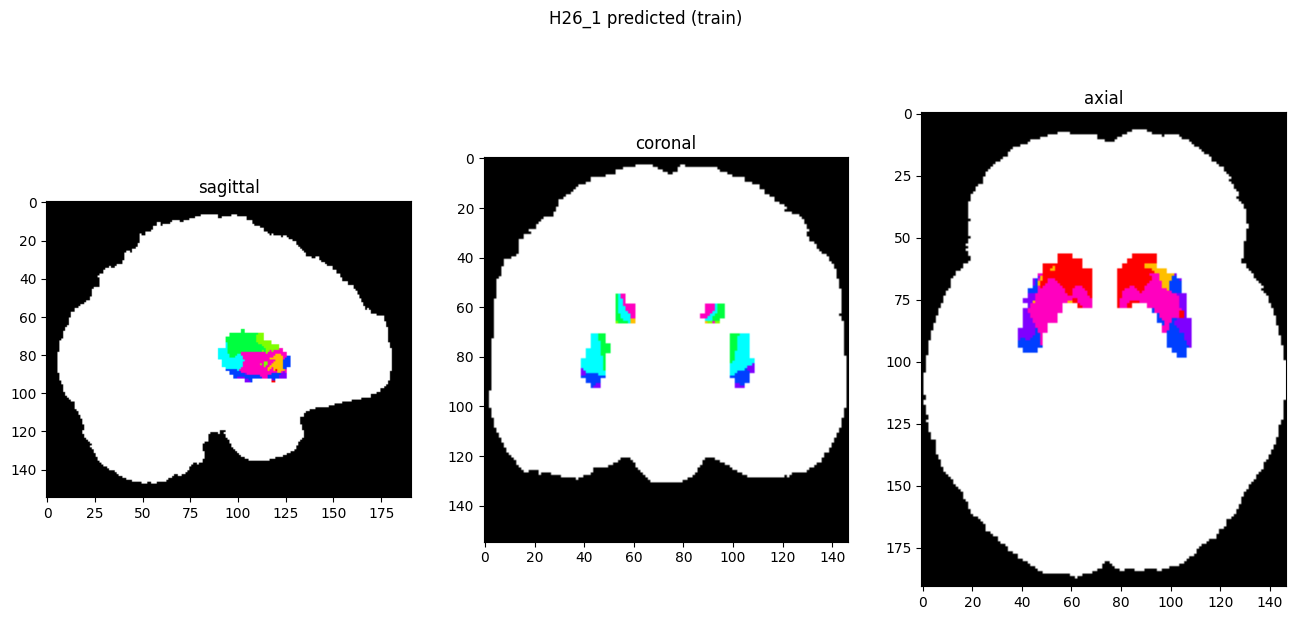

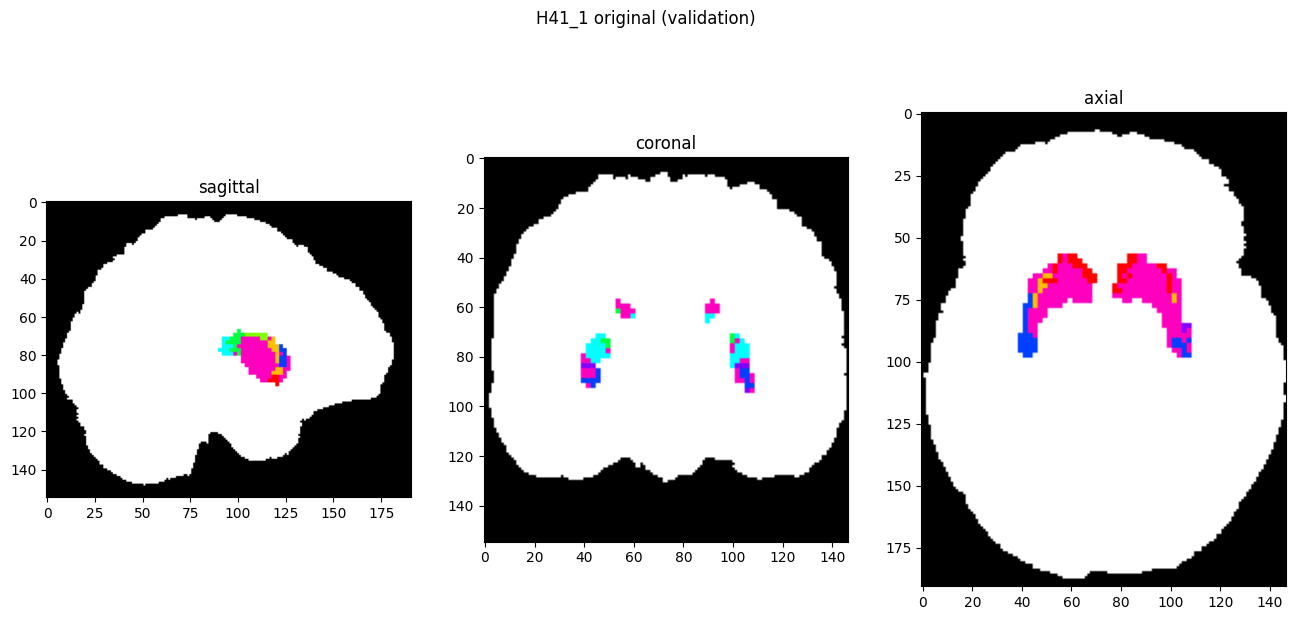

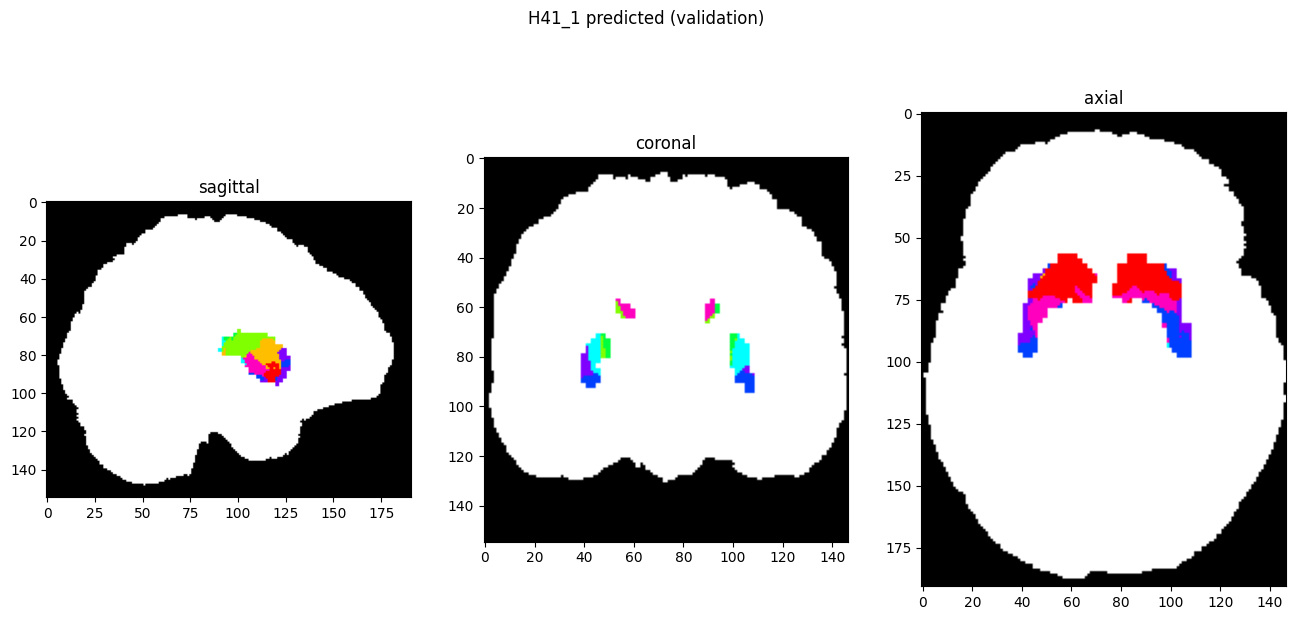

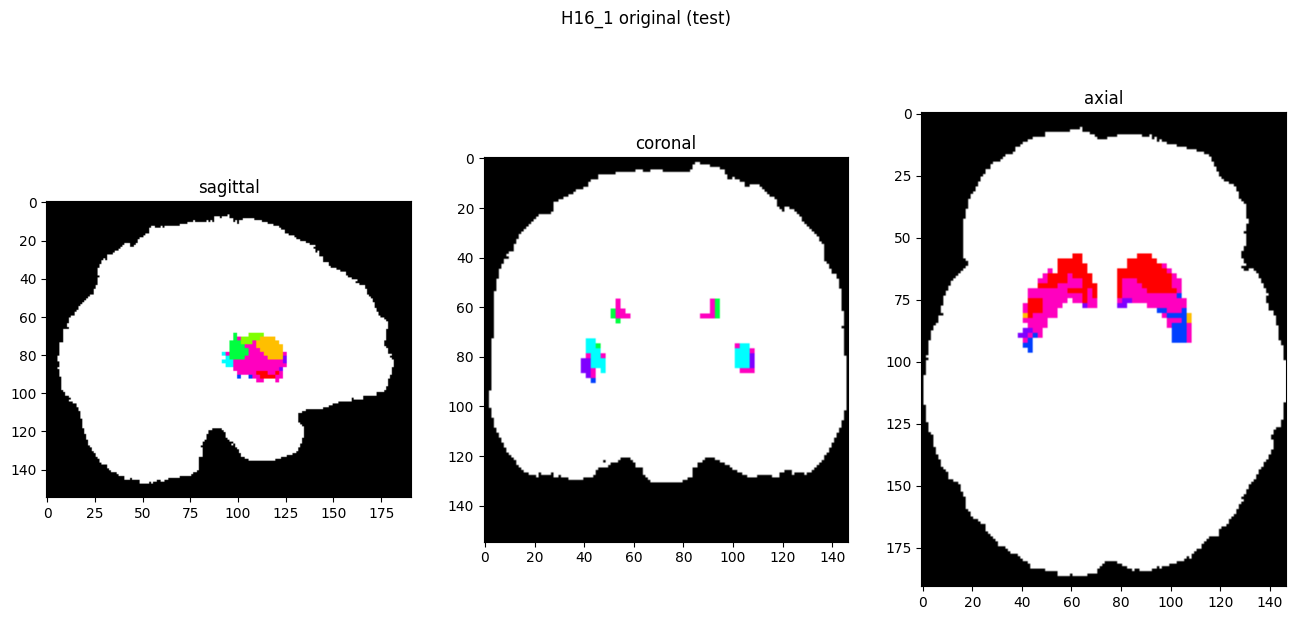

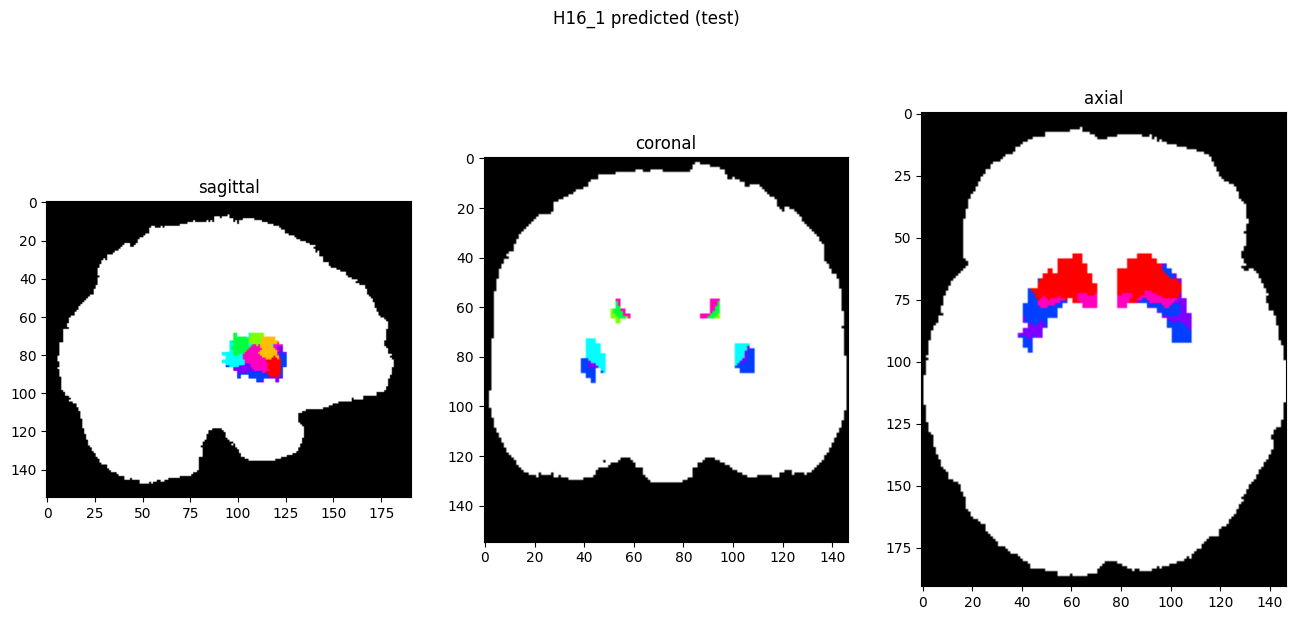

In [10]:
showResults(model, gen, threshold=0)